In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import os

import re
from adjustText import adjust_text
import anndata
import glob

from matplotlib import rc_context
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import liana as li
from liana.mt import rank_aggregate
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean # import individual methods
from pycirclize import Circos
from pycirclize.parser import Matrix
from matplotlib import cm, colors
from pathlib import Path
from itertools import combinations
from collections import defaultdict

import warnings


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in

In [2]:
plt.rcParams['figure.figsize']=(6, 6) # global figsize
plt.rcParams['axes.grid'] = False # turn down the grid globally
sc.settings.verbosity = 3
# sc.set_figure_params(figsize=(5, 5), dpi=200, dpi_save=300, facecolor="white")
sc.logging.print_versions()

-----
anndata     0.11.3
scanpy      1.10.4
-----
Bio                         1.85
Cython                      3.0.12
PIL                         11.1.0
adjustText                  1.3.0
anyio                       NA
appnope                     0.1.4
arrow                       1.3.0
asttokens                   NA
astunparse                  1.6.3
attr                        25.2.0
attrs                       25.2.0
babel                       2.17.0
certifi                     2025.01.31
cffi                        1.17.1
charset_normalizer          3.4.1
cloudpickle                 3.1.1
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython                      3.0.12
cython_runtime              NA
cytoolz                     1.0.1
dask                        2025.5.1
dateutil                    2.9.0.post0
debugpy                     1.8.13
decorator                   5.2.1
defusedxml                  0.7.1
dill               

/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.


In [3]:
# read in
astro = sc.read_h5ad("/Users/tianmi/Desktop/Datas/LIANA/AC_LIANA.h5ad")
micro = sc.read_h5ad("/Users/tianmi/Desktop/Datas/LIANA/MG_LIANA.h5ad")
oligo = sc.read_h5ad("/Users/tianmi/Desktop/Datas/LIANA/OLs_LIANA.h5ad")
# nsc = sc.read_h5ad("/Users/tianmi/Desktop/Datas/LIANA/NSC_LIANA.h5ad")

In [206]:
print(astro.X.max())
print(astro.X.min())
print(micro.X.max())
print(micro.X.min())

8.54285
0.0
7.708459
0.0


In [4]:
# print(astro.raw.X[0:10, 0:10])
print(astro.X[0:10, 0:10])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 5 stored elements and shape (10, 10)>
  Coords	Values
  (1, 3)	1.3388155698776245
  (2, 9)	1.5718060731887817
  (4, 6)	1.4897160530090332
  (6, 2)	1.0764471292495728
  (9, 1)	0.7637283205986023


- source and target : represent the source/sender and target/receiver cell identity for each interaction
- source: the sending cell type (the one expressing the ligand)
- target: the receiving cell type (the one expressing the receptor)

- ligand_props / receptor_props: the proportion of cells expressing the ligand or receptor in each cell type.
By default, any interactions in which either entity is not expressed in above 10% of cells per cell type is considered as a false positive, under the assumption that since CCC occurs between cell types, a sufficient proportion of cells within should express the genes.

- ligand_means / receptor_means: the average expression of the ligand or receptor in the respective cell types.

- lr_means(ligand-receptor) : mean ligand-receptor expression, as a measure of ligand-receptor interaction magnitude

- cellchat_pvals: permutation-based p-values, as a measure of interaction specificity

In [5]:
li.resource.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']

In [6]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."


In [ ]:
nsc.obs.columns

In [7]:
print(astro.obs.CellType_Alias.unique())
print(micro.obs.CellType_Alias.unique())
print(oligo.obs.CellType_Alias.unique())
# print(nsc.obs.CellType_Alias.unique())

['AC3', 'AC0', 'AC6', 'AC2', 'AC5', 'AC1', 'AC7', 'AC4']
Categories (8, object): ['AC0', 'AC1', 'AC2', 'AC3', 'AC4', 'AC5', 'AC6', 'AC7']
['MG0', 'MG6', 'MG7', 'MG5', 'MG1', 'MG3', 'MG2', 'MG4']
Categories (8, object): ['MG0', 'MG1', 'MG2', 'MG3', 'MG4', 'MG5', 'MG6', 'MG7']
['OL3', 'OL8', 'OL4', 'OL1', 'OL9', 'OL5', 'OL0', 'OL2', 'OL7', 'OL6']
Categories (10, object): ['OL0', 'OL1', 'OL2', 'OL3', ..., 'OL6', 'OL7', 'OL8', 'OL9']


In [8]:
astro.obs['leiden'] = 'AC_' + astro.obs['recluster'].astype(str)       
micro.obs['leiden'] = 'MG_' + micro.obs['recluster'].astype(str)
oligo.obs['leiden'] = 'MOL_' + oligo.obs['recluster'].astype(str)
# nsc.obs['leiden'] = 'NSC_' + nsc.obs['recluster'].astype(str)

In [9]:
adata = anndata.concat([astro, micro, oligo], 
                    join='outer', # keep all genes, take the union
                    label='origin', 
                    keys=['Astrocyte', 'Microglia', 'Oligodendrocytes'], # , 'Neurogenesis'
                    merge='unique')

/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [284]:
adata.obs.CellType_Alias.unique()

['AC3', 'AC0', 'AC6', 'AC2', 'AC5', ..., 'OL5', 'OL0', 'OL2', 'OL7', 'OL6']
Length: 26
Categories (26, object): ['AC0', 'AC1', 'AC2', 'AC3', ..., 'OL6', 'OL7', 'OL8', 'OL9']

In [285]:
adata.obs['origin'].unique().sort_values()

['Astrocyte', 'Microglia', 'Oligodendrocytes']
Categories (3, object): ['Astrocyte', 'Microglia', 'Oligodendrocytes']

In [10]:
print(adata.raw is not None)  # True means it's initialized

False


In [11]:
adata.obs_names_make_unique()  
adata.var_names_make_unique() 

In [12]:
adata.raw = adata.copy()

# splite adata based on conditions

In [289]:
adata_A = adata[adata.obs['geno_treat'].isin(['5XFAD_LPS', '5XFAD_Veh'])].copy()
adata_B = adata[adata.obs['geno_treat'].isin(['5XFAD_LPS', 'WT_LPS'])].copy()
adata_C = adata[adata.obs['geno_treat'].isin(['5XFAD_Veh', 'WT_Veh'])].copy()
adata_D = adata[adata.obs['geno_treat'].isin(['WT_LPS', 'WT_Veh'])].copy()

In [ ]:
adata_A.obs.origin.unique()

['Astrocyte', 'Microglia', 'Oligodendrocytes']
Categories (3, object): ['Astrocyte', 'Microglia', 'Oligodendrocytes']

# run LIANA on each adatas on geno_treat level

In [ ]:
# # Uppercase all gene names for LIANA input
# adata.var_names = adata.var_names.str.upper()

In [292]:
adata_A.var_names = adata_A.var_names.str.upper()
adata_B.var_names = adata_B.var_names.str.upper()
adata_C.var_names = adata_C.var_names.str.upper()
adata_D.var_names = adata_D.var_names.str.upper()

In [293]:
# Run rank_aggregate
li.mt.rank_aggregate(adata_A, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

li.mt.rank_aggregate(adata_B, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

li.mt.rank_aggregate(adata_C, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

li.mt.rank_aggregate(adata_D, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1393 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.31 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 12797 samples and 999 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Running CellPhoneDB


100%|██████████| 1000/1000 [00:03<00:00, 265.90it/s]
Using resource `celltalkdb`.
Using `.X`!


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1066 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.30 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 14495 samples and 1030 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Running CellPhoneDB


100%|██████████| 1000/1000 [00:04<00:00, 223.81it/s]
Using resource `celltalkdb`.
Using `.X`!


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1445 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.30 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 15022 samples and 1016 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:04<00:00, 236.20it/s]
Using resource `celltalkdb`.
Using `.X`!


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1100 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.29 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 16720 samples and 1036 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:05<00:00, 192.15it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [294]:
adata_A.var_names = adata_A.var_names.str.capitalize()
adata_B.var_names = adata_B.var_names.str.capitalize()
adata_C.var_names = adata_C.var_names.str.capitalize()
adata_D.var_names = adata_D.var_names.str.capitalize()

In [ ]:
datasets = {
    '5XFAD_LPS_vs_5XFAD_Veh': adata_A,
    '5XFAD_LPS_vs_WT_LPS':    adata_B,
    '5XFAD_Veh_vs_WT_Veh':    adata_C,
    'WT_LPS_vs_WT_Veh':       adata_D,
}

results = []          

for label, ad in datasets.items():
    df = ad.uns['liana_res'].copy()
    df['comparison'] = label

    ligand_col = 'ligand_complex' if 'ligand_complex' in df.columns else ('ligand' if 'ligand' in df.columns else 'ligand_gene_symbol')
    receptor_col = 'receptor_complex' if 'receptor_complex' in df.columns else ('receptor' if 'receptor' in df.columns else 'receptor_gene_symbol')

    df[ligand_col] = df[ligand_col].astype(str).str.capitalize()
    df[receptor_col] = df[receptor_col].astype(str).str.capitalize()

    results.append(df)

results_comparisons = pd.concat(results, ignore_index=True)

In [362]:
ligand_col   = ('ligand_complex'   if 'ligand_complex'   in results_comparisons.columns
             else 'ligand'         if 'ligand'           in results_comparisons.columns
             else 'ligand_gene_symbol')
receptor_col = ('receptor_complex' if 'receptor_complex' in results_comparisons.columns
             else 'receptor'       if 'receptor'         in results_comparisons.columns
             else 'receptor_gene_symbol')

for c in ['lr_logfc', 'scaled_weight']:
    if c not in results_comparisons.columns:
        results_comparisons[c] = 0.0
# results_comparisons['lr_logfc'] = pd.to_numeric(results_comparisons['lr_logfc'], errors='coerce').fillna(0.0)
# results_comparisons['scaled_weight'] = pd.to_numeric(results_comparisons['scaled_weight'], errors='coerce').fillna(0.0)

grp_keys = ['comparison', 'source', 'target', ligand_col]
ligand_stats = (results_comparisons
                .groupby(grp_keys)[receptor_col]
                .nunique()
                .reset_index(name='receptor_count'))

results_comparisons = results_comparisons.merge(ligand_stats, on=grp_keys, how='left')
results_comparisons['receptor_count'] = pd.to_numeric(results_comparisons['receptor_count'], errors='coerce').fillna(0).astype(float)

results_comparisons['regulatory_potential'] = (
    results_comparisons['receptor_count'] * results_comparisons['lr_logfc'] / 10.0
    + results_comparisons['scaled_weight']
)

verbose = True
if verbose:
    for (cmp_name, src, tgt), g in results_comparisons.groupby(['comparison','source','target']):
        print(f"Computed regulatory_potential for '{src} → {tgt}' @ {cmp_name}: rows={g.shape[0]}")


Computed regulatory_potential for 'Astrocyte → Astrocyte' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=160
Computed regulatory_potential for 'Astrocyte → Microglia' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=124
Computed regulatory_potential for 'Astrocyte → Oligodendrocytes' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=103
Computed regulatory_potential for 'Microglia → Astrocyte' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=134
Computed regulatory_potential for 'Microglia → Microglia' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=124
Computed regulatory_potential for 'Microglia → Oligodendrocytes' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=89
Computed regulatory_potential for 'Oligodendrocytes → Astrocyte' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=141
Computed regulatory_potential for 'Oligodendrocytes → Microglia' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=112
Computed regulatory_potential for 'Oligodendrocytes → Oligodendrocytes' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=95
Computed regulatory_potential for 'Astrocyte → Astrocyte' @ 5XFAD_LPS_vs_WT_LPS: rows=156
Computed regulatory_potential for

In [363]:
results_comparisons

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,comparison,receptor_count,regulatory_potential
0,Oligodendrocytes,Oligodendrocytes,App,Aplp1,3.530547,0.0,12.375208,1.341318,3.770955,0.556701,0.963650,0.000020,0.000008,5XFAD_LPS_vs_5XFAD_Veh,10.0,5.112273
1,Astrocyte,Microglia,Apoe,Trem2,3.436067,0.0,11.265479,0.989900,3.623961,0.505517,0.961968,0.003409,0.000031,5XFAD_LPS_vs_5XFAD_Veh,4.0,2.439484
2,Astrocyte,Astrocyte,Ptn,Ptprz1,2.880008,0.0,8.293018,1.057601,3.077325,0.482440,0.955950,0.001642,0.000069,5XFAD_LPS_vs_5XFAD_Veh,3.0,1.980798
3,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,2.732689,0.0,7.455588,0.964318,2.253426,0.433723,0.953654,0.035926,0.000123,5XFAD_LPS_vs_5XFAD_Veh,3.0,1.640345
4,Microglia,Microglia,Gnai2,P2ry12,2.662032,0.0,6.419744,0.799098,3.151260,0.455438,0.950234,0.055875,0.000276,5XFAD_LPS_vs_5XFAD_Veh,5.0,2.374727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,Astrocyte,Astrocyte,Lrpap1,Sort1,0.374164,1.0,0.128047,-0.141129,-0.214628,0.060994,0.739046,1.000000,1.000000,WT_LPS_vs_WT_Veh,5.0,-0.248443
4179,Oligodendrocytes,Microglia,Plat,Itgb2,0.426223,0.0,0.120154,0.597310,0.903911,0.694104,0.732865,0.104036,1.000000,WT_LPS_vs_WT_Veh,3.0,0.868483
4180,Astrocyte,Astrocyte,Mdk,Itgb1,0.377889,1.0,0.132262,0.029154,0.124931,0.128428,0.742157,1.000000,1.000000,WT_LPS_vs_WT_Veh,7.0,0.116606
4181,Astrocyte,Astrocyte,Lama2,Itgb1,0.290654,1.0,0.084242,-0.055651,-0.104721,0.104139,0.696707,1.000000,1.000000,WT_LPS_vs_WT_Veh,3.0,-0.087067


In [216]:
adata.uns.keys()
# ACMG.uns['liana_res'].columns

odict_keys(['liana_res'])

In [298]:
(results_comparisons['cellphone_pvals'] < 0).any()

np.False_

In [299]:
unique_pairs = results_comparisons[['source', 'target']].drop_duplicates()
num_unique_pairs = unique_pairs.shape[0]
print(f"{num_unique_pairs} unique source-target pairs")

9 unique source-target pairs


In [300]:
display(unique_pairs)

,source,target
0,Oligodendrocytes,Oligodendrocytes
1,Astrocyte,Microglia
2,Astrocyte,Astrocyte
3,Oligodendrocytes,Astrocyte
4,Microglia,Microglia
5,Oligodendrocytes,Microglia
13,Microglia,Oligodendrocytes
14,Microglia,Astrocyte
16,Astrocyte,Oligodendrocytes


# splite adata based on gender and conditions

In [13]:
male_A = adata[adata.obs['geno_treat_sex'].isin(['5XFAD_LPS_M', '5XFAD_Veh_M'])].copy()
male_B = adata[adata.obs['geno_treat_sex'].isin(['5XFAD_LPS_M', 'WT_LPS_M'])].copy()
male_C = adata[adata.obs['geno_treat_sex'].isin(['5XFAD_Veh_M', 'WT_Veh_M'])].copy()
male_D = adata[adata.obs['geno_treat_sex'].isin(['WT_LPS_M', 'WT_Veh_M'])].copy()

In [ ]:
# female_A.obs.origin.unique()

NameError: name 'female_A' is not defined

In [22]:
female_A = adata[adata.obs['geno_treat_sex'].isin(['5XFAD_LPS_F', '5XFAD_Veh_F'])].copy()
female_B = adata[adata.obs['geno_treat_sex'].isin(['5XFAD_LPS_F', 'WT_LPS_F'])].copy()
female_C = adata[adata.obs['geno_treat_sex'].isin(['5XFAD_Veh_F', 'WT_Veh_F'])].copy()
female_D = adata[adata.obs['geno_treat_sex'].isin(['WT_LPS_F', 'WT_Veh_F'])].copy()

# run LIANA on each adatas on geno_treat_sex level

## Male

In [15]:
male_A.var_names = male_A.var_names.str.upper()
male_B.var_names = male_B.var_names.str.upper()
male_C.var_names = male_C.var_names.str.upper()
male_D.var_names = male_D.var_names.str.upper()

In [16]:
# Run rank_aggregate
li.mt.rank_aggregate(male_A, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

li.mt.rank_aggregate(male_B, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

li.mt.rank_aggregate(male_C, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

li.mt.rank_aggregate(male_D, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2031 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.33 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 6008 samples and 961 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
100%|██████████| 1000/1000 [00:01<00:00, 607.18it/s]
Using resource `celltalkdb`.
Using `.X`!


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1769 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.32 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 5708 samples and 971 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
100%|██████████| 1000/1000 [00:01<00:00, 614.15it/s]
Using resource `celltalkdb`.
Using `.X`!


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2082 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 6108 samples and 950 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:01<00:00, 660.72it/s]
Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1819 features of mat are empty, they will be removed.


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.33 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 5808 samples and 970 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:01<00:00, 672.65it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [17]:
male_A.var_names = male_A.var_names.str.capitalize()
male_B.var_names = male_B.var_names.str.capitalize()
male_C.var_names = male_C.var_names.str.capitalize()
male_D.var_names = male_D.var_names.str.capitalize()

In [18]:
datasets_M = {
    '5XFAD_LPS_vs_5XFAD_Veh': male_A,
    '5XFAD_LPS_vs_WT_LPS':    male_B,
    '5XFAD_Veh_vs_WT_Veh':    male_C,
    'WT_LPS_vs_WT_Veh':       male_D,
}

results_M = []          

for label, ad in datasets_M.items():
    df = ad.uns['liana_res'].copy()
    df['comparison'] = label

    ligand_col = 'ligand_complex' if 'ligand_complex' in df.columns else ('ligand' if 'ligand' in df.columns else 'ligand_gene_symbol')
    receptor_col = 'receptor_complex' if 'receptor_complex' in df.columns else ('receptor' if 'receptor' in df.columns else 'receptor_gene_symbol')

    df[ligand_col] = df[ligand_col].astype(str).str.capitalize()
    df[receptor_col] = df[receptor_col].astype(str).str.capitalize()

    results_M.append(df)

results_comparisons_M = pd.concat(results_M, ignore_index=True)

In [19]:
ligand_col   = ('ligand_complex'   if 'ligand_complex'   in results_comparisons_M.columns
             else 'ligand'         if 'ligand'           in results_comparisons_M.columns
             else 'ligand_gene_symbol')
receptor_col = ('receptor_complex' if 'receptor_complex' in results_comparisons_M.columns
             else 'receptor'       if 'receptor'         in results_comparisons_M.columns
             else 'receptor_gene_symbol')

for c in ['lr_logfc', 'scaled_weight']:
    if c not in results_comparisons_M.columns:
        results_comparisons_M[c] = 0.0
# results_comparisons['lr_logfc'] = pd.to_numeric(results_comparisons['lr_logfc'], errors='coerce').fillna(0.0)
# results_comparisons['scaled_weight'] = pd.to_numeric(results_comparisons['scaled_weight'], errors='coerce').fillna(0.0)

grp_keys = ['comparison', 'source', 'target', ligand_col]
ligand_stats = (results_comparisons_M
                .groupby(grp_keys)[receptor_col]
                .nunique()
                .reset_index(name='receptor_count'))

results_comparisons_M = results_comparisons_M.merge(ligand_stats, on=grp_keys, how='left')
results_comparisons_M['receptor_count'] = pd.to_numeric(results_comparisons_M['receptor_count'], errors='coerce').fillna(0).astype(float)

results_comparisons_M['regulatory_potential'] = (
    results_comparisons_M['receptor_count'] * results_comparisons_M['lr_logfc'] / 10.0
    + results_comparisons_M['scaled_weight']
)

verbose = True
if verbose:
    for (cmp_name, src, tgt), g in results_comparisons_M.groupby(['comparison','source','target']):
        print(f"Computed regulatory_potential for '{src} → {tgt}' @ {cmp_name}: rows={g.shape[0]}")


Computed regulatory_potential for 'Astrocyte → Astrocyte' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=161
Computed regulatory_potential for 'Astrocyte → Microglia' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=127
Computed regulatory_potential for 'Astrocyte → Oligodendrocytes' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=103
Computed regulatory_potential for 'Microglia → Astrocyte' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=136
Computed regulatory_potential for 'Microglia → Microglia' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=127
Computed regulatory_potential for 'Microglia → Oligodendrocytes' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=89
Computed regulatory_potential for 'Oligodendrocytes → Astrocyte' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=136
Computed regulatory_potential for 'Oligodendrocytes → Microglia' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=111
Computed regulatory_potential for 'Oligodendrocytes → Oligodendrocytes' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=91
Computed regulatory_potential for 'Astrocyte → Astrocyte' @ 5XFAD_LPS_vs_WT_LPS: rows=160
Computed regulatory_potential for

In [20]:
results_comparisons_M

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,comparison,receptor_count,regulatory_potential
0,Oligodendrocytes,Oligodendrocytes,App,Aplp1,3.580060,0.000,12.677464,1.336110,3.748688,0.549710,0.962626,0.000021,0.000008,5XFAD_LPS_vs_5XFAD_Veh,10.0,5.084798
1,Astrocyte,Microglia,Apoe,Trem2,3.474453,0.000,11.489539,1.037158,3.677489,0.511963,0.960815,0.002029,0.000031,5XFAD_LPS_vs_5XFAD_Veh,5.0,2.875902
2,Astrocyte,Astrocyte,Ptn,Ptprz1,2.807645,0.000,7.878561,0.944531,2.914443,0.478756,0.953062,0.005155,0.000069,5XFAD_LPS_vs_5XFAD_Veh,3.0,1.818864
3,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,2.690310,0.000,7.235094,0.868874,2.130713,0.439654,0.951119,0.052037,0.000123,5XFAD_LPS_vs_5XFAD_Veh,3.0,1.508088
4,Microglia,Microglia,Gnai2,P2ry12,2.686445,0.000,6.602959,0.891338,3.144949,0.452678,0.948950,0.011483,0.000192,5XFAD_LPS_vs_5XFAD_Veh,5.0,2.463813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206,Astrocyte,Astrocyte,Rtn4,Tnfrsf19,0.471270,1.000,0.208202,0.018476,-0.112711,0.116848,0.775971,1.000000,1.000000,WT_LPS_vs_WT_Veh,1.0,0.007205
4207,Oligodendrocytes,Oligodendrocytes,Arf1,Insr,0.472036,0.666,0.164645,-0.012352,-0.205864,0.098808,0.754912,1.000000,1.000000,WT_LPS_vs_WT_Veh,1.0,-0.032939
4208,Astrocyte,Astrocyte,Pdap1,Pdgfrb,0.460312,0.000,0.151705,0.221555,0.705975,0.211558,0.747261,0.306451,1.000000,WT_LPS_vs_WT_Veh,1.0,0.292152
4209,Astrocyte,Astrocyte,Arf1,Insr,0.324986,1.000,0.105386,-0.162873,-0.318259,0.063245,0.711340,1.000000,1.000000,WT_LPS_vs_WT_Veh,2.0,-0.226524


## Female

In [23]:
female_A.var_names = female_A.var_names.str.upper()
female_B.var_names = female_B.var_names.str.upper()
female_C.var_names = female_C.var_names.str.upper()
female_D.var_names = female_D.var_names.str.upper()

In [24]:
# Run rank_aggregate
li.mt.rank_aggregate(female_A, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

li.mt.rank_aggregate(female_B, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

li.mt.rank_aggregate(female_C, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

li.mt.rank_aggregate(female_D, # an aggregate of ligand-receptor scores from multiple methods
                     groupby='origin',
                     resource_name='celltalkdb',
                     expr_prop=0.1,
                     verbose=True,
                     use_raw=False)

Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1960 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 6789 samples and 945 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Running CellPhoneDB


100%|██████████| 1000/1000 [00:01<00:00, 535.93it/s]
Using resource `celltalkdb`.
Using `.X`!


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1590 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.32 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 8787 samples and 991 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
100%|██████████| 1000/1000 [00:02<00:00, 424.78it/s]
Using resource `celltalkdb`.
Using `.X`!


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2093 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.33 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 8914 samples and 974 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
100%|██████████| 1000/1000 [00:02<00:00, 432.86it/s]
Using resource `celltalkdb`.
Using `.X`!


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1780 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.31 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 10912 samples and 996 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Running CellPhoneDB


100%|██████████| 1000/1000 [00:02<00:00, 337.75it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [25]:
female_A.var_names = female_A.var_names.str.capitalize()
female_B.var_names = female_B.var_names.str.capitalize()
female_C.var_names = female_C.var_names.str.capitalize()
female_D.var_names = female_D.var_names.str.capitalize()

In [26]:
datasets_F = {
    '5XFAD_LPS_vs_5XFAD_Veh': female_A,
    '5XFAD_LPS_vs_WT_LPS': female_B,
    '5XFAD_Veh_vs_WT_Veh': female_C,
    'WT_LPS_vs_WT_Veh': female_D,
}

results_F = []          

for label, ad in datasets_F.items():
    df = ad.uns['liana_res'].copy()
    df['comparison'] = label

    ligand_col = 'ligand_complex' if 'ligand_complex' in df.columns else ('ligand' if 'ligand' in df.columns else 'ligand_gene_symbol')
    receptor_col = 'receptor_complex' if 'receptor_complex' in df.columns else ('receptor' if 'receptor' in df.columns else 'receptor_gene_symbol')

    df[ligand_col] = df[ligand_col].astype(str).str.capitalize()
    df[receptor_col] = df[receptor_col].astype(str).str.capitalize()

    results_F.append(df)

results_comparisons_F = pd.concat(results_F, ignore_index=True)

In [27]:
ligand_col   = ('ligand_complex'   if 'ligand_complex'   in results_comparisons_F.columns
             else 'ligand'         if 'ligand'           in results_comparisons_F.columns
             else 'ligand_gene_symbol')
receptor_col = ('receptor_complex' if 'receptor_complex' in results_comparisons_F.columns
             else 'receptor'       if 'receptor'         in results_comparisons_F.columns
             else 'receptor_gene_symbol')

for c in ['lr_logfc', 'scaled_weight']:
    if c not in results_comparisons_F.columns:
        results_comparisons_F[c] = 0.0
# results_comparisons['lr_logfc'] = pd.to_numeric(results_comparisons['lr_logfc'], errors='coerce').fillna(0.0)
# results_comparisons['scaled_weight'] = pd.to_numeric(results_comparisons['scaled_weight'], errors='coerce').fillna(0.0)

grp_keys = ['comparison', 'source', 'target', ligand_col]
ligand_stats = (results_comparisons_F
                .groupby(grp_keys)[receptor_col]
                .nunique()
                .reset_index(name='receptor_count'))

results_comparisons_F = results_comparisons_F.merge(ligand_stats, on=grp_keys, how='left')
results_comparisons_F['receptor_count'] = pd.to_numeric(results_comparisons_F['receptor_count'], errors='coerce').fillna(0).astype(float)

results_comparisons_F['regulatory_potential'] = (
    results_comparisons_F['receptor_count'] * results_comparisons_F['lr_logfc'] / 10.0
    + results_comparisons_F['scaled_weight']
)

verbose = True
if verbose:
    for (cmp_name, src, tgt), g in results_comparisons_F.groupby(['comparison','source','target']):
        print(f"Computed regulatory_potential for '{src} → {tgt}' @ {cmp_name}: rows={g.shape[0]}")


Computed regulatory_potential for 'Astrocyte → Astrocyte' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=150
Computed regulatory_potential for 'Astrocyte → Microglia' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=124
Computed regulatory_potential for 'Astrocyte → Oligodendrocytes' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=101
Computed regulatory_potential for 'Microglia → Astrocyte' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=127
Computed regulatory_potential for 'Microglia → Microglia' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=128
Computed regulatory_potential for 'Microglia → Oligodendrocytes' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=89
Computed regulatory_potential for 'Oligodendrocytes → Astrocyte' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=134
Computed regulatory_potential for 'Oligodendrocytes → Microglia' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=116
Computed regulatory_potential for 'Oligodendrocytes → Oligodendrocytes' @ 5XFAD_LPS_vs_5XFAD_Veh: rows=95
Computed regulatory_potential for 'Astrocyte → Astrocyte' @ 5XFAD_LPS_vs_WT_LPS: rows=158
Computed regulatory_potential for

In [28]:
results_comparisons_F

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,comparison,receptor_count,regulatory_potential
0,Oligodendrocytes,Oligodendrocytes,App,Aplp1,3.485342,0.0,12.093950,1.348867,3.792959,0.566334,0.962411,0.000085,0.000008,5XFAD_LPS_vs_5XFAD_Veh,11.0,5.521121
1,Astrocyte,Microglia,Apoe,Trem2,3.394269,0.0,11.028987,0.955078,3.566133,0.496054,0.960708,0.005997,0.000032,5XFAD_LPS_vs_5XFAD_Veh,4.0,2.381531
2,Astrocyte,Astrocyte,Ptn,Ptprz1,2.963360,0.0,8.781471,1.174559,3.239715,0.486908,0.956174,0.000757,0.000071,5XFAD_LPS_vs_5XFAD_Veh,2.0,1.822501
3,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,2.783359,0.0,7.716689,1.061901,2.373519,0.427869,0.953384,0.026251,0.000127,5XFAD_LPS_vs_5XFAD_Veh,2.0,1.536605
4,Oligodendrocytes,Microglia,Apoe,Trem2,2.665864,0.0,7.106105,0.544205,1.608220,0.319613,0.951518,0.088258,0.000198,5XFAD_LPS_vs_5XFAD_Veh,4.0,1.187493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4133,Astrocyte,Oligodendrocytes,Gas6,Tyro3,0.396620,0.0,0.149022,0.371656,0.557588,0.329654,0.747232,0.121334,1.000000,WT_LPS_vs_WT_Veh,1.0,0.427414
4134,Astrocyte,Microglia,App,Aplp2,0.343015,1.0,0.114296,-0.691326,-2.383646,0.008541,0.721367,1.000000,1.000000,WT_LPS_vs_WT_Veh,10.0,-3.074972
4135,Astrocyte,Microglia,App,Aplp1,0.281176,1.0,0.079045,-0.815415,-3.624636,0.003406,0.682842,1.000000,1.000000,WT_LPS_vs_WT_Veh,10.0,-4.440051
4136,Astrocyte,Astrocyte,Sema4a,Plxnb1,0.384520,0.0,0.143818,0.400295,1.003135,0.785489,0.743860,0.094982,1.000000,WT_LPS_vs_WT_Veh,2.0,0.600922


# LIANA on geno_treat level

In [77]:
all_res = []
for cond in adata.obs['geno_treat'].unique():
    ad = adata[adata.obs['geno_treat'] == cond].copy()
    df = li.mt.rank_aggregate(
        ad,
        groupby='origin',
        resource_name='celltalkdb',
        expr_prop=0.1,
        verbose=True,
        use_raw=False
    )  

    if df is None:
        df = ad.uns.get('liana_res').copy()
    df['geno_treat'] = cond
    all_res.append(df)

Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1516 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.31 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 8488 samples and 1007 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Running CellPhoneDB


100%|██████████| 1000/1000 [00:02<00:00, 414.42it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2161 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 6790 samples and 958 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:01<00:00, 586.51it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
1994 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModification

Generating ligand-receptor stats for 8232 samples and 970 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
100%|██████████| 1000/1000 [00:02<00:00, 485.28it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
1935 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 6007 samples and 955 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:01<00:00, 649.91it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [55]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 29517 × 20705
    obs: 'batches', 'genotype', 'brain_region', 'gender', 'treatment', 'geno_treat', 'geno_treat_sex', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'geno_treat_density', 'geno_treat_sex_density', 'dpt_pseudotime', 'recluster', 'S_score', 'G2M_score', 'phase', 'CellType', 'CellType_Alias', 'Homeo_score', 'DAMI_score', 'DAMII_score', 'IEG_score', 'Inflamed_score', 'origin'
    uns: 'liana_res'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'>

In [78]:
res = pd.concat(all_res, ignore_index=True)
for col in ['ligand_complex', 'receptor_complex']:
    if col in res.columns:
        res[col] = res[col].str.capitalize()

In [80]:
if 'cellphone_pvals' in res.columns:
    res = res[res['cellphone_pvals'] <= 0.05].copy()
   
print(res.shape)
print(res.columns.tolist())  
res.head()

(2860, 14)
['source', 'target', 'ligand_complex', 'receptor_complex', 'lr_means', 'cellphone_pvals', 'expr_prod', 'scaled_weight', 'lr_logfc', 'spec_weight', 'lrscore', 'specificity_rank', 'magnitude_rank', 'geno_treat']


,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,geno_treat
0,Oligodendrocytes,Oligodendrocytes,App,Aplp1,3.584860,0.0,12.717410,1.250638,3.790285,0.554228,0.963551,0.000507,0.000008,WT_LPS
1,Astrocyte,Microglia,Apoe,Trem2,3.436171,0.0,11.144939,1.109161,3.520392,0.511365,0.961161,0.001294,0.000031,WT_LPS
2,Astrocyte,Astrocyte,Ptn,Ptprz1,2.909159,0.0,8.458058,0.818509,2.940918,0.481852,0.955671,0.063121,0.000069,WT_LPS
3,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,2.718141,0.0,7.374070,0.695086,1.977615,0.420097,0.952674,0.093053,0.000191,WT_LPS
4,Microglia,Microglia,Gnai2,P2ry12,2.729804,0.0,6.916722,1.092347,3.181063,0.453865,0.951209,0.001636,0.000275,WT_LPS


In [69]:
res['geno_treat'].unique()

array(['WT_LPS', '5XFAD_Veh', 'WT_Veh', '5XFAD_LPS'], dtype=object)

In [94]:
res['geno_treat'].value_counts()

res.groupby(['geno_treat','source','target']).size().reset_index(name='n').sort_values('n', ascending=False).head(20)

# res.filter(regex='rank|score|consensus|aggregate', axis=1).head()

,geno_treat,source,target,n
4,5XFAD_LPS,Microglia,Microglia,106
22,WT_LPS,Microglia,Microglia,103
24,WT_LPS,Oligodendrocytes,Astrocyte,102
13,5XFAD_Veh,Microglia,Microglia,98
15,5XFAD_Veh,Oligodendrocytes,Astrocyte,97
18,WT_LPS,Astrocyte,Astrocyte,95
6,5XFAD_LPS,Oligodendrocytes,Astrocyte,94
25,WT_LPS,Oligodendrocytes,Microglia,93
7,5XFAD_LPS,Oligodendrocytes,Microglia,92
31,WT_Veh,Microglia,Microglia,91


# LIANA on geno_treat_sex level

In [ ]:
gts_res = []
for cond in adata.obs['geno_treat_sex'].unique():
    ad = adata[adata.obs['geno_treat_sex'] == cond].copy()
    df_gts = li.mt.rank_aggregate(
        ad,
        groupby='origin',
        resource_name='celltalkdb',
        expr_prop=0.1,
        verbose=True,
        use_raw=False
    )  

    if df_gts is None:
        df_gts = ad.uns.get('liana_res').copy()
    df_gts['geno_treat_sex'] = cond
    gts_res.append(df_gts)

Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2362 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.36 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 3083 samples and 914 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:00<00:00, 1091.27it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2224 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 5405 samples and 961 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:01<00:00, 630.41it/s]
Using resource `celltalkdb`.


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2838 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.37 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 3383 samples and 900 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:00<00:00, 1087.63it/s]
Using resource `celltalkdb`.


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2742 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.35 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 5507 samples and 932 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:01<00:00, 742.86it/s]
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
2868 features of mat are empty, they will be removed.


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.39 of entities in the resource are missing from t

Generating ligand-receptor stats for 2725 samples and 876 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:00<00:00, 1281.66it/s]
Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2790 features of mat are empty, they will be removed.


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.36 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 2625 samples and 905 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:00<00:00, 1286.78it/s]
Using resource `celltalkdb`.
Using `.X`!


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2550 features of mat are empty, they will be removed.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.38 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 3382 samples and 888 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:00<00:00, 1046.11it/s]
Using resource `celltalkdb`.
Using `.X`!
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2861 features of mat are empty, they will be removed.


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.37 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 3407 samples and 896 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/tianmi/anaconda3/envs/scanpy_env/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:00<00:00, 1110.13it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [195]:
adata.var_names = adata.var_names.str.capitalize()

In [196]:
gts_results = pd.concat(gts_res, ignore_index=True)
for col in ['ligand_complex', 'receptor_complex']:
    if col in gts_results.columns:
        gts_results[col] = gts_results[col].str.capitalize()

In [ ]:
gts_results.head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,geno_treat_sex
0,Oligodendrocytes,Oligodendrocytes,App,Aplp1,3.462880,0.0,11.896286,1.310173,3.777344,0.559905,0.960303,0.000181,0.000008,WT_LPS_M
1,Astrocyte,Microglia,Apoe,Trem2,3.162335,0.0,9.391846,1.032828,3.283781,0.502114,0.955544,0.003899,0.000030,WT_LPS_M
2,Astrocyte,Astrocyte,Ptn,Ptprz1,2.772225,0.0,7.652609,0.820999,2.921976,0.472839,0.950986,0.065461,0.000068,WT_LPS_M
3,Microglia,Microglia,Gnai2,P2ry12,2.688225,0.0,6.783748,1.050733,3.201435,0.474067,0.948099,0.002416,0.000189,WT_LPS_M
4,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,2.628995,0.0,6.806731,0.720826,2.147860,0.420574,0.948183,0.080098,0.000189,WT_LPS_M


In [198]:
gts_results.geno_treat_sex.unique()

array(['WT_LPS_M', 'WT_LPS_F', '5XFAD_Veh_M', 'WT_Veh_F', 'WT_Veh_M',
       '5XFAD_LPS_M', '5XFAD_LPS_F', '5XFAD_Veh_F'], dtype=object)

# Propoetions of interactions

In [25]:
# Count the number of significant interactions between 4 types of cell-pairs
pair_counts = {
    'Astro→Micro': ((adata_liana['source'] == 'Astrocyte') & (adata_liana['target'] == 'Microglia')).sum(),
    'Astro→Oligo': ((adata_liana['source'] == 'Astrocyte') & (adata_liana['target'] == 'Oligodendrocytes')).sum(),
    # 'Astro→NSC': ((adata_liana['source'] == 'Astrocyte') & (adata_liana['target'] == 'Neurogenesis')).sum(),
    'Astro→Astro': ((adata_liana['source'] == 'Astrocyte') & (adata_liana['target'] == 'Astrocyte')).sum(),

    'Micro→Astro': ((adata_liana['source'] == 'Microglia') & (adata_liana['target'] == 'Astrocyte')).sum(),
    'Micro→Oligo': ((adata_liana['source'] == 'Microglia') & (adata_liana['target'] == 'Oligodendrocytes')).sum(),
    # 'Micro→NSC': ((adata_liana['source'] == 'Microglia') & (adata_liana['target'] == 'Neurogenesis')).sum(),
    'Micro→Micro': ((adata_liana['source'] == 'Microglia') & (adata_liana['target'] == 'Microglia')).sum(),

    'Oligo→Astro': ((adata_liana['source'] == 'Oligodendrocytes') & (adata_liana['target'] == 'Astrocyte')).sum(),
    'Oligo→Micro': ((adata_liana['source'] == 'Oligodendrocytes') & (adata_liana['target'] == 'Microglia')).sum(),
    # 'Oligo→NSC': ((adata_liana['source'] == 'Oligodendrocytes') & (adata_liana['target'] == 'Neurogenesis')).sum(),
    'Oligo→Oligo': ((adata_liana['source'] == 'Oligodendrocytes') & (adata_liana['target'] == 'Oligodendrocytes')).sum(),

    # 'NSC→Astro': ((adata_liana['source'] == 'Neurogenesis') & (adata_liana['target'] == 'Astrocyte')).sum(),
    # 'NSC→Micro': ((adata_liana['source'] == 'Neurogenesis') & (adata_liana['target'] == 'Microglia')).sum(),
    # 'NSC→Oligo': ((adata_liana['source'] == 'Neurogenesis') & (adata_liana['target'] == 'Oligodendrocytes')).sum(),
    # 'NSC→NSC': ((adata_liana['source'] == 'Neurogenesis') & (adata_liana['target'] == 'Neurogenesis')).sum(),

}

In [26]:
# count total number of significant interactions in LIANA results
total_pairs = len(adata_liana)

# count the percentage of each interaction of cell_pairs
pair_percentages = {
    k: f"{(v / total_pairs * 100):.2f}%"
    for k, v in pair_counts.items()
}

In [27]:
pair_percentages

{'Astro→Micro': '10.99%',
 'Astro→Oligo': '9.35%',
 'Astro→Astro': '14.46%',
 'Micro→Astro': '12.73%',
 'Micro→Oligo': '8.68%',
 'Micro→Micro': '11.96%',
 'Oligo→Astro': '12.73%',
 'Oligo→Micro': '10.32%',
 'Oligo→Oligo': '8.78%'}

In [28]:
print("Significant interaction counts between cell types :")
for k, v in pair_counts.items():
    print(f"{k}: {v} interactions ({pair_percentages[k]})")

Significant interaction counts between cell types :
Astro→Micro: 114 interactions (10.99%)
Astro→Oligo: 97 interactions (9.35%)
Astro→Astro: 150 interactions (14.46%)
Micro→Astro: 132 interactions (12.73%)
Micro→Oligo: 90 interactions (8.68%)
Micro→Micro: 124 interactions (11.96%)
Oligo→Astro: 132 interactions (12.73%)
Oligo→Micro: 107 interactions (10.32%)
Oligo→Oligo: 91 interactions (8.78%)


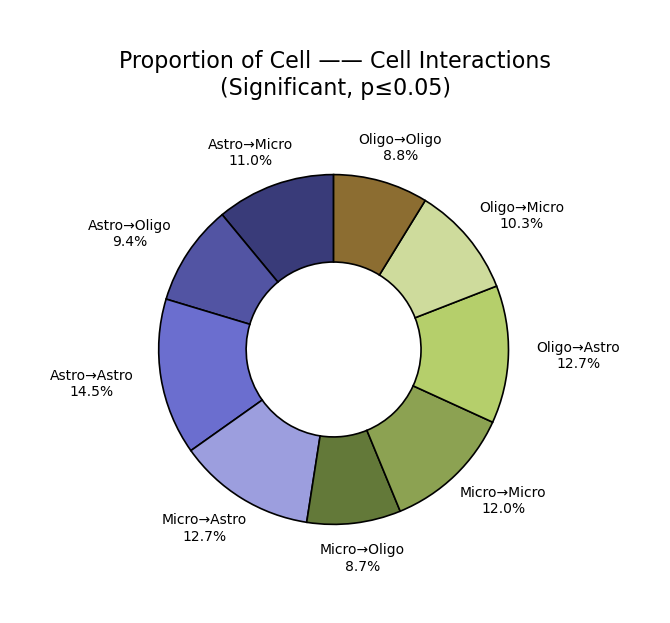

In [29]:
labels = list(pair_counts.keys())     
sizes = list(pair_counts.values())    
total = sum(sizes)
percentages = [f"{(s / total) * 100:.1f}%" for s in sizes]

colors = plt.cm.tab20b.colors[:len(sizes)]

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts = ax.pie(
    sizes,
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.5, 
                    edgecolor='black', 
                    linewidth=1.2
                    )
)

for i, (wedge, label, pct) in enumerate(zip(wedges, labels, percentages)):
    angle = (wedge.theta2 + wedge.theta1) / 2.0
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))

    ax.text(x * 1.4, y * 1.2,
            f"{label}\n{pct}",
            ha='center', va='center', fontsize=10,
            # bbox=dict(boxstyle="round,pad)
    )

fig.suptitle("Proportion of Cell —— Cell Interactions\n(Significant, p≤0.05)",
             fontsize=16,
             y=0.95)

# plt.savefig("/Users/tianmi/Desktop/Plots/Cross_Talk/Summary/CellCell_Interaction_Pro.pdf", dpi=300, bbox_inches='tight')  
plt.tight_layout()
plt.show()


# Extract_liana_interactions

In [29]:
def extract_liana_interactions(adata_liana, source_cell, target_cell, pval_threshold=0.05, verbose=True ):
    if verbose:
            print(f"Filtering {source_cell} ↔ {target_cell} interactions (p ≤ {pval_threshold}) ...")
    pair_liana = adata_liana[
        ((adata_liana['source'] == source_cell) & (adata_liana['target'] == target_cell)) |
        ((adata_liana['source'] == target_cell) & (adata_liana['target'] == source_cell))
    ].copy()
    pair_liana = pair_liana[pair_liana['cellphone_pvals'] <= pval_threshold].copy()
    
    if verbose:
        print(f"          → Found {len(pair_liana):,} significant interactions")

    from_source_to_target = pair_liana[
        (pair_liana['source'] == source_cell) & (pair_liana['target'] == target_cell)
    ].copy()
    from_target_to_source = pair_liana[
        (pair_liana['source'] == target_cell) & (pair_liana['target'] == source_cell)
    ].copy()
    
    if verbose:
        print(f"            {source_cell} → {target_cell}: {len(from_source_to_target):,} interactions")
        print(f"            {target_cell} → {source_cell}: {len(from_target_to_source):,} interactions")

    ligand_stats_src = (from_source_to_target
                        .groupby('ligand_complex')['receptor_complex']
                        .nunique()
                        .reset_index(name='receptor_count'))
    ligand_stats_tgt = (from_target_to_source
                        .groupby('ligand_complex')['receptor_complex']
                        .nunique()
                        .reset_index(name='receptor_count'))

    from_source_to_target = from_source_to_target.merge(ligand_stats_src, on="ligand_complex", how="left")
    from_source_to_target["regulatory_potential"] = (
        from_source_to_target["receptor_count"] * from_source_to_target["lr_logfc"] / 10
        + from_source_to_target["scaled_weight"]
    )
    if verbose:
        print(f"            Computed regulatory_potential for '{source_cell} → {target_cell}'")

    # Merge and compute for target → source
    from_target_to_source = from_target_to_source.merge(ligand_stats_tgt, on="ligand_complex", how="left")
    from_target_to_source["regulatory_potential"] = (
        from_target_to_source["receptor_count"] * from_target_to_source["lr_logfc"] / 10
        + from_target_to_source["scaled_weight"]
    )
    if verbose:
        print(f"            Computed regulatory_potential for '{target_cell} → {source_cell}'")

    return from_source_to_target, from_target_to_source


In [364]:
results_comparisons['comparison'].unique()

array(['5XFAD_LPS_vs_5XFAD_Veh', '5XFAD_LPS_vs_WT_LPS',
       '5XFAD_Veh_vs_WT_Veh', 'WT_LPS_vs_WT_Veh'], dtype=object)

In [365]:
comparison_A = results_comparisons[results_comparisons['comparison'].eq('5XFAD_LPS_vs_5XFAD_Veh')].copy()
comparison_B = results_comparisons[results_comparisons['comparison'].eq('5XFAD_LPS_vs_WT_LPS')].copy()
comparison_C = results_comparisons[results_comparisons['comparison'].eq('5XFAD_Veh_vs_WT_Veh')].copy()
comparison_D = results_comparisons[results_comparisons['comparison'].eq('WT_LPS_vs_WT_Veh')].copy()

In [30]:
comparison_A_M = results_comparisons_M[results_comparisons_M['comparison'].eq('5XFAD_LPS_vs_5XFAD_Veh')].copy()
comparison_B_M = results_comparisons_M[results_comparisons_M['comparison'].eq('5XFAD_LPS_vs_WT_LPS')].copy()
comparison_C_M = results_comparisons_M[results_comparisons_M['comparison'].eq('5XFAD_Veh_vs_WT_Veh')].copy()
comparison_D_M = results_comparisons_M[results_comparisons_M['comparison'].eq('WT_LPS_vs_WT_Veh')].copy()

In [31]:
comparison_A_F = results_comparisons_F[results_comparisons_F['comparison'].eq('5XFAD_LPS_vs_5XFAD_Veh')].copy()
comparison_B_F = results_comparisons_F[results_comparisons_F['comparison'].eq('5XFAD_LPS_vs_WT_LPS')].copy()
comparison_C_F = results_comparisons_F[results_comparisons_F['comparison'].eq('5XFAD_Veh_vs_WT_Veh')].copy()
comparison_D_F = results_comparisons_F[results_comparisons_F['comparison'].eq('WT_LPS_vs_WT_Veh')].copy()

In [376]:
results_comparisons['regulatory_potential'].min()
results_comparisons['regulatory_potential'].max()

np.float64(5.112272541119404)

In [32]:
def _keep_cols(df):
    lig_col = next((c for c in ['ligand_complex','ligand','ligand_gene_symbol'] if c in df.columns), None)
    rec_col = next((c for c in ['receptor_complex','receptor','receptor_gene_symbol'] if c in df.columns), None)
    base = ['comparison','source','target']
    opt = ['cellphone_pvals','lr_logfc','scaled_weight',
           'aggregate_rank','consensus_rank','magnitude_rank','specificity_rank','score_norm', 'receptor_count', 'regulatory_potential']
    cols = base + [c for c in [lig_col, rec_col] if c is not None] + [c for c in opt if c in df.columns]
    return cols


In [ ]:
# ------- A: 5XFAD_LPS_vs_5XFAD_Veh -------
df = comparison_A.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_A = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

# ------- B: 5XFAD_LPS_vs_WT_LPS -------
df = comparison_B.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_B = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

# ------- C: 5XFAD_Veh_vs_WT_Veh -------
df = comparison_C.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_C = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

# ------- D: WT_LPS_vs_WT_Veh -------
df = comparison_D.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_D = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

for name, dct in {'pairs_A':results_A, 'pairs_B':results_B, 'pairs_C':results_C, 'pairs_D':results_D}.items():
    print(name, {k: v.shape for k, v in dct.items()})

pairs_A {'AC_to_MG': (81, 12), 'MG_to_AC': (87, 12), 'OL_to_MG': (90, 12), 'MG_to_OL': (62, 12), 'AC_to_OL': (59, 12), 'OL_to_AC': (98, 12)}
pairs_B {'AC_to_MG': (80, 12), 'MG_to_AC': (90, 12), 'OL_to_MG': (94, 12), 'MG_to_OL': (62, 12), 'AC_to_OL': (59, 12), 'OL_to_AC': (100, 12)}
pairs_C {'AC_to_MG': (73, 12), 'MG_to_AC': (92, 12), 'OL_to_MG': (84, 12), 'MG_to_OL': (55, 12), 'AC_to_OL': (52, 12), 'OL_to_AC': (96, 12)}
pairs_D {'AC_to_MG': (73, 12), 'MG_to_AC': (88, 12), 'OL_to_MG': (91, 12), 'MG_to_OL': (61, 12), 'AC_to_OL': (55, 12), 'OL_to_AC': (96, 12)}


In [33]:
# ------- Male A: 5XFAD_LPS_vs_5XFAD_Veh -------
df = comparison_A_M.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_A_M = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

# ------- B: 5XFAD_LPS_vs_WT_LPS -------
df = comparison_B_M.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_B_M = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

# ------- C: 5XFAD_Veh_vs_WT_Veh -------
df = comparison_C_M.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_C_M = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

# ------- D: WT_LPS_vs_WT_Veh -------
df = comparison_D_M.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_D_M = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

for name, dct in {'pairs_A':results_A_M, 'pairs_B':results_B_M, 'pairs_C':results_C_M, 'pairs_D':results_D_M}.items():
    print(name, {k: v.shape for k, v in dct.items()})

pairs_A {'AC_to_MG': (84, 12), 'MG_to_AC': (89, 12), 'OL_to_MG': (87, 12), 'MG_to_OL': (62, 12), 'AC_to_OL': (59, 12), 'OL_to_AC': (91, 12)}
pairs_B {'AC_to_MG': (82, 12), 'MG_to_AC': (92, 12), 'OL_to_MG': (93, 12), 'MG_to_OL': (65, 12), 'AC_to_OL': (60, 12), 'OL_to_AC': (94, 12)}
pairs_C {'AC_to_MG': (81, 12), 'MG_to_AC': (90, 12), 'OL_to_MG': (86, 12), 'MG_to_OL': (59, 12), 'AC_to_OL': (55, 12), 'OL_to_AC': (96, 12)}
pairs_D {'AC_to_MG': (77, 12), 'MG_to_AC': (93, 12), 'OL_to_MG': (91, 12), 'MG_to_OL': (65, 12), 'AC_to_OL': (55, 12), 'OL_to_AC': (95, 12)}


In [34]:
# ------- Female A: 5XFAD_LPS_vs_5XFAD_Veh -------
df = comparison_A_F.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_A_F = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

# ------- B: 5XFAD_LPS_vs_WT_LPS -------
df = comparison_B_F.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_B_F = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

# ------- C: 5XFAD_Veh_vs_WT_Veh -------
df = comparison_C_F.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_C_F = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

# ------- D: WT_LPS_vs_WT_Veh -------
df = comparison_D_F.copy()
if 'cellphone_pvals' in df.columns:
    df = df[df['cellphone_pvals'] <= 0.05].copy()
kc = _keep_cols(df)
results_D_F = {
    'AC_to_MG': df[(df['source']=='Astrocyte')       & (df['target']=='Microglia')][kc].copy(),
    'MG_to_AC': df[(df['source']=='Microglia')       & (df['target']=='Astrocyte')][kc].copy(),
    'OL_to_MG': df[(df['source']=='Oligodendrocytes') & (df['target']=='Microglia')][kc].copy(),
    'MG_to_OL': df[(df['source']=='Microglia')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'AC_to_OL': df[(df['source']=='Astrocyte')       & (df['target']=='Oligodendrocytes')][kc].copy(),
    'OL_to_AC': df[(df['source']=='Oligodendrocytes')       & (df['target']=='Astrocyte')][kc].copy(),
}

for name, dct in {'pairs_A':results_A_F, 'pairs_B':results_B_F, 'pairs_C':results_C_F, 'pairs_D':results_D_F}.items():
    print(name, {k: v.shape for k, v in dct.items()})

pairs_A {'AC_to_MG': (79, 12), 'MG_to_AC': (85, 12), 'OL_to_MG': (90, 12), 'MG_to_OL': (62, 12), 'AC_to_OL': (57, 12), 'OL_to_AC': (92, 12)}
pairs_B {'AC_to_MG': (79, 12), 'MG_to_AC': (92, 12), 'OL_to_MG': (94, 12), 'MG_to_OL': (64, 12), 'AC_to_OL': (56, 12), 'OL_to_AC': (100, 12)}
pairs_C {'AC_to_MG': (71, 12), 'MG_to_AC': (85, 12), 'OL_to_MG': (84, 12), 'MG_to_OL': (53, 12), 'AC_to_OL': (50, 12), 'OL_to_AC': (89, 12)}
pairs_D {'AC_to_MG': (73, 12), 'MG_to_AC': (86, 12), 'OL_to_MG': (89, 12), 'MG_to_OL': (55, 12), 'AC_to_OL': (51, 12), 'OL_to_AC': (92, 12)}


In [ ]:
all_results = {
    '5XFAD_LPS_vs_5XFAD_Veh': results_A,
    '5XFAD_LPS_vs_WT_LPS': results_B,
    '5XFAD_Veh_vs_WT_Veh': results_C,
    'WT_LPS_vs_WT_Veh': results_D,
}

out_dir = Path("/Users/tianmi/Desktop/Plots/Cross_Talk")
out_dir.mkdir(parents=True, exist_ok=True)

# for comparison, pairs in all_results.items():
#     for pair_name, df_pair in pairs.items():
#         comp_dir = out_dir / comparison / pair_name
#         comp_dir.mkdir(parents=True, exist_ok=True)  
#         fname = f"{pair_name}.csv"
#         df_pair.to_csv(comp_dir / fname, index=False)
print(f"[OK] csvs saved to {out_dir.resolve()}")

[OK] csvs saved to /Users/tianmi/Desktop/Plots/Cross_Talk


In [35]:
all_results_M = {
    '5XFAD_LPS_vs_5XFAD_Veh': results_A_M,
    '5XFAD_LPS_vs_WT_LPS': results_B_M,
    '5XFAD_Veh_vs_WT_Veh': results_C_M,
    'WT_LPS_vs_WT_Veh': results_D_M,
}

out_dir_M = Path("/Users/tianmi/Desktop/Plots/Cross_Talk/Male")
out_dir_M.mkdir(parents=True, exist_ok=True)

# for comparison, pairs in all_results.items():
#     for pair_name, df_pair in pairs.items():
#         comp_dir = out_dir / comparison / pair_name
#         comp_dir.mkdir(parents=True, exist_ok=True)  
#         fname = f"{pair_name}.csv"
#         df_pair.to_csv(comp_dir / fname, index=False)
print(f"[OK] csvs saved to {out_dir_M.resolve()}")

[OK] csvs saved to /Users/tianmi/Desktop/Plots/Cross_Talk/Male


In [36]:
all_results_F = {
    '5XFAD_LPS_vs_5XFAD_Veh': results_A_F,
    '5XFAD_LPS_vs_WT_LPS': results_B_F,
    '5XFAD_Veh_vs_WT_Veh': results_C_F,
    'WT_LPS_vs_WT_Veh': results_D_F,
}

out_dir_F = Path("/Users/tianmi/Desktop/Plots/Cross_Talk/Female")
out_dir_F.mkdir(parents=True, exist_ok=True)

# for comparison, pairs in all_results.items():
#     for pair_name, df_pair in pairs.items():
#         comp_dir = out_dir / comparison / pair_name
#         comp_dir.mkdir(parents=True, exist_ok=True)  
#         fname = f"{pair_name}.csv"
#         df_pair.to_csv(comp_dir / fname, index=False)
print(f"[OK] csvs saved to {out_dir_F.resolve()}")

[OK] csvs saved to /Users/tianmi/Desktop/Plots/Cross_Talk/Female


In [371]:
results_by_pair = {}
for comp, pairs in all_results.items():
    for pair, df_pair in pairs.items():
        results_by_pair.setdefault(pair, {})[comp] = df_pair

# out_dir = Path("/Users/tianmi/Desktop/Plots/Cross_Talk")
# out_dir.mkdir(parents=True, exist_ok=True)

for pair_name, comps in results_by_pair.items():
    for comparison, df_pair in comps.items():
        save_dir = out_dir / pair_name / comparison
        save_dir.mkdir(parents=True, exist_ok=True)
        df_pair.to_csv(save_dir / f"{pair_name}.csv", index=False)

print("[OK] csvs saved to", out_dir.resolve())

for pair_name, comps in results_by_pair.items():
    shapes = {comp: df.shape for comp, df in comps.items()}
    print(pair_name, shapes)

[OK] csvs saved to /Users/tianmi/Desktop/Plots/Cross_Talk
AC_to_MG {'5XFAD_LPS_vs_5XFAD_Veh': (81, 12), '5XFAD_LPS_vs_WT_LPS': (80, 12), '5XFAD_Veh_vs_WT_Veh': (73, 12), 'WT_LPS_vs_WT_Veh': (73, 12)}
MG_to_AC {'5XFAD_LPS_vs_5XFAD_Veh': (87, 12), '5XFAD_LPS_vs_WT_LPS': (90, 12), '5XFAD_Veh_vs_WT_Veh': (92, 12), 'WT_LPS_vs_WT_Veh': (88, 12)}
OL_to_MG {'5XFAD_LPS_vs_5XFAD_Veh': (90, 12), '5XFAD_LPS_vs_WT_LPS': (94, 12), '5XFAD_Veh_vs_WT_Veh': (84, 12), 'WT_LPS_vs_WT_Veh': (91, 12)}
MG_to_OL {'5XFAD_LPS_vs_5XFAD_Veh': (62, 12), '5XFAD_LPS_vs_WT_LPS': (62, 12), '5XFAD_Veh_vs_WT_Veh': (55, 12), 'WT_LPS_vs_WT_Veh': (61, 12)}
AC_to_OL {'5XFAD_LPS_vs_5XFAD_Veh': (59, 12), '5XFAD_LPS_vs_WT_LPS': (59, 12), '5XFAD_Veh_vs_WT_Veh': (52, 12), 'WT_LPS_vs_WT_Veh': (55, 12)}
OL_to_AC {'5XFAD_LPS_vs_5XFAD_Veh': (98, 12), '5XFAD_LPS_vs_WT_LPS': (100, 12), '5XFAD_Veh_vs_WT_Veh': (96, 12), 'WT_LPS_vs_WT_Veh': (96, 12)}


In [37]:
results_by_male = {}
for comp, pairs in all_results_M.items():
    for pair, df_pair in pairs.items():
        results_by_male.setdefault(pair, {})[comp] = df_pair

# out_dir = Path("/Users/tianmi/Desktop/Plots/Cross_Talk")
# out_dir.mkdir(parents=True, exist_ok=True)

for pair_name, comps in results_by_male.items():
    for comparison, df_pair in comps.items():
        save_dir_M = out_dir_M / pair_name / comparison
        # save_dir_M.mkdir(parents=True, exist_ok=True)
        # df_pair.to_csv(save_dir_M / f"{pair_name}.csv", index=False)

print("[OK] csvs saved to", save_dir_M.resolve())

for pair_name, comps in results_by_male.items():
    shapes = {comp: df.shape for comp, df in comps.items()}
    print(pair_name, shapes)

[OK] csvs saved to /Users/tianmi/Desktop/Plots/Cross_Talk/Male/OL_to_AC/WT_LPS_vs_WT_Veh
AC_to_MG {'5XFAD_LPS_vs_5XFAD_Veh': (84, 12), '5XFAD_LPS_vs_WT_LPS': (82, 12), '5XFAD_Veh_vs_WT_Veh': (81, 12), 'WT_LPS_vs_WT_Veh': (77, 12)}
MG_to_AC {'5XFAD_LPS_vs_5XFAD_Veh': (89, 12), '5XFAD_LPS_vs_WT_LPS': (92, 12), '5XFAD_Veh_vs_WT_Veh': (90, 12), 'WT_LPS_vs_WT_Veh': (93, 12)}
OL_to_MG {'5XFAD_LPS_vs_5XFAD_Veh': (87, 12), '5XFAD_LPS_vs_WT_LPS': (93, 12), '5XFAD_Veh_vs_WT_Veh': (86, 12), 'WT_LPS_vs_WT_Veh': (91, 12)}
MG_to_OL {'5XFAD_LPS_vs_5XFAD_Veh': (62, 12), '5XFAD_LPS_vs_WT_LPS': (65, 12), '5XFAD_Veh_vs_WT_Veh': (59, 12), 'WT_LPS_vs_WT_Veh': (65, 12)}
AC_to_OL {'5XFAD_LPS_vs_5XFAD_Veh': (59, 12), '5XFAD_LPS_vs_WT_LPS': (60, 12), '5XFAD_Veh_vs_WT_Veh': (55, 12), 'WT_LPS_vs_WT_Veh': (55, 12)}
OL_to_AC {'5XFAD_LPS_vs_5XFAD_Veh': (91, 12), '5XFAD_LPS_vs_WT_LPS': (94, 12), '5XFAD_Veh_vs_WT_Veh': (96, 12), 'WT_LPS_vs_WT_Veh': (95, 12)}


In [38]:
results_by_female = {}
for comp, pairs in all_results_F.items():
    for pair, df_pair in pairs.items():
        results_by_female.setdefault(pair, {})[comp] = df_pair

# out_dir = Path("/Users/tianmi/Desktop/Plots/Cross_Talk")
# out_dir.mkdir(parents=True, exist_ok=True)

for pair_name, comps in results_by_female.items():
    for comparison, df_pair in comps.items():
        save_dir_F = out_dir_F / pair_name / comparison
        # save_dir_F.mkdir(parents=True, exist_ok=True)
        # df_pair.to_csv(save_dir_F / f"{pair_name}.csv", index=False)

print("[OK] csvs saved to", save_dir_F.resolve())

for pair_name, comps in results_by_female.items():
    shapes = {comp: df.shape for comp, df in comps.items()}
    print(pair_name, shapes)

[OK] csvs saved to /Users/tianmi/Desktop/Plots/Cross_Talk/Female/OL_to_AC/WT_LPS_vs_WT_Veh
AC_to_MG {'5XFAD_LPS_vs_5XFAD_Veh': (79, 12), '5XFAD_LPS_vs_WT_LPS': (79, 12), '5XFAD_Veh_vs_WT_Veh': (71, 12), 'WT_LPS_vs_WT_Veh': (73, 12)}
MG_to_AC {'5XFAD_LPS_vs_5XFAD_Veh': (85, 12), '5XFAD_LPS_vs_WT_LPS': (92, 12), '5XFAD_Veh_vs_WT_Veh': (85, 12), 'WT_LPS_vs_WT_Veh': (86, 12)}
OL_to_MG {'5XFAD_LPS_vs_5XFAD_Veh': (90, 12), '5XFAD_LPS_vs_WT_LPS': (94, 12), '5XFAD_Veh_vs_WT_Veh': (84, 12), 'WT_LPS_vs_WT_Veh': (89, 12)}
MG_to_OL {'5XFAD_LPS_vs_5XFAD_Veh': (62, 12), '5XFAD_LPS_vs_WT_LPS': (64, 12), '5XFAD_Veh_vs_WT_Veh': (53, 12), 'WT_LPS_vs_WT_Veh': (55, 12)}
AC_to_OL {'5XFAD_LPS_vs_5XFAD_Veh': (57, 12), '5XFAD_LPS_vs_WT_LPS': (56, 12), '5XFAD_Veh_vs_WT_Veh': (50, 12), 'WT_LPS_vs_WT_Veh': (51, 12)}
OL_to_AC {'5XFAD_LPS_vs_5XFAD_Veh': (92, 12), '5XFAD_LPS_vs_WT_LPS': (100, 12), '5XFAD_Veh_vs_WT_Veh': (89, 12), 'WT_LPS_vs_WT_Veh': (92, 12)}


In [39]:
conditions_order = ['WT_Veh','WT_LPS','5XFAD_Veh','5XFAD_LPS']
conditions_order_gts = ['WT_Veh_M', 'WT_LPS_M', '5XFAD_Veh_M', '5XFAD_LPS_M',
                        'WT_Veh_F', 'WT_LPS_F', '5XFAD_Veh_F', '5XFAD_LPS_F'
        ]

In [40]:
def extract_per_condition(
    liana_df,                      
    cond_col='geno_treat',         # 'geno_treat_sex'
    celltype_compare_pairs=None,
    celltype_abbr=None,
    pval_threshold=0.05,
    save=True,
    save_dir_base="/Users/tianmi/Desktop/Plots/Cross_Talk",
    folder_mode='by_pair', 
    verbose=True
):
    if celltype_compare_pairs is None:
        celltype_compare_pairs = [
            ('Astrocyte','Microglia'),
            ('Astrocyte','Oligodendrocytes'),
            ('Microglia','Oligodendrocytes'),
            ('Microglia','Astrocyte'),
        ]
    if celltype_abbr is None:
        celltype_abbr = {'Astrocyte':'AC','Microglia':'MG','Oligodendrocytes':'OL'}

    results = {}  
    all_conds = liana_df[cond_col].dropna().unique().tolist()

    for source, target in celltype_compare_pairs:
        src_ab, tgt_ab = celltype_abbr[source], celltype_abbr[target]
        pair_key_fwd = f"{src_ab}_to_{tgt_ab}"
        pair_key_rev = f"{tgt_ab}_to_{src_ab}"
        
        if verbose:
            print(f"\n===== Pair: {source} -> {target} =====")

        for cond in conditions_order:
            df_cond = liana_df[liana_df[cond_col] == cond].copy()

            s2t, t2s = extract_liana_interactions(
                df_cond,
                source_cell=source,
                target_cell=target,
                pval_threshold=pval_threshold,
                verbose=verbose
            )
            s2t[cond_col] = cond
            t2s[cond_col] = cond

            # key1 = (cond, f"{src_ab}_to_{tgt_ab}")
            # key2 = (cond, f"{tgt_ab}_to_{src_ab}")
            # results[key1] = s2t
            # results[key2] = t2s
            results.setdefault(pair_key_fwd, {})[cond] = s2t
            results.setdefault(pair_key_rev, {})[cond] = t2s

            if not save:
                continue

            if folder_mode == 'by_pair':
                # <base>/<pair>/<cond>/<cond>_<pair>.csv
                dir1 = os.path.join(save_dir_base, f"{src_ab}_to_{tgt_ab}", cond)
                dir2 = os.path.join(save_dir_base, f"{tgt_ab}_to_{src_ab}", cond)
            else:  # 'by_condition'
                # <base>/<cond>/<pair>/<cond>_<pair>.csv
                dir1 = os.path.join(save_dir_base, cond, f"{src_ab}_to_{tgt_ab}")
                dir2 = os.path.join(save_dir_base, cond, f"{tgt_ab}_to_{src_ab}")

            os.makedirs(dir1, exist_ok=True)
            os.makedirs(dir2, exist_ok=True)

            file1 = os.path.join(dir1, f"{src_ab}_to_{tgt_ab}.csv")
            file2 = os.path.join(dir2, f"{tgt_ab}_to_{src_ab}.csv")

            if not s2t.empty:
                s2t.to_csv(file1, index=False)
                if verbose: print(f"Saved: {file1}")
            if not t2s.empty:
                t2s.to_csv(file2, index=False)
                if verbose: print(f"Saved: {file2}")

    return results


## extract on geno_treat

In [143]:
results_by_gt = extract_per_condition(
    liana_df=res,          
    cond_col='geno_treat',         
    pval_threshold=0.05,
    save=True,
    save_dir_base="/Users/tianmi/Desktop/Plots/Cross_Talk/Geno_Treat",
    folder_mode='by_pair', 
    verbose=True
)


===== Pair: Astrocyte -> Microglia =====
Filtering Astrocyte ↔ Microglia interactions (p ≤ 0.05) ...
          → Found 151 significant interactions
            Astrocyte → Microglia: 71 interactions
            Microglia → Astrocyte: 80 interactions
            Computed regulatory_potential for 'Astrocyte → Microglia'
            Computed regulatory_potential for 'Microglia → Astrocyte'
Saved: /Users/tianmi/Desktop/Plots/Cross_Talk/Geno_Treat/AC_to_MG/WT_Veh/AC_to_MG.csv
Saved: /Users/tianmi/Desktop/Plots/Cross_Talk/Geno_Treat/MG_to_AC/WT_Veh/MG_to_AC.csv
Filtering Astrocyte ↔ Microglia interactions (p ≤ 0.05) ...
          → Found 170 significant interactions
            Astrocyte → Microglia: 80 interactions
            Microglia → Astrocyte: 90 interactions
            Computed regulatory_potential for 'Astrocyte → Microglia'
            Computed regulatory_potential for 'Microglia → Astrocyte'
Saved: /Users/tianmi/Desktop/Plots/Cross_Talk/Geno_Treat/AC_to_MG/WT_LPS/AC_to_MG.csv
Sa

In [131]:
rows = []
for pair, cond_map in results_by_gt.items():
    for cond, df in cond_map.items():
        if df is None or df.empty:
            n_rows = 0
            n_lr   = 0
        else:
            n_rows = len(df)
            if {'ligand_complex','receptor_complex'}.issubset(df.columns):
                n_lr = df[['ligand_complex','receptor_complex']].drop_duplicates().shape[0]
            else:
                n_lr = 0
        rows.append({'pair': pair, 'geno_treat': cond, 'n_rows': n_rows, 'n_lr_pairs': n_lr})

summary = pd.DataFrame(rows).sort_values(['pair','geno_treat'])
print(summary.head(20))

        pair geno_treat  n_rows  n_lr_pairs
3   AC_to_MG  5XFAD_LPS      78          78
2   AC_to_MG  5XFAD_Veh      80          80
1   AC_to_MG     WT_LPS      80          80
0   AC_to_MG     WT_Veh      71          71
11  AC_to_OL  5XFAD_LPS      59          59
10  AC_to_OL  5XFAD_Veh      59          59
9   AC_to_OL     WT_LPS      57          57
8   AC_to_OL     WT_Veh      48          48
7   MG_to_AC  5XFAD_LPS      88          88
6   MG_to_AC  5XFAD_Veh      88          88
5   MG_to_AC     WT_LPS      90          90
4   MG_to_AC     WT_Veh      80          80
19  MG_to_OL  5XFAD_LPS      63          63
18  MG_to_OL  5XFAD_Veh      60          60
17  MG_to_OL     WT_LPS      63          63
16  MG_to_OL     WT_Veh      52          52
15  OL_to_AC  5XFAD_LPS      94          94
14  OL_to_AC  5XFAD_Veh      97          97
13  OL_to_AC     WT_LPS     102         102
12  OL_to_AC     WT_Veh      88          88


In [159]:
compare = "MG_to_AC"   

pair_map = results_by_gt.get(compare, {})
if not pair_map:
    print(f"No pair = {compare} found")
else:
    for cond, df in pair_map.items():
        if df is None or df.empty:
            print(f"\n=== {cond} ===\n")
        else:
            print(f"\n=== {cond} ===")
            display(df.head(20))       



=== WT_Veh ===


,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,geno_treat,receptor_count,regulatory_potential
0,Microglia,Astrocyte,Psap,Gpr37l1,2.293823,0.0,5.091984,0.793164,2.328395,0.436820,0.947019,0.078927,0.003029,WT_Veh,4,1.724522
1,Microglia,Astrocyte,C1qb,Lrp1,2.319037,0.0,2.952518,0.853424,2.980177,0.403853,0.931558,0.040644,0.009342,WT_Veh,2,1.449459
2,Microglia,Astrocyte,Gnai2,S1pr1,1.984014,0.0,3.933553,0.807755,2.362052,0.475545,0.940157,0.063211,0.019887,WT_Veh,4,1.752576
3,Microglia,Astrocyte,Psap,Lrp1,1.733680,0.0,2.060829,0.443162,0.888889,0.196613,0.919168,0.388038,0.044010,WT_Veh,4,0.798718
4,Microglia,Astrocyte,Hsp90b1,Lrp1,1.529456,0.0,1.749729,0.376657,0.788694,0.191431,0.912877,0.441977,0.096538,WT_Veh,1,0.455526
5,Microglia,Astrocyte,Gnai2,Ednrb,1.364035,0.0,1.538592,0.643413,1.563037,0.474080,0.907625,0.094872,0.150784,WT_Veh,4,1.268627
6,Microglia,Astrocyte,Pdgfb,S1pr1,1.317111,0.0,1.217195,0.864352,2.484211,0.921043,0.897322,0.001006,0.181876,WT_Veh,4,1.858036
7,Microglia,Astrocyte,Hsp90aa1,Fgfr3,1.214338,0.0,1.395124,0.302644,0.832732,0.228621,0.903439,0.244615,0.242975,WT_Veh,1,0.385917
8,Microglia,Astrocyte,Calr,Lrp1,1.203639,0.0,1.253404,0.382776,0.815784,0.212765,0.898665,0.333766,0.257243,WT_Veh,2,0.545933
9,Microglia,Astrocyte,Adam10,Nrcam,1.178923,0.0,1.357800,0.696251,1.893818,0.552117,0.902250,0.028948,0.274812,WT_Veh,6,1.832542



=== WT_LPS ===


,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,geno_treat,receptor_count,regulatory_potential
0,Microglia,Astrocyte,Psap,Gpr37l1,2.326084,0.0,5.354274,0.786380,2.330231,0.417240,0.944913,0.093053,0.003657,WT_LPS,4,1.718472
1,Microglia,Astrocyte,C1qb,Lrp1,2.303492,0.0,3.142632,0.855021,2.921267,0.391385,0.929285,0.059725,0.008172,WT_LPS,2,1.439274
2,Microglia,Astrocyte,Gnai2,S1pr1,2.058719,0.0,4.234674,0.806696,2.334983,0.443550,0.938479,0.081912,0.013162,WT_LPS,4,1.740690
3,Microglia,Astrocyte,Psap,Lrp1,1.698093,0.0,2.134488,0.404216,0.725519,0.179176,0.915471,0.425310,0.057348,WT_LPS,4,0.694423
4,Microglia,Astrocyte,Hsp90b1,Lrp1,1.551229,0.0,1.889922,0.369045,0.705187,0.178481,0.910641,0.433615,0.091004,WT_LPS,1,0.439563
5,Microglia,Astrocyte,Gnai2,Ednrb,1.519426,0.0,2.079340,0.682903,1.694952,0.453605,0.914452,0.093053,0.100524,WT_LPS,4,1.360884
6,Microglia,Astrocyte,Igfbp4,Lrp6,0.163453,0.0,0.025982,0.159271,0.203737,0.261079,0.544396,0.513951,0.130890,WT_LPS,1,0.179645
7,Microglia,Astrocyte,Pdgfb,S1pr1,1.327885,0.0,1.137187,0.886018,2.402508,0.932417,0.887704,0.001109,0.183098,WT_LPS,4,1.847022
8,Microglia,Astrocyte,Adam10,Nrcam,1.313467,0.0,1.700897,0.784205,1.975779,0.564958,0.906260,0.024010,0.189510,WT_LPS,8,2.364829
9,Microglia,Astrocyte,Efnb1,Epha4,0.177872,0.0,0.030032,0.199456,0.323429,0.347375,0.562294,0.332380,0.218633,WT_LPS,1,0.231799



=== 5XFAD_Veh ===


,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,geno_treat,receptor_count,regulatory_potential
0,Microglia,Astrocyte,Psap,Gpr37l1,2.327569,0.000,5.357343,0.850537,2.324785,0.410825,0.944317,0.029389,0.002857,5XFAD_Veh,4,1.780452
1,Microglia,Astrocyte,C1qb,Lrp1,2.351397,0.000,3.262502,0.626207,2.804657,0.403510,0.929746,0.086166,0.007548,5XFAD_Veh,2,1.187138
2,Microglia,Astrocyte,Gnai2,S1pr1,2.014824,0.000,4.035735,0.862584,2.335269,0.450653,0.936383,0.026445,0.016459,5XFAD_Veh,4,1.796692
3,Microglia,Astrocyte,Psap,Lrp1,1.709442,0.000,2.176463,0.310446,0.638009,0.184283,0.915320,0.418896,0.048684,5XFAD_Veh,4,0.565650
4,Microglia,Astrocyte,Hsp90b1,Lrp1,1.604291,0.000,1.998570,0.281712,0.622963,0.184833,0.911957,0.413366,0.080969,5XFAD_Veh,1,0.344009
5,Microglia,Astrocyte,Gnai2,Ednrb,1.386020,0.000,1.695808,0.679884,1.575317,0.456768,0.905135,0.086166,0.145124,5XFAD_Veh,4,1.310010
6,Microglia,Astrocyte,Pdgfb,S1pr1,1.347396,0.000,1.140395,0.884155,2.442339,0.935941,0.886677,0.000391,0.167371,5XFAD_Veh,4,1.861090
7,Microglia,Astrocyte,Calr,Lrp1,1.295105,0.000,1.475500,0.277363,0.642406,0.200201,0.898990,0.339173,0.197679,5XFAD_Veh,2,0.405844
8,Microglia,Astrocyte,Adam10,Nrcam,1.261251,0.000,1.577530,0.803394,1.945369,0.575820,0.901985,0.025621,0.211333,5XFAD_Veh,8,2.359689
9,Microglia,Astrocyte,Adam10,Cadm1,1.253323,0.000,1.559355,0.663471,1.611975,0.400534,0.901472,0.086166,0.215971,5XFAD_Veh,8,1.953050



=== 5XFAD_LPS ===


,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,geno_treat,receptor_count,regulatory_potential
0,Microglia,Astrocyte,Psap,Gpr37l1,2.275364,0.000,5.122384,0.862727,2.294151,0.424111,0.942358,0.029122,0.004276,5XFAD_LPS,4,1.780388
1,Microglia,Astrocyte,C1qb,Lrp1,2.315013,0.000,2.991703,0.626250,2.943823,0.400506,0.925893,0.086062,0.008039,5XFAD_LPS,2,1.215014
2,Microglia,Astrocyte,Gnai2,S1pr1,1.979393,0.000,3.895111,0.831348,2.275515,0.436007,0.934452,0.036837,0.017548,5XFAD_LPS,4,1.741554
3,Microglia,Astrocyte,Psap,Lrp1,1.642995,0.000,1.948303,0.308036,0.628622,0.179769,0.909768,0.422213,0.072116,5XFAD_LPS,4,0.559485
4,Microglia,Astrocyte,Hsp90b1,Lrp1,1.632601,0.000,1.932165,0.299741,0.659938,0.181431,0.909426,0.403554,0.073503,5XFAD_LPS,1,0.365735
5,Microglia,Astrocyte,Gnai2,Ednrb,1.438303,0.000,1.916757,0.697430,1.596414,0.440955,0.909095,0.086062,0.131394,5XFAD_LPS,4,1.335995
6,Microglia,Astrocyte,Adam10,Nrcam,1.347908,0.000,1.795291,0.833761,2.010143,0.574299,0.906354,0.023440,0.182355,5XFAD_LPS,8,2.441875
7,Microglia,Astrocyte,Pdgfb,S1pr1,1.331840,0.000,1.135675,0.882840,2.406743,0.936884,0.885028,0.000430,0.188703,5XFAD_LPS,4,1.845537
8,Microglia,Astrocyte,Efnb1,Epha4,0.176522,0.000,0.029879,0.221643,0.369915,0.391958,0.555280,0.265920,0.209037,5XFAD_LPS,2,0.295626
9,Microglia,Astrocyte,Calr,Lrp1,1.290337,0.000,1.400755,0.304400,0.704702,0.203015,0.895278,0.328249,0.212779,5XFAD_LPS,2,0.445340


## extract on geno_treat_sex

In [41]:
def extract_per_condition_gts(
    liana_df,                      
    cond_col='geno_treat_sex',          # 形如: WT_Veh_M / WT_Veh_F
    celltype_compare_pairs=None,
    celltype_abbr=None,
    pval_threshold=0.05,
    save=True,
    save_dir_base="/Users/tianmi/Desktop/Plots/Cross_Talk",
    folder_mode='by_pair',              # 'by_pair' 或 'by_condition'
    conditions_order_gts=None,          # ← 新增: 8 个条件的顺序
    verbose=True
):
    if celltype_compare_pairs is None:
        celltype_compare_pairs = [
            ('Astrocyte','Microglia'),
            ('Astrocyte','Oligodendrocytes'),
            ('Microglia','Oligodendrocytes'),
            ('Microglia','Astrocyte'),
        ]
    if celltype_abbr is None:
        celltype_abbr = {'Astrocyte':'AC','Microglia':'MG','Oligodendrocytes':'OL'}

    default_gts = [
        'WT_Veh_M', 'WT_LPS_M', '5XFAD_Veh_M', '5XFAD_LPS_M',
        'WT_Veh_F', 'WT_LPS_F', '5XFAD_Veh_F', '5XFAD_LPS_F'
    ]
    if conditions_order_gts is None:
        conditions_order_gts = default_gts

    all_conds_in_data = set(liana_df[cond_col].dropna().unique().tolist())
    loop_conds = [c for c in conditions_order_gts if c in all_conds_in_data]
    if verbose:
        missing = [c for c in conditions_order_gts if c not in all_conds_in_data]
        print(f"[INFO] cond_col = '{cond_col}'")
        print(f"[INFO] loop_conds = {loop_conds}")
        if missing:
            print(f"[WARN] missing conditions (skipped): {missing}")

    conds_by_sex = {
        'M': [c for c in loop_conds if isinstance(c, str) and c.endswith('_M')],
        'F': [c for c in loop_conds if isinstance(c, str) and c.endswith('_F')],
    }
    sex_label = {'M': 'Male', 'F': 'Female'}

    results_by_sex = {'M': {}, 'F': {}}

    for sex in ['M', 'F']:
        if verbose:
            print(f"\n====== Sex: {sex_label[sex]} ======")
        sex_results = {}

        for source, target in celltype_compare_pairs:
            src_ab, tgt_ab = celltype_abbr[source], celltype_abbr[target]
            pair_key_fwd = f"{src_ab}_to_{tgt_ab}"
            pair_key_rev = f"{tgt_ab}_to_{src_ab}"

            if verbose:
                print(f"\n--- Pair: {source} -> {target} ---")

            for cond in conds_by_sex[sex]:
                df_cond = liana_df[liana_df[cond_col] == cond].copy()
                if df_cond.empty:
                    if verbose: print(f"  - {cond}: no rows, skip.")
                    continue

                s2t, t2s = extract_liana_interactions(
                    df_cond,
                    source_cell=source,
                    target_cell=target,
                    pval_threshold=pval_threshold,
                    verbose=verbose
                )
                s2t[cond_col] = cond
                t2s[cond_col] = cond

                sex_results.setdefault(pair_key_fwd, {})[cond] = s2t
                sex_results.setdefault(pair_key_rev, {})[cond] = t2s

                if not save:
                    continue

                if folder_mode == 'by_pair':
                    # <base>/<Male|Female>/<pair>/<cond>/<pair>.csv
                    dir1 = os.path.join(save_dir_base, sex_label[sex], f"{src_ab}_to_{tgt_ab}", cond)
                    dir2 = os.path.join(save_dir_base, sex_label[sex], f"{tgt_ab}_to_{src_ab}", cond)
                else:  # 'by_condition'
                    # <base>/<Male|Female>/<cond>/<pair>/<pair>.csv
                    dir1 = os.path.join(save_dir_base, sex_label[sex], cond, f"{src_ab}_to_{tgt_ab}")
                    dir2 = os.path.join(save_dir_base, sex_label[sex], cond, f"{tgt_ab}_to_{src_ab}")

                os.makedirs(dir1, exist_ok=True)
                os.makedirs(dir2, exist_ok=True)

                file1 = os.path.join(dir1, f"{src_ab}_to_{tgt_ab}.csv")
                file2 = os.path.join(dir2, f"{tgt_ab}_to_{src_ab}.csv")

                if not s2t.empty:
                    s2t.to_csv(file1, index=False)
                    if verbose: print(f"Saved: {file1}")
                if not t2s.empty:
                    t2s.to_csv(file2, index=False)
                    if verbose: print(f"Saved: {file2}")

        results_by_sex[sex] = sex_results

    return results_by_sex

In [204]:
results_by_gts = extract_per_condition_gts(
    liana_df=gts_results,          
    cond_col='geno_treat_sex',         
    pval_threshold=0.05,
    save=True,
    save_dir_base="/Users/tianmi/Desktop/Plots/Cross_Talk/Geno_Treat_Sex",
    folder_mode='by_pair', 
    verbose=True
)

[INFO] cond_col = 'geno_treat_sex'
[INFO] loop_conds = ['WT_Veh_M', 'WT_LPS_M', '5XFAD_Veh_M', '5XFAD_LPS_M', 'WT_Veh_F', 'WT_LPS_F', '5XFAD_Veh_F', '5XFAD_LPS_F']

====== Sex: Male ======

--- Pair: Astrocyte -> Microglia ---
Filtering Astrocyte ↔ Microglia interactions (p ≤ 0.05) ...
          → Found 154 significant interactions
            Astrocyte → Microglia: 68 interactions
            Microglia → Astrocyte: 86 interactions
            Computed regulatory_potential for 'Astrocyte → Microglia'
            Computed regulatory_potential for 'Microglia → Astrocyte'
Saved: /Users/tianmi/Desktop/Plots/Cross_Talk/Geno_Treat_Sex/Male/AC_to_MG/WT_Veh_M/AC_to_MG.csv
Saved: /Users/tianmi/Desktop/Plots/Cross_Talk/Geno_Treat_Sex/Male/MG_to_AC/WT_Veh_M/MG_to_AC.csv
Filtering Astrocyte ↔ Microglia interactions (p ≤ 0.05) ...
          → Found 176 significant interactions
            Astrocyte → Microglia: 83 interactions
            Microglia → Astrocyte: 93 interactions
            Computed 

# Tool Functions

In [42]:
# read  ligand and receptor genelist file and return a set of gene names
def load_ligands_receptors(path: Path) -> set[str]: 
    return set(pd.read_csv(path, header=None).iloc[:, 0])

In [43]:
# extract ligands and receptors from LIANA results
def load_liana_pairs(df: pd.DataFrame, column: str) -> set[str]:
    return set(df[column].unique())

In [37]:
def find_ligand_overlap_across_conditions(
                        liana_df,
                        ligand_dict,
                        receptor_dict,
                        source_cell,
                        target_cell,
                        pval_threshold=0.05,
                        filter_on="ligand",  # or "both"
                        save_path=None,
                        verbose=True
):
    df_filtered = liana_df[
        (liana_df["source"] == source_cell) & (liana_df["target"] == target_cell)
    ].copy()
    df_filtered = df_filtered[df_filtered["cellphone_pvals"] <= pval_threshold]

    all_records = []

    if verbose:
            print(f"Interactions between {source_cell}->{target_cell}:")

    for condition, ligand_set in ligand_dict.get(source_cell, {}).items():
        liana_ligands = set(df_filtered["ligand_complex"])
        liana_receptors = set(df_filtered["receptor_complex"])
        actual_receptors = receptor_dict.get(target_cell, set())

        shared_ligands = ligand_set & liana_ligands
        shared_receptors = actual_receptors & liana_receptors

        if verbose:
            print(f"Condition: {condition}")
            print(f"   → Shared ligands: {len(shared_ligands)}")
        if shared_ligands:
            print(f"   → Ligand genes: {', '.join(sorted(shared_ligands))}")
        else:
            print("   → No overlapping ligands.")

        if filter_on == "ligand":
            temp = df_filtered[df_filtered["ligand_complex"].isin(shared_ligands)].copy()
        elif filter_on == "receptor":
            temp = df_filtered[df_filtered["receptor_complex"].isin(shared_receptors)].copy()
        elif filter_on == "both":
            temp = df_filtered[
                df_filtered["ligand_complex"].isin(shared_ligands) &
                df_filtered["receptor_complex"].isin(shared_receptors)
            ].copy()
        else:
            raise ValueError("filter_on must be 'ligand', 'receptor', or 'both'")
        
        temp["ligand_condition"] = condition  # note the source condition
        all_records.append(temp)

    print(f"Shared receptors in {target_cell} between {source_cell}->{target_cell}: {len(shared_receptors)}")
    print(f"   {sorted(shared_receptors)}")
    
    if all_records:
        result_df = pd.concat(all_records, ignore_index=True)
    else:
        result_df = pd.DataFrame()

    if save_path:
        result_df.to_csv(save_path, index=False)
        if verbose:
            print(f"Filtered LIANA result saved to: {save_path}")

    if verbose:
        print(f"\nTotal interactions across all conditions: {len(result_df)}")
        print(f"\n")

    return result_df

In [44]:
def find_ligand_overlap_by_condition(
    liana_df,
    ligand_dict,             
    receptor_dict,           
    source_cell,
    target_cell,
    cond_col='comparison',   # 'geno_treat_sex'
    conditions=None,         
    pval_threshold=0.05,
    filter_on='both',        # 'ligand' / 'receptor' / 'both'
    save_path=None,          
    verbose=True
):
    # keep specific compare key and filter them
    df_filtered = liana_df[
        (liana_df["source"] == source_cell) & (liana_df["target"] == target_cell)
    ].copy()

    if "cellphone_pvals" in df_filtered.columns:
        df_filtered = df_filtered[df_filtered["cellphone_pvals"] <= pval_threshold].copy()

    lig_col = "ligand_complex" if "ligand_complex" in df_filtered.columns else ("ligand" if "ligand" in df_filtered.columns else None)
    rec_col = "receptor_complex" if "receptor_complex" in df_filtered.columns else ("receptor" if "receptor" in df_filtered.columns else None)

    # check conditions first
    if conditions is None:
        conditions = df_filtered[cond_col].dropna().unique().tolist()

    # merge ligands across conditions
    src_map = ligand_dict.get(source_cell, {}) or {}
    tgt_map = receptor_dict.get(target_cell, {}) or {}
    vals = [set(v) for v in src_map.values()]           
    merged_ligand_set = set().union(*vals) if vals else set() 
    # print(f"merged_ligand_set': {len(merged_ligand_set)}")

    all_records = []
    per_cond_summary = {}

    if verbose:
        print(f"Interactions between {source_cell}->{target_cell}:")
        print(f"  conditions: {conditions}")

    # iterative each condition to find overlapping genes and filter
    for condition in conditions:
        dfc = df_filtered[df_filtered[cond_col] == condition].copy()
        if dfc.empty:
            if verbose: print(f"  - {condition}: no rows after filtering.")
            continue
        
        # extract ligands and receptors from LIANA results of each condition
        liana_ligands = set(map(str, dfc[lig_col].dropna().unique()))
        liana_receptors = set(map(str, dfc[rec_col].dropna().unique()))

        # extract ligands and receptors from prepared dict based on specific celltype and condition
        ligand_sep   = set(src_map.get(condition, []))
        receptor_sep = set(tgt_map.get(condition, []))

        # find overlapping 
        shared_ligands_sep   = ligand_sep & liana_ligands
        shared_receptors_sep = receptor_sep & liana_receptors
        # shared_ligands_merged = merged_ligand_set & liana_ligands
        # print(f"n_shared_ligands_merged': {len(shared_ligands_merged)}")

        per_cond_summary[condition] = {
            'n_shared_ligands_seperate': len(shared_ligands_sep),
            'n_shared_receptors_seperate': len(shared_receptors_sep),
            # 'n_shared_ligands_merged': len(shared_ligands_merged),
            'shared_ligands_seperate': sorted(shared_ligands_sep),
            # 'shared_ligands_merged': sorted(shared_ligands_merged),
            # 'shared_receptors': sorted(shared_receptors_sep),
        }

        if verbose:
            print(f"  - {condition}: shared ligands={len(shared_ligands_sep)}, shared receptors={len(shared_receptors_sep)}")
            print(f"  - {condition}: shared ligands : {shared_ligands_sep}")

        # ---- filter based on merged ligands set
        if filter_on == "ligand":
            kept = dfc[dfc[lig_col].isin(shared_ligands_sep)].copy()
        elif filter_on == "receptor":
            kept = dfc[dfc[rec_col].isin(shared_receptors_sep)].copy()
        elif filter_on == "both":
            kept = dfc[
                dfc[lig_col].isin(shared_ligands_sep) &
                dfc[rec_col].isin(shared_receptors_sep)
            ].copy()
        else:
            raise ValueError("filter_on must be 'ligand', 'receptor', or 'both'")

        kept[cond_col] = condition
        display(kept.head())
        all_records.append(kept)

    result_df = pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame(columns=df_filtered.columns)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        result_df.to_csv(save_path, index=False)
        if verbose:
            print(f"Saved to: {save_path}")

    return result_df, per_cond_summary

In [ ]:
all_results = {
    '5XFAD_LPS_vs_5XFAD_Veh': results_A,
    '5XFAD_LPS_vs_WT_LPS': results_B,
    '5XFAD_Veh_vs_WT_Veh': results_C,
    'WT_LPS_vs_WT_Veh': results_D,
}

LIGAND_COL_IN_LIGLIST = 'gene'  
out_dir = Path("/Users/tianmi/Desktop/Plots/Cross_Talk")

splitter = re.compile(r'[+|,;/\s]+')

src_map = {
    'AC_to_MG': 'Astrocyte',
    'MG_to_AC': 'Microglia',
    'OL_to_MG': 'Oligodendrocytes',
    'MG_to_OL': 'Microglia',
    'AC_to_OL': 'Astrocyte',
    'OL_to_AC': 'Oligodendrocytes',
}

VERBOSE = True

def get_ligandset(cond, celltype):
    obj = celltype_ligands_dict.get(cond, {}).get(celltype)
    if obj is None:
        return set()
    if isinstance(obj, (set, list)):
        return {x.upper() for x in obj}
    # DataFrame
    col = LIGAND_COL_IN_LIGLIST if LIGAND_COL_IN_LIGLIST in obj.columns else \
          (next((c for c in ['gene','ligand','ligand_gene_symbol'] if c in obj.columns), None))
    return set() if col is None else {str(x).upper() for x in obj[col].dropna().astype(str)}

summary = []

for comparision, pairs in all_results.items():
    for pair_name, df in pairs.items():
        if df is None or df.empty:
            if VERBOSE:
                print(f"[{comparison} | {pair_name}] original lens = 0, skip\n")
            summary.append((comparison, pair_name, 0, 0, 0))
            continue

        lig_col = next((c for c in ['ligand_complex','ligand','ligand_gene_symbol'] if c in df.columns), None)
        rec_col = next((c for c in ['receptor_complex','receptor','receptor_gene_symbol'] if c in df.columns), None)
        if lig_col is None:
            if VERBOSE:
                print(f"[{comparison} | {pair_name}] no ligand found, skip\n")
            summary.append((comparison, pair_name, len(df), 0, 0))
            continue

        if 'source' in df.columns and df['source'].nunique() == 1:
            src_cell = df['source'].iloc[0]
        else:
            src_cell = src_map.get(pair_name)

        ligset = get_ligandset(comparison, src_cell) if src_cell else set()
        if not ligset:
            if VERBOSE:
                print(f"[{comparison} | {pair_name}] 无可用 ligand 列表（src={src_cell}），跳过\n")
            summary.append((comparison, pair_name, len(df), 0, 0))
            continue

        tokens = (
            df[lig_col].fillna('')
            .astype(str)
            .map(lambda x: [t for t in splitter.split(x) if t])
        )
        overlap_tokens = tokens.map(lambda toks: sorted({t for t in toks if t.upper() in ligset}))
        hits = overlap_tokens.map(lambda lst: len(lst) > 0)

        df_out = df.loc[hits].copy()
        df_out['lig_overlap_genes'] = overlap_tokens.loc[hits].map(lambda lst: ",".join(lst)).values
        df_out['n_lig_overlap'] = overlap_tokens.loc[hits].map(len).values

        # 统计：命中的 ligand 去重集合、保留的 interaction 数
        overlapped_ligands = sorted({t for lst in overlap_tokens.loc[hits] for t in lst})
        n_overlapped_ligands = len(overlapped_ligands)
        n_interactions = len(df_out)

        # verbose 打印（可控数量）
        if VERBOSE:
            print(f"[{comparison} | {pair_name}]")
            print(f"  - 原始行数: {len(df)}")
            print(f"  - 命中的 overlapped ligands 数: {n_overlapped_ligands}")
            print(f"    {', '.join(overlapped_ligands[:MAX_SHOW])}"
                  f"{' ...' if n_overlapped_ligands > MAX_SHOW else ''}")
            print(f"  - 保留的 interactions 数: {n_interactions}")
            # 构造可读的 interaction 描述：source→target: ligand -> receptor
            if n_interactions > 0:
                interp = df_out.apply(
                    lambda r: f"{r.get('source','?')}→{r.get('target','?')}: "
                              f"{r.get(lig_col,'?')} -> {r.get(rec_col,'NA')}", axis=1
                ).tolist()
                print("    " + "\n    ".join(interp[:MAX_SHOW]) +
                      (" \n    ..." if n_interactions > MAX_SHOW else ""))
            print("-" * 60 + "\n")

        pair_dir = out_dir / comparison / pair_name
        pair_dir.mkdir(parents=True, exist_ok=True)
        df_out.to_csv(pair_dir / f"{pair_name}_filtered.csv", index=False)

        summary.append((comparison, pair_name, len(df), n_interactions, n_overlapped_ligands))

summary_df = pd.DataFrame(summary, columns=['comparison','pair','n_rows','n_kept','n_overlapped_ligands'])
summary_df['kept_ratio'] = summary_df['n_kept'] / summary_df['n_rows'].replace({0: pd.NA})
summary_df.to_csv(out_dir / "filter_summary.csv", index=False)
print(f"[OK] done -> {out_dir};cfilter_summary.csv")

# Load in files

In [60]:
base_dir = Path("/Users/tianmi/Desktop/Plots")
# ac_ligands_path = base_dir / "ACs/DEGs_for_CCC/Geno_Treat/DEGs_for_CCC.txt"
# mg_ligands_path = base_dir / "MG/DEGs_for_CCC/Geno_Treat/DEGs_for_CCC.txt"
# oligo_ligands_path = base_dir / "OL/DEGs_for_CCC/Geno_Treat/DEGs_for_CCC.txt"
# nsc_ligands_path = base_dir / "NSC/DEGs_for_CCC/Geno_Treat/DEGs_for_CCC.txt"

ac_receptor_path = base_dir / "ACs/Receptors/receptor_genes.csv"
mg_receptor_path = base_dir / "MG/Receptors/receptor_genes.csv"
oligo_receptor_path = base_dir / "OL/Receptors/receptor_genes.csv"
nsc_receptor_path = base_dir / "NSC/Receptors/receptor_genes.csv"

# output_path = base_dir / "Cross_Talk/AS_to_MG/astro_to_micro_filtered.csv"

In [ ]:
ac_receptors = load_ligands_receptors(ac_receptor_path)
mg_receptors = load_ligands_receptors(mg_receptor_path)
oligo_receptors = load_ligands_receptors(oligo_receptor_path)
nsc_receptors = load_ligands_receptors(nsc_receptor_path)

## acquire liagnds from conditional comparisons on geno_treat level

In [334]:
# extracting ligands of each celltype of each condition of geno_treat
conditional_comparison = ['5XFAD_LPS_vs_5XFAD_Veh',
                   '5XFAD_LPS_vs_WT_LPS',
                   '5XFAD_Veh_vs_WT_Veh',
                   'WT_LPS_vs_WT_Veh']
# sexes = ['F', 'M']
abbr_map = {"Astrocyte":"ACs", "Microglia":"MG", "Oligodendrocytes":"OL"}

conditional_compares = [f"{con_compare}" for con_compare in conditional_comparison]
# print(conditional_compares)

ligand_conditional_files = {comparision: f"{comparision}.csv" for comparision in conditional_compares}

base_dir = Path("/Users/tianmi/Desktop/Plots")

celltype_ligands_dict = {celltype: {} for celltype in abbr_map.keys()}

for celltype, abbr in abbr_map.items():
    ligand_conditional_dir  = base_dir / abbr / "DEGs_for_CCC" / "Geno_Treat"
    for comparision in conditional_compares:
        print(comparision)
        csv_path = ligand_conditional_dir / ligand_conditional_files[comparision]
        try:
            celltype_ligands_dict[celltype][comparision] = load_ligands_receptors(csv_path)
        except FileNotFoundError:
            print(f"Warning : {csv_path} not found")
            celltype_ligands_dict[celltype][comparision] = None

5XFAD_LPS_vs_5XFAD_Veh
5XFAD_LPS_vs_WT_LPS
5XFAD_Veh_vs_WT_Veh
WT_LPS_vs_WT_Veh
5XFAD_LPS_vs_5XFAD_Veh
5XFAD_LPS_vs_WT_LPS
5XFAD_Veh_vs_WT_Veh
WT_LPS_vs_WT_Veh
5XFAD_LPS_vs_5XFAD_Veh
5XFAD_LPS_vs_WT_LPS
5XFAD_Veh_vs_WT_Veh
WT_LPS_vs_WT_Veh


In [335]:
for celltype, cond_dict in celltype_ligands_dict.items():
    for comparision, gene_set in cond_dict.items():
        if isinstance(gene_set, (set, list)):
            genes = sorted(gene_set)
        elif hasattr(gene_set, "columns"):
            genes = sorted(set(gene_set['gene']))  
        else:
            genes = []

        print(f"Celltype: {celltype} | Condition: {comparision}")
        print(f"Total ligands: {len(genes)}")
        # print("Top 10 genes:", ", ".join(genes[:10]))  
        print("-" * 60, "\n")

Celltype: Astrocyte | Condition: 5XFAD_LPS_vs_5XFAD_Veh
Total ligands: 199
------------------------------------------------------------ 

Celltype: Astrocyte | Condition: 5XFAD_LPS_vs_WT_LPS
Total ligands: 70
------------------------------------------------------------ 

Celltype: Astrocyte | Condition: 5XFAD_Veh_vs_WT_Veh
Total ligands: 324
------------------------------------------------------------ 

Celltype: Astrocyte | Condition: WT_LPS_vs_WT_Veh
Total ligands: 808
------------------------------------------------------------ 

Celltype: Microglia | Condition: 5XFAD_LPS_vs_5XFAD_Veh
Total ligands: 301
------------------------------------------------------------ 

Celltype: Microglia | Condition: 5XFAD_LPS_vs_WT_LPS
Total ligands: 46
------------------------------------------------------------ 

Celltype: Microglia | Condition: 5XFAD_Veh_vs_WT_Veh
Total ligands: 231
------------------------------------------------------------ 

Celltype: Microglia | Condition: WT_LPS_vs_WT_Veh
Tota

## acquire liagnds from conditional comparisons on geno_treat_sex level

In [45]:
# extracting ligands of each celltype of each condition of geno_treat
conditional_comparison = ['5XFAD_LPS_vs_5XFAD_Veh',
                   '5XFAD_LPS_vs_WT_LPS',
                   '5XFAD_Veh_vs_WT_Veh',
                   'WT_LPS_vs_WT_Veh']
sexes = ['F', 'M']

def expand_compares_with_sex(compares, sexes):
    out = []
    for comp in compares:
        lhs, rhs = comp.split('_vs_')
        for s in sexes:  
            out.append(f"{lhs}_{s}_vs_{rhs}_{s}")
    return out

compares_F = expand_compares_with_sex(conditional_comparison, 'F')
compares_M = expand_compares_with_sex(conditional_comparison, 'M')

# conds_F = sorted({c.split('_vs_')[0] for c in compares_F})  # 如 'WT_LPS_F'
# conds_M = sorted({c.split('_vs_')[0] for c in compares_M})  # 如 'WT_LPS_M'

print(compares_F)
print(compares_M)

['5XFAD_LPS_F_vs_5XFAD_Veh_F', '5XFAD_LPS_F_vs_WT_LPS_F', '5XFAD_Veh_F_vs_WT_Veh_F', 'WT_LPS_F_vs_WT_Veh_F']
['5XFAD_LPS_M_vs_5XFAD_Veh_M', '5XFAD_LPS_M_vs_WT_LPS_M', '5XFAD_Veh_M_vs_WT_Veh_M', 'WT_LPS_M_vs_WT_Veh_M']


In [46]:
def clean_comp_name(comp: str) -> str:
    lhs, _, rhs = comp.partition('_vs_')     
    lhs = re.sub(r'_(?:F|M)$', '', lhs)       
    rhs = re.sub(r'_(?:F|M)$', '', rhs)
    return f"{lhs}_vs_{rhs}"

In [47]:
def load_ligands_by_compare(base_dir, abbr_map, compares, sex, to_upper=True):

    side = "Female" if sex == 'F' else "Male"
    base = Path(base_dir)
    out = {}
    for cell, abbr in abbr_map.items():
        folder = base / abbr / "DEGs_for_CCC" / "Geno_Treat_Sex" / side
        cell_map = {}
        for comp in compares:
            fp = folder / f"{comp}.csv"
            genes = load_ligands_receptors(fp)
            if to_upper:
                genes = {str(g).strip().capitalize() for g in genes if pd.notna(g)}
            comp_clean = clean_comp_name(comp)
            cell_map[comp_clean] = genes
        out[cell] = cell_map
    return out

abbr_map = {"Astrocyte":"ACs", "Microglia":"MG", "Oligodendrocytes":"OL"}
base_dir = "/Users/tianmi/Desktop/Plots"

lig_F = load_ligands_by_compare(base_dir, abbr_map, compares_F, 'F')
lig_M = load_ligands_by_compare(base_dir, abbr_map, compares_M, 'M')

In [48]:
print(lig_F)
print(lig_M)

{'Astrocyte': {'5XFAD_LPS_vs_5XFAD_Veh': {'Mga', 'Gm46218', 'Btbd7', 'Pnrc1', 'Hnrnpl', 'Ctnnd2', 'Map4', 'Ppp4r3a', 'Sfrp1', 'Hivep3', 'Eif4g2', 'Lnpep', 'Spag9', 'Nrcam', 'Fam76b', 'Parg', 'Btaf1', 'Tmed7', 'Hspa4', 'Dock1', 'Kdm3a', 'Pip4p1', 'Asap2', 'Myo9a', 'Rabep1', 'Serinc1', 'Ppm1a', 'Prex1', 'Ubr5', 'Tmem47', 'Utp14b', 'Add1', 'Ckap5', 'Taf10', 'Bmpr2', 'Nr3c1', 'Ddhd1', 'Rock1', 'Fnbp1', 'Usp34', 'Canx', 'Gsk3b', 'Ash1l', 'Nsd3', 'Hnrnpd', 'B3galt1', 'Fam228b', 'Mthfd2l', '6820431f20rik', 'Prex2', 'Asah1', 'Ankrd17', 'Crebzf', 'Slc13a5', 'Rsrp1', 'Dnajc7', 'Gatad1', 'Grid2', 'Gm266', 'Nr3c2', 'Zhx3', 'Btbd17', 'Adgrl3', 'Rhob', 'Dst', 'Bclaf1', 'Slc25a33', 'Luzp2', 'Eps15', 'Chpt1', 'Setd2', 'Srsf9', 'Itgb8', 'Taok1', 'Sema6d', 'Ank2', 'Trpm7', 'Ptprz1', 'Pkn2', 'Asap1', 'Rab5a', 'Trappc10', 'Ralgapa1', 'Cep83', 'Tmem165', 'Ptk2', 'Phf3', 'Sesn3', 'Htra1', 'Nrip1', 'C030018k13rik', 'Srsf2', 'Peak1', 'Tnks', 'Cadm2', 'Wasf3', 'Uggt2', 'Arhgef12', 'Trim44', 'Daam1', 'Ttc14', '

In [50]:
for sex_label, lig_dict in [("Female", lig_F), ("Male", lig_M)]:
    print(f"\n=== {sex_label} ===")
    for celltype, comp_map in lig_dict.items():
        for compare_key in sorted(comp_map.keys()):
            genes = comp_map[compare_key]
            print(f"{celltype} | {compare_key} | n={len(genes)}")
            # head = ", ".join(sorted(list(genes))[:20])
            # if head:
            #     print("  " + head)


=== Female ===
Astrocyte | 5XFAD_LPS_vs_5XFAD_Veh | n=424
Astrocyte | 5XFAD_LPS_vs_WT_LPS | n=391
Astrocyte | 5XFAD_Veh_vs_WT_Veh | n=83
Astrocyte | WT_LPS_vs_WT_Veh | n=267
Microglia | 5XFAD_LPS_vs_5XFAD_Veh | n=158
Microglia | 5XFAD_LPS_vs_WT_LPS | n=228
Microglia | 5XFAD_Veh_vs_WT_Veh | n=306
Microglia | WT_LPS_vs_WT_Veh | n=180
Oligodendrocytes | 5XFAD_LPS_vs_5XFAD_Veh | n=1272
Oligodendrocytes | 5XFAD_LPS_vs_WT_LPS | n=998
Oligodendrocytes | 5XFAD_Veh_vs_WT_Veh | n=679
Oligodendrocytes | WT_LPS_vs_WT_Veh | n=1667

=== Male ===
Astrocyte | 5XFAD_LPS_vs_5XFAD_Veh | n=341
Astrocyte | 5XFAD_LPS_vs_WT_LPS | n=729
Astrocyte | 5XFAD_Veh_vs_WT_Veh | n=896
Astrocyte | WT_LPS_vs_WT_Veh | n=599
Microglia | 5XFAD_LPS_vs_5XFAD_Veh | n=405
Microglia | 5XFAD_LPS_vs_WT_LPS | n=233
Microglia | 5XFAD_Veh_vs_WT_Veh | n=134
Microglia | WT_LPS_vs_WT_Veh | n=380
Oligodendrocytes | 5XFAD_LPS_vs_5XFAD_Veh | n=548
Oligodendrocytes | 5XFAD_LPS_vs_WT_LPS | n=955
Oligodendrocytes | 5XFAD_Veh_vs_WT_Veh | n=1

In [51]:
for celltype, cond_dict in lig_F.items():
    for comparision, gene_set in cond_dict.items():
        if isinstance(gene_set, (set, list)):
            genes = sorted(gene_set)
        elif hasattr(gene_set, "columns"):
            genes = sorted(set(gene_set['gene']))  
        else:
            genes = []

        print(f"Celltype: {celltype} | Condition: {comparision}")
        print(f"Total ligands: {len(genes)}")
        # print("Top 10 genes:", ", ".join(genes[:10]))  
        print("-" * 60, "\n")

Celltype: Astrocyte | Condition: 5XFAD_LPS_vs_5XFAD_Veh
Total ligands: 424
------------------------------------------------------------ 

Celltype: Astrocyte | Condition: 5XFAD_LPS_vs_WT_LPS
Total ligands: 391
------------------------------------------------------------ 

Celltype: Astrocyte | Condition: 5XFAD_Veh_vs_WT_Veh
Total ligands: 83
------------------------------------------------------------ 

Celltype: Astrocyte | Condition: WT_LPS_vs_WT_Veh
Total ligands: 267
------------------------------------------------------------ 

Celltype: Microglia | Condition: 5XFAD_LPS_vs_5XFAD_Veh
Total ligands: 158
------------------------------------------------------------ 

Celltype: Microglia | Condition: 5XFAD_LPS_vs_WT_LPS
Total ligands: 228
------------------------------------------------------------ 

Celltype: Microglia | Condition: 5XFAD_Veh_vs_WT_Veh
Total ligands: 306
------------------------------------------------------------ 

Celltype: Microglia | Condition: WT_LPS_vs_WT_Veh
Tot

In [85]:
for celltype, cond_dict in gt_ligands_dict.items():
    for cond, gene_set in cond_dict.items():
        genes = sorted(gene_set)  # optional: sort for consistent output
        print(f"{celltype} Ligands | Condition: {cond}")
        print(f"Total genes: {len(genes)}")
        # print("Top 10 genes:", ", ".join(genes[:10]))
        print("-" * 60)

Astrocyte Ligands | Condition: 5XFAD_LPS
Total genes: 176
------------------------------------------------------------
Astrocyte Ligands | Condition: 5XFAD_Veh
Total genes: 96
------------------------------------------------------------
Astrocyte Ligands | Condition: WT_LPS
Total genes: 205
------------------------------------------------------------
Astrocyte Ligands | Condition: WT_Veh
Total genes: 10
------------------------------------------------------------
Microglia Ligands | Condition: 5XFAD_LPS
Total genes: 218
------------------------------------------------------------
Microglia Ligands | Condition: 5XFAD_Veh
Total genes: 43
------------------------------------------------------------
Microglia Ligands | Condition: WT_LPS
Total genes: 194
------------------------------------------------------------
Microglia Ligands | Condition: WT_Veh
Total genes: 46
------------------------------------------------------------
Oligodendrocytes Ligands | Condition: 5XFAD_LPS
Total genes: 680

## acquire liagnds and receptors under geno_treat condition

In [53]:
# # extracting ligands of each celltype of each condition
base_conditions = ['5XFAD_LPS', '5XFAD_Veh', 'WT_LPS', 'WT_Veh']
# sexes = ['F', 'M']

# conditions = [f"{cond}_{sex}" for cond in base_conditions for sex in sexes]
conditions_gt = [f"{cond}" for cond in base_conditions]


receptor_gt_names = {cond: f"{cond}.csv" for cond in conditions_gt}

base_dir = Path("/Users/tianmi/Desktop/Plots")

gt_receptors_dict = {}
for celltype in ["Astrocyte", "Microglia", "Oligodendrocytes"]:
    abbr = {
        "Astrocyte": "ACs",
        "Microglia": "MG",
        "Oligodendrocytes": "OL",
        # "Neurogenesis": "NSC"
    }[celltype]

    receptor_gt_dir = base_dir / abbr / "Receptors" / "Geno_Treat"
    gt_receptors_dict[celltype] = {
        cond: load_ligands_receptors(receptor_gt_dir / receptor_gt_names[cond])
        for cond in conditions_gt
    }

In [54]:
for celltype, cond_dict in gt_receptors_dict.items():
    for cond, gene_set in cond_dict.items():
        genes = sorted(gene_set)  # optional: sort for consistent output
        print(f"{celltype} Receptors | Condition: {cond}")
        print(f"Total genes: {len(genes)}")
        # print("Top 10 genes:", ", ".join(genes[:10]))
        print("-" * 60)

Astrocyte Receptors | Condition: 5XFAD_LPS
Total genes: 65
------------------------------------------------------------
Astrocyte Receptors | Condition: 5XFAD_Veh
Total genes: 63
------------------------------------------------------------
Astrocyte Receptors | Condition: WT_LPS
Total genes: 68
------------------------------------------------------------
Astrocyte Receptors | Condition: WT_Veh
Total genes: 63
------------------------------------------------------------
Microglia Receptors | Condition: 5XFAD_LPS
Total genes: 113
------------------------------------------------------------
Microglia Receptors | Condition: 5XFAD_Veh
Total genes: 106
------------------------------------------------------------
Microglia Receptors | Condition: WT_LPS
Total genes: 109
------------------------------------------------------------
Microglia Receptors | Condition: WT_Veh
Total genes: 107
------------------------------------------------------------
Oligodendrocytes Receptors | Condition: 5XFAD_LP

## acquire liagnds and receptors under geno_treat_sex condition

In [89]:
# extracting ligands of each celltype of each condition
# base_conditions = ['5XFAD_LPS', '5XFAD_Veh', 'WT_LPS', 'WT_Veh']
sexes = ['F', 'M']

conditions_gts = [f"{cond}_{sex}" for cond in base_conditions for sex in sexes]

ligand_gts_names = {cond: f"{cond}_DEGs.txt" for cond in conditions_gts}

# base_dir = Path("/Users/tianmi/Desktop/Plots")

gts_ligands_dict = {}
for celltype in ["Astrocyte", "Microglia", "Oligodendrocytes"]:
    abbr = {
        "Astrocyte": "ACs",
        "Microglia": "MG",
        "Oligodendrocytes": "OL",
        # "Neurogenesis": "NSC"
    }[celltype]

    ligand_gts_dir = base_dir / abbr / "DEGs_for_CCC" / "Geno_Treat_Sex"
    gts_ligands_dict[celltype] = {
        cond: load_ligands_receptors(ligand_gts_dir / ligand_gts_names[cond])
        for cond in conditions_gts
    }

In [90]:
for celltype, cond_dict in gts_ligands_dict.items():
    for cond, gene_set in cond_dict.items():
        genes = sorted(gene_set)  # optional: sort for consistent output
        print(f"{celltype} Ligands | Condition: {cond}")
        print(f"Total genes: {len(genes)}")
        # print("Top 10 genes:", ", ".join(genes[:10]))
        print("-" * 60)

Astrocyte Ligands | Condition: 5XFAD_LPS_F
Total genes: 351
------------------------------------------------------------
Astrocyte Ligands | Condition: 5XFAD_LPS_M
Total genes: 504
------------------------------------------------------------
Astrocyte Ligands | Condition: 5XFAD_Veh_F
Total genes: 67
------------------------------------------------------------
Astrocyte Ligands | Condition: 5XFAD_Veh_M
Total genes: 155
------------------------------------------------------------
Astrocyte Ligands | Condition: WT_LPS_F
Total genes: 803
------------------------------------------------------------
Astrocyte Ligands | Condition: WT_LPS_M
Total genes: 828
------------------------------------------------------------
Astrocyte Ligands | Condition: WT_Veh_F
Total genes: 63
------------------------------------------------------------
Astrocyte Ligands | Condition: WT_Veh_M
Total genes: 181
------------------------------------------------------------
Microglia Ligands | Condition: 5XFAD_LPS_F
Tot

In [91]:
# extracting ligands of each celltype of each condition
# base_conditions = ['5XFAD_LPS', '5XFAD_Veh', 'WT_LPS', 'WT_Veh']
# sexes = ['F', 'M']

receptor_gts_names = {cond: f"{cond}.csv" for cond in conditions_gts}

gts_receptors_dict = {}
for celltype in ["Astrocyte", "Microglia", "Oligodendrocytes"]:
    abbr = {
        "Astrocyte": "ACs",
        "Microglia": "MG",
        "Oligodendrocytes": "OL",
        # "Neurogenesis": "NSC"
    }[celltype]

    receptor_gts_dir = base_dir / abbr / "Receptors" / "Geno_Treat_Sex"
    gts_receptors_dict[celltype] = {
        cond: load_ligands_receptors(receptor_gts_dir / receptor_gts_names[cond])
        for cond in conditions_gts
    }

In [92]:
for celltype, cond_dict in gts_receptors_dict.items():
    for cond, gene_set in cond_dict.items():
        genes = sorted(gene_set)  # optional: sort for consistent output
        print(f"{celltype} Receptors | Condition: {cond}")
        print(f"Total genes: {len(genes)}")
        # print("Top 10 genes:", ", ".join(genes[:10]))
        print("-" * 60)

Astrocyte Receptors | Condition: 5XFAD_LPS_F
Total genes: 66
------------------------------------------------------------
Astrocyte Receptors | Condition: 5XFAD_LPS_M
Total genes: 66
------------------------------------------------------------
Astrocyte Receptors | Condition: 5XFAD_Veh_F
Total genes: 66
------------------------------------------------------------
Astrocyte Receptors | Condition: 5XFAD_Veh_M
Total genes: 63
------------------------------------------------------------
Astrocyte Receptors | Condition: WT_LPS_F
Total genes: 69
------------------------------------------------------------
Astrocyte Receptors | Condition: WT_LPS_M
Total genes: 68
------------------------------------------------------------
Astrocyte Receptors | Condition: WT_Veh_F
Total genes: 64
------------------------------------------------------------
Astrocyte Receptors | Condition: WT_Veh_M
Total genes: 67
------------------------------------------------------------
Microglia Receptors | Condition: 5XF

# One to One

## Geno_Treat level

In [424]:
cond_col = 'comparison'

# # abbr_to_full = {'AC':'Astrocyte','MG':'Microglia','OL':'Oligodendrocytes'}
# lig_dict = gt_ligands_dict      
# rec_dict = gt_receptors_dict
base_out = "/Users/tianmi/Desktop/Plots/Cross_Talk"
abbr_to_full = {
    'AC': 'Astrocyte',
    'MG': 'Microglia',
    'OL': 'Oligodendrocytes',
    # 'NSC': 'Neurogenesis'
}       

filtered_results = {}   # {(cond, pair): df}

for pair, comp_map in results_by_pair.items():      
    print(pair)

    src_abbr, tgt_abbr = pair.split('_to_')
    source_cell = abbr_to_full[src_abbr]
    target_cell = abbr_to_full[tgt_abbr]

    for comp, df_pair in comp_map.items():
        # print(comp)
        # print(df_pair)
        if df_pair is None or df_pair.empty:
            continue

        if cond_col not in df_pair.columns:
            df_pair = df_pair.copy()
            df_pair[cond_col] = comp

        save_dir = Path(base_out) / pair / comp 
        save_dir.mkdir(parents=True, exist_ok=True)
        save_path = save_dir / f"{src_abbr.upper()}_to_{tgt_abbr.upper()}_filtered.csv"

        df_cond, _ = find_ligand_overlap_by_condition(
            liana_df=df_pair,           
            ligand_dict=celltype_ligands_dict,
            receptor_dict=rec_dict,
            source_cell=source_cell,
            target_cell=target_cell,
            cond_col=cond_col,
            conditions=[comp],           
            pval_threshold=0.05,
            filter_on="ligand",
            save_path=save_path,
            verbose=True
        )

        filtered_results.setdefault(pair, {})[comp] = df_cond


AC_to_MG
Interactions between Astrocyte->Microglia:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=4, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Vegfb', 'Afdn', 'Gnas', 'Vcam1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
95,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Afdn,Nectin4,0.0,0.332572,0.187815,0.106839,0.396192,3.0,0.287586
269,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Afdn,Nectin2,0.0,0.381732,0.194381,0.419609,0.348867,3.0,0.308901
275,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Afdn,F11r,0.0,1.301495,0.466168,0.424890,0.093446,3.0,0.856616
337,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Vcam1,Msn,0.0,1.925821,0.803513,0.482864,0.004298,4.0,1.573841
402,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Gnas,Adcy7,0.0,0.473423,0.169909,0.537563,0.492701,1.0,0.217252


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_MG/5XFAD_LPS_vs_5XFAD_Veh/AC_to_MG_filtered.csv
Interactions between Astrocyte->Microglia:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=1, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Gnas'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1520,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Gnas,Adcy7,0.0,0.419105,0.212222,0.569036,0.304247,1.0,0.254133


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_MG/5XFAD_LPS_vs_WT_LPS/AC_to_MG_filtered.csv
Interactions between Astrocyte->Microglia:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=6, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'S100a1', 'Mdk', 'Sorbs1', 'Hspa8', 'Calr', 'Apoe'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2176,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Trem2,0.0,3.488702,1.002584,0.000037,0.002411,4.0,2.398065
2185,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp1,0.0,1.853236,0.598425,0.001779,0.119496,4.0,1.339720
2186,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Abca1,0.0,1.986889,0.631129,0.002041,0.097401,4.0,1.425884
2327,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp6,0.0,1.474021,0.402351,0.231982,0.462889,4.0,0.991959
2340,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Sorbs1,Itgb5,0.0,2.022772,0.770874,0.260966,0.007621,2.0,1.175428


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_MG/5XFAD_Veh_vs_WT_Veh/AC_to_MG_filtered.csv
Interactions between Astrocyte->Microglia:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=17, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Ptn', 'Vcl', 'Lama2', 'Fgf1', 'Lman1', 'Omg', 'Mdk', 'Wnt7b', 'S100a1', 'Gnai2', 'Il18', 'Mfge8', 'Vcam1', 'Apoe', 'Lrpap1', 'Tgfb2', 'Hbegf'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3167,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Trem2,0.0,3.472602,1.082814,0.000035,0.001857,4.0,2.471855
3175,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp1,0.0,1.857610,0.605295,0.001690,0.104036,4.0,1.348339
3179,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Abca1,0.0,1.921272,0.606622,0.002786,0.104036,4.0,1.375130
3188,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Gnai2,P2ry12,0.0,2.086763,0.557524,0.009835,0.342158,5.0,1.600905
3288,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Gnai2,Ccr5,0.0,1.162157,0.456657,0.174316,0.317944,5.0,1.037736


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_MG/WT_LPS_vs_WT_Veh/AC_to_MG_filtered.csv
MG_to_AC
Interactions between Microglia->Astrocyte:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=2, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Calm1', 'Mif'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
232,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Calm1,Grm3,0.000,0.280533,0.136013,0.363074,0.673107,6.0,0.304333
601,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Calm1,Egfr,0.000,0.343806,0.235850,0.702512,0.272930,6.0,0.442134
735,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Calm1,Adcyap1r1,0.002,0.255982,0.193540,0.827514,1.000000,6.0,0.347130
1025,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Mif,Egfr,0.000,0.290006,0.205652,1.000000,0.375715,1.0,0.234652


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_AC/5XFAD_LPS_vs_5XFAD_Veh/MG_to_AC_filtered.csv
Interactions between Microglia->Astrocyte:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=3, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Lrpap1', 'Hsp90aa1', 'Hsp90b1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1162,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Hsp90b1,Lrp1,0.0,0.706638,0.350155,0.077739,0.377981,1.0,0.420819
1266,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Hsp90aa1,Fgfr3,0.0,0.740704,0.333841,0.264583,0.221148,3.0,0.556052
1552,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Lrpap1,Sorl1,0.0,0.327739,0.122286,0.593853,0.646416,5.0,0.286156
1881,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Lrpap1,Lrp1,0.0,0.219343,0.116734,0.915997,0.684543,5.0,0.226406
1904,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Lrpap1,Ldlr,0.0,0.419789,0.196997,0.946193,0.353642,5.0,0.406891


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_AC/5XFAD_LPS_vs_WT_LPS/MG_to_AC_filtered.csv
Interactions between Microglia->Astrocyte:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=5, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Adam15', 'Tln1', 'Adam10', 'Actr2', 'Ang'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2323,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Nrcam,0.000,1.927436,0.744574,0.226868,0.024599,7.0,2.093779
2339,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Cadm1,0.000,1.522524,0.613580,0.258272,0.097401,7.0,1.679347
2415,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Notch2,0.000,0.802099,0.348677,0.401721,0.130285,7.0,0.910146
2436,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Tln1,Itgb5,0.017,-0.191088,0.077699,0.423496,1.000000,1.0,0.058590
2568,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Actr2,Ldlr,0.000,1.083843,0.491070,0.555963,0.097401,1.0,0.599455


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_AC/5XFAD_Veh_vs_WT_Veh/MG_to_AC_filtered.csv
Interactions between Microglia->Astrocyte:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=13, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Mfng', 'Arf4', 'Adam15', 'Serpine2', 'Calm1', 'Tln1', 'Cd14', 'Adam17', 'Adam10', 'Actr2', 'Tgfb1', 'Ang', 'Gas6'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3315,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Adam10,Nrcam,0.0,1.936077,0.740329,0.230897,0.026350,7.0,2.095582
3350,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Adam10,Cadm1,0.0,1.439580,0.597818,0.291332,0.104036,7.0,1.605523
3397,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Calm1,Grm3,0.0,0.254841,0.068871,0.387821,0.999290,6.0,0.221776
3415,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Cd14,Itgb1,0.0,0.580890,0.329588,0.408003,0.740561,1.0,0.387677
3417,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Tln1,Itgb5,0.0,-0.142410,0.141716,0.410348,1.000000,1.0,0.127476


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_AC/WT_LPS_vs_WT_Veh/MG_to_AC_filtered.csv
OL_to_MG
Interactions between Oligodendrocytes->Microglia:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=8, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Vegfb', 'Rtn4', 'Megf10', 'Hspa4', 'Hras', 'Gnas', 'Timp2', 'Afdn'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
152,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Rtn4,Rtn4rl1,0.0,1.707711,0.782111,0.216859,0.012817,1.0,0.952882
305,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Hras,Insr,0.0,0.137624,0.122699,0.457041,0.635088,2.0,0.150223
316,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Afdn,Nectin4,0.0,0.404179,0.309056,0.464484,0.225109,3.0,0.430309
464,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Gnas,Adcy7,0.0,0.485570,0.291224,0.586568,0.158833,1.0,0.339781
569,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Afdn,F11r,0.0,1.373102,0.587409,0.671638,0.052917,3.0,0.999339


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/OL_to_MG/5XFAD_LPS_vs_5XFAD_Veh/OL_to_MG_filtered.csv
Interactions between Oligodendrocytes->Microglia:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=5, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Vegfb', 'Rtn4', 'Hras', 'Gnas', 'Timp2'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1207,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Rtn4,Rtn4rl1,0.0,1.805690,0.861166,0.161884,0.011082,1.0,1.041735
1401,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Hras,Insr,0.0,0.087084,0.095140,0.467428,0.774339,2.0,0.112557
1475,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Gnas,Adcy7,0.0,0.492571,0.352775,0.531821,0.140289,1.0,0.402032
1742,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Timp2,Itgb1,0.0,0.430614,0.266739,0.743844,0.411474,1.0,0.309801
1937,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Hras,Tlr2,0.0,0.554437,0.389140,0.998890,0.108921,2.0,0.500028


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/OL_to_MG/5XFAD_LPS_vs_WT_LPS/OL_to_MG_filtered.csv
Interactions between Oligodendrocytes->Microglia:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=13, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Ptn', 'Hspa1a', 'Sema4d', 'Csf1', 'S100a1', 'Tln1', 'Hmgb1', 'Adam17', 'Calm3', 'Il18', 'Lrpap1', 'Calr', 'Hsp90aa1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2217,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Hsp90aa1,Lrp1,0.0,1.686816,0.697662,0.028633,0.097401,1.0,0.866344
2322,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Tln1,Itgb5,0.0,1.186920,0.503192,0.224329,0.161175,1.0,0.621884
2406,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Csf1,Csf1r,0.0,2.402222,0.764579,0.390533,0.045510,2.0,1.245024
2461,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Adam17,Itgb1,0.0,0.267383,0.150656,0.451162,1.000000,2.0,0.204133
2539,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Calr,Lrp1,0.0,0.090570,0.115997,0.528829,0.782181,2.0,0.134111


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/OL_to_MG/5XFAD_Veh_vs_WT_Veh/OL_to_MG_filtered.csv
Interactions between Oligodendrocytes->Microglia:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=19, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Sema4d', 'Calm1', 'Gnai2', 'Afdn', 'Col9a3', 'Hmgb1', 'Calm3', 'Fgf1', 'Adam15', 'Wnt3', 'Adam17', 'Arf1', 'S100a1', 'Tln1', 'Lamc1', 'Il18', 'Calm2', 'Lrpap1', 'Actr2'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3178,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,P2ry12,0.0,2.344324,0.753234,0.002204,0.104036,5.0,1.925396
3247,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Adam15,Itga9,0.0,0.125432,0.181319,0.087628,0.700938,3.0,0.218949
3250,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,Ccr5,0.0,1.419719,0.652367,0.089332,0.104036,5.0,1.362227
3291,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Calm1,Ptpra,0.0,0.330937,0.199254,0.181011,0.740081,2.0,0.265442
3310,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Tln1,Itgb5,0.0,1.282187,0.640324,0.223453,0.108787,1.0,0.768543


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/OL_to_MG/WT_LPS_vs_WT_Veh/OL_to_MG_filtered.csv
MG_to_OL
Interactions between Microglia->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=1, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Calm1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
308,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Calm1,Grm3,0.0,-0.067435,0.080772,0.457880,1.000000,5.0,0.047054
511,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Calm1,Kcnq3,0.0,0.208254,0.227975,0.628533,0.492701,5.0,0.332102


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_OL/5XFAD_LPS_vs_5XFAD_Veh/MG_to_OL_filtered.csv
Interactions between Microglia->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=1, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Lrpap1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1561,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Lrpap1,Sorl1,0.0,0.138427,0.121779,0.599464,0.653911,4.0,0.177150
1867,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Lrpap1,Vldlr,0.0,0.742801,0.471449,0.897455,0.094381,4.0,0.768569
1916,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Lrpap1,Sort1,0.0,0.475730,0.309702,0.965398,0.247267,4.0,0.499994
2095,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Lrpap1,Ldlr,0.0,-0.002681,0.022837,1.000000,1.000000,4.0,0.021765


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_OL/5XFAD_LPS_vs_WT_LPS/MG_to_OL_filtered.csv
Interactions between Microglia->Oligodendrocytes:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=2, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Adam10', 'Adam15'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2519,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan15,0.0,1.232732,0.638632,0.514665,0.097401,4.0,1.131725
2542,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam15,Itgb1,0.0,0.380826,0.254369,0.529816,0.282780,2.0,0.330534
2558,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan14,0.0,0.404744,0.208142,0.547154,0.744885,4.0,0.370039
2770,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan5,0.0,0.947729,0.505225,0.741774,0.097401,4.0,0.884317
2846,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Cadm1,0.0,0.144854,0.145509,0.819470,1.000000,4.0,0.203450


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_OL/5XFAD_Veh_vs_WT_Veh/MG_to_OL_filtered.csv
Interactions between Microglia->Oligodendrocytes:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=9, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Adam15', 'Calm1', 'Cd14', 'Adam17', 'Adam10', 'Gnas', 'Actr2', 'Tgfb1', 'Gas6'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3411,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Tgfb1,Itgav,0.0,0.740455,0.437052,0.405667,0.224490,4.0,0.733234
3542,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan14,0.0,0.458170,0.273332,0.533761,0.663369,5.0,0.502417
3569,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Gnas,Adora1,0.0,0.297912,0.217752,0.559354,0.381039,1.0,0.247543
3576,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Adam15,Itgb1,0.0,0.445267,0.323188,0.565150,0.205191,2.0,0.412241
3578,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan15,0.0,1.193910,0.655916,0.567620,0.104036,5.0,1.252871


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_OL/WT_LPS_vs_WT_Veh/MG_to_OL_filtered.csv
AC_to_OL
Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=5, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Calm1', 'Vcam1', 'Gnas', 'Afdn', 'S100b'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
236,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Calm1,Grm3,0.000,0.148894,0.120337,0.371598,0.737456,5.0,0.194784
462,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Calm1,Kcnq3,0.000,0.424583,0.267540,0.584115,0.232022,5.0,0.479832
499,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Gnas,Adora1,0.000,0.224016,0.176946,0.617934,0.453931,1.0,0.199348
525,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Calm1,Pde1c,0.002,0.264835,0.217863,0.638465,1.000000,5.0,0.350280
761,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,S100b,Alcam,0.000,0.423179,0.283457,0.865680,0.206895,1.0,0.325775


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_OL/5XFAD_LPS_vs_5XFAD_Veh/AC_to_OL_filtered.csv
Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=1, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Gnas'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1576,5XFAD_LPS_vs_WT_LPS,Astrocyte,Oligodendrocytes,Gnas,Adora1,0.0,0.184723,0.14671,0.610792,0.561415,1.0,0.165182


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_OL/5XFAD_LPS_vs_WT_LPS/AC_to_OL_filtered.csv
Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=4, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Mdk', 'Sorbs1', 'Ncan', 'Apoe'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2196,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Vldlr,0.0,2.040860,0.774143,0.009758,0.070985,5.0,1.794573
2230,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Sorl1,0.0,1.482680,0.464866,0.045206,0.243011,5.0,1.206205
2346,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp6,0.0,1.342295,0.387582,0.271859,0.526821,5.0,1.058730
2362,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Abca1,0.0,0.733042,0.153170,0.306767,1.000000,5.0,0.519691
2375,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp4,0.0,1.275064,0.344932,0.332042,0.694070,5.0,0.982464


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_OL/5XFAD_Veh_vs_WT_Veh/AC_to_OL_filtered.csv
Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=14, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Ptn', 'Lama2', 'Fgf1', 'Mdk', 'Calm1', 'Gnai2', 'Ncan', 'Il18', 'Mfge8', 'Vcam1', 'Apoe', 'Lrpap1', 'S100b', 'Hbegf'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3186,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Vldlr,0.0,2.027402,0.735273,0.008192,0.104036,6.0,1.951714
3220,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Sorl1,0.0,1.433740,0.414683,0.044152,0.226310,6.0,1.274927
3326,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp6,0.0,1.370572,0.372637,0.251250,0.420233,6.0,1.194980
3342,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Abca1,0.0,0.781179,0.140162,0.282662,1.000000,6.0,0.608869
3362,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp4,0.0,1.248784,0.307104,0.315666,0.744530,6.0,1.056374


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_OL/WT_LPS_vs_WT_Veh/AC_to_OL_filtered.csv
OL_to_AC
Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=7, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Rtn4', 'Megf10', 'Tgfa', 'Fyn', 'Hras', 'P4hb', 'Afdn'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
124,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Rtn4,Tnfrsf19,0.000,1.768073,0.856825,0.169102,0.014326,1.0,1.033632
542,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Hras,Insr,0.000,0.195516,0.151339,0.652936,0.560509,2.0,0.190442
592,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Fyn,Thy1,0.000,0.235492,0.186153,0.695056,0.436830,1.0,0.209702
777,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Megf10,Abca1,0.004,-0.014726,0.095026,0.891356,1.000000,1.0,0.093554
800,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Afdn,Nrxn2,0.000,0.799384,0.465283,0.925106,0.093446,2.0,0.625160


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/OL_to_AC/5XFAD_LPS_vs_5XFAD_Veh/OL_to_AC_filtered.csv
Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=3, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Hras', 'P4hb', 'Rtn4'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1213,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Rtn4,Tnfrsf19,0.0,1.820099,0.798662,0.178176,0.012443,1.0,0.980672
1749,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Hras,Insr,0.0,0.229585,0.155665,0.750383,0.531808,2.0,0.201582
1964,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Hras,Sdc2,0.0,0.796556,0.425156,1.000000,0.094381,2.0,0.584467
1988,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,P4hb,Mttp,0.0,0.167813,0.131509,1.000000,0.627962,1.0,0.148290


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/OL_to_AC/5XFAD_LPS_vs_WT_LPS/OL_to_AC_filtered.csv
Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=10, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Ptn', 'Sema4d', 'Arf1', 'S100a1', 'Adam17', 'Calm3', 'P4hb', 'Efnb3', 'Lrpap1', 'Hsp90aa1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2178,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,0.0,2.100749,0.807377,0.000228,0.057063,3.0,1.437602
2201,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Hsp90aa1,Fgfr3,0.0,2.619513,0.970150,0.014980,0.010475,3.0,1.756004
2231,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Hsp90aa1,Lrp1,0.0,1.395350,0.563846,0.047685,0.159728,3.0,0.982451
2270,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Ptn,Ptprs,0.0,0.474813,0.392531,0.121312,0.187313,3.0,0.534975
2287,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Hsp90aa1,Egfr,0.0,1.787384,0.748886,0.158321,0.018009,3.0,1.285102


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/OL_to_AC/5XFAD_Veh_vs_WT_Veh/OL_to_AC_filtered.csv
Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=19, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Sema4d', 'Pdap1', 'Calm1', 'Tgfa', 'Gnai2', 'Afdn', 'Mif', 'Calm3', 'P4hb', 'S100b', 'Fgf1', 'Wnt3', 'Gstp1', 'Adam17', 'Arf1', 'S100a1', 'Lamc1', 'Calm2', 'Lrpap1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3232,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Gnai2,S1pr1,0.0,1.503982,0.464478,0.064904,0.104036,4.0,1.066071
3269,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Grm3,0.0,0.751801,0.357884,0.136505,0.219097,6.0,0.808965
3301,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Ptpra,0.0,0.274413,0.161236,0.199398,0.908081,6.0,0.325883
3355,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Egfr,0.0,0.863307,0.436999,0.302432,0.104036,6.0,0.954983
3402,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Gnai2,Ednrb,0.0,0.790603,0.321354,0.394016,0.108787,4.0,0.637595


Saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/OL_to_AC/WT_LPS_vs_WT_Veh/OL_to_AC_filtered.csv


In [387]:
for pair, comp_map in filtered_results.items():
    print(f"\n==== Celltype Compare: {pair} ====")
    for comparision, df in comp_map.items():
        print(f"--- Condition: {comparision} ---")
        print(display(df))   
        print(f"Shape: {df.shape}\n")


==== Celltype Compare: AC_to_MG ====
--- Condition: 5XFAD_LPS_vs_5XFAD_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Afdn,Nectin4,0.0,0.332572,0.187815,0.106839,0.396192,3.0,0.287586
1,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Afdn,Nectin2,0.0,0.381732,0.194381,0.419609,0.348867,3.0,0.308901
2,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Afdn,F11r,0.0,1.301495,0.466168,0.424890,0.093446,3.0,0.856616
3,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Vcam1,Msn,0.0,1.925821,0.803513,0.482864,0.004298,4.0,1.573841
4,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Gnas,Adcy7,0.0,0.473423,0.169909,0.537563,0.492701,1.0,0.217252
5,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Vcam1,Itgb1,0.0,1.251909,0.583223,0.742285,0.079822,4.0,1.083987
6,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Vcam1,Itga9,0.0,1.122166,0.582570,0.880291,0.093446,4.0,1.031436
7,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Vcam1,Itgb2,0.0,1.526324,0.717475,0.902513,0.028778,4.0,1.328005
8,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Vegfb,Nrp1,0.0,0.789246,0.321127,0.910003,0.097932,1.0,0.400052


None
Shape: (9, 12)

--- Condition: 5XFAD_LPS_vs_WT_LPS ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Gnas,Adcy7,0.0,0.419105,0.212222,0.569036,0.304247,1.0,0.254133


None
Shape: (1, 12)

--- Condition: 5XFAD_Veh_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Trem2,0.0,3.488702,1.002584,0.000037,0.002411,4.0,2.398065
1,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp1,0.0,1.853236,0.598425,0.001779,0.119496,4.0,1.339720
2,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Abca1,0.0,1.986889,0.631129,0.002041,0.097401,4.0,1.425884
3,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp6,0.0,1.474021,0.402351,0.231982,0.462889,4.0,0.991959
4,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Sorbs1,Itgb5,0.0,2.022772,0.770874,0.260966,0.007621,2.0,1.175428
5,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Hspa8,Adrb2,0.0,0.578537,0.196589,0.297038,0.374014,1.0,0.254442
6,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Calr,Lrp1,0.0,0.106140,0.064841,0.627888,0.967619,2.0,0.086069
7,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,S100a1,Tlr4,0.0,0.808079,0.380782,0.759806,0.097401,1.0,0.461590
8,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Mdk,Itga6,0.0,1.302514,0.581454,0.833496,0.069203,3.0,0.972208
9,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Mdk,Itgb1,0.0,1.103942,0.488925,0.854364,0.097401,3.0,0.820107


None
Shape: (12, 12)

--- Condition: WT_LPS_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Trem2,0.0,3.472602,1.082814,0.000035,0.001857,4.0,2.471855
1,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp1,0.0,1.857610,0.605295,0.001690,0.104036,4.0,1.348339
2,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Abca1,0.0,1.921272,0.606622,0.002786,0.104036,4.0,1.375130
3,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Gnai2,P2ry12,0.0,2.086763,0.557524,0.009835,0.342158,5.0,1.600905
4,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Gnai2,Ccr5,0.0,1.162157,0.456657,0.174316,0.317944,5.0,1.037736
5,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Vcl,Itgb5,0.0,2.117300,0.881780,0.211278,0.006303,1.0,1.093510
6,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp6,0.0,1.428875,0.361243,0.266059,0.468645,4.0,0.932793
7,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Mfge8,Itgav,0.0,1.762288,0.509418,0.330916,0.104036,1.0,0.685647
8,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Tgfb2,Tgfbr1,0.0,2.238700,0.911489,0.348499,0.001171,3.0,1.583099
9,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Tgfb2,Tgfbr2,0.0,1.386217,0.711361,0.431857,0.052049,3.0,1.127226


None
Shape: (31, 12)


==== Celltype Compare: MG_to_AC ====
--- Condition: 5XFAD_LPS_vs_5XFAD_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Calm1,Grm3,0.000,0.280533,0.136013,0.363074,0.673107,6.0,0.304333
1,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Calm1,Egfr,0.000,0.343806,0.235850,0.702512,0.272930,6.0,0.442134
2,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Calm1,Adcyap1r1,0.002,0.255982,0.193540,0.827514,1.000000,6.0,0.347130
3,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Mif,Egfr,0.000,0.290006,0.205652,1.000000,0.375715,1.0,0.234652


None
Shape: (4, 12)

--- Condition: 5XFAD_LPS_vs_WT_LPS ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Hsp90b1,Lrp1,0.0,0.706638,0.350155,0.077739,0.377981,1.0,0.420819
1,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Hsp90aa1,Fgfr3,0.0,0.740704,0.333841,0.264583,0.221148,3.0,0.556052
2,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Lrpap1,Sorl1,0.0,0.327739,0.122286,0.593853,0.646416,5.0,0.286156
3,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Lrpap1,Lrp1,0.0,0.219343,0.116734,0.915997,0.684543,5.0,0.226406
4,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Lrpap1,Ldlr,0.0,0.419789,0.196997,0.946193,0.353642,5.0,0.406891
5,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Lrpap1,Lrp8,0.0,0.482291,0.253796,1.000000,0.189609,5.0,0.494941


None
Shape: (6, 12)

--- Condition: 5XFAD_Veh_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Nrcam,0.000,1.927436,0.744574,0.226868,0.024599,7.0,2.093779
1,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Cadm1,0.000,1.522524,0.613580,0.258272,0.097401,7.0,1.679347
2,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Notch2,0.000,0.802099,0.348677,0.401721,0.130285,7.0,0.910146
3,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Tln1,Itgb5,0.017,-0.191088,0.077699,0.423496,1.000000,1.0,0.058590
4,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Actr2,Ldlr,0.000,1.083843,0.491070,0.555963,0.097401,1.0,0.599455
5,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Tspan14,0.000,0.279432,0.123282,0.617118,1.000000,7.0,0.318884
6,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Tspan15,0.000,0.590431,0.243540,0.710038,0.597157,7.0,0.656842
7,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Ang,Egfr,0.000,1.235839,0.612408,0.724029,0.088151,1.0,0.735992
8,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Notch1,0.000,1.288574,0.544028,0.728473,0.097401,7.0,1.446030
9,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Axl,0.000,0.890273,0.437081,0.827141,0.097401,7.0,1.060272


None
Shape: (11, 12)

--- Condition: WT_LPS_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Adam10,Nrcam,0.000,1.936077,0.740329,0.230897,0.026350,7.0,2.095582
1,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Adam10,Cadm1,0.000,1.439580,0.597818,0.291332,0.104036,7.0,1.605523
2,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Calm1,Grm3,0.000,0.254841,0.068871,0.387821,0.999290,6.0,0.221776
3,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Cd14,Itgb1,0.000,0.580890,0.329588,0.408003,0.740561,1.0,0.387677
4,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Tln1,Itgb5,0.000,-0.142410,0.141716,0.410348,1.000000,1.0,0.127476
5,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Tgfb1,Itgb1,0.000,0.510790,0.314449,0.419817,0.847564,6.0,0.620923
6,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Adam10,Notch2,0.000,0.847327,0.398596,0.424606,0.104036,7.0,0.991725
7,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Tgfb1,Itgb5,0.000,0.213245,0.343842,0.461687,1.000000,6.0,0.471789
8,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Actr2,Ldlr,0.000,1.034300,0.505132,0.506253,0.104036,1.0,0.608562
9,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Serpine2,Lrp1,0.000,0.265242,0.199010,0.522075,0.456169,1.0,0.225534


None
Shape: (28, 12)


==== Celltype Compare: OL_to_MG ====
--- Condition: 5XFAD_LPS_vs_5XFAD_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Rtn4,Rtn4rl1,0.0,1.707711,0.782111,0.216859,0.012817,1.0,0.952882
1,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Hras,Insr,0.0,0.137624,0.122699,0.457041,0.635088,2.0,0.150223
2,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Afdn,Nectin4,0.0,0.404179,0.309056,0.464484,0.225109,3.0,0.430309
3,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Gnas,Adcy7,0.0,0.485570,0.291224,0.586568,0.158833,1.0,0.339781
4,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Afdn,F11r,0.0,1.373102,0.587409,0.671638,0.052917,3.0,0.999339
5,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Megf10,Abca1,0.0,0.798125,0.391880,0.702776,0.093446,1.0,0.471692
6,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Timp2,Itgb1,0.0,0.401870,0.212891,0.764257,0.388417,1.0,0.253078
7,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Hspa4,Tlr4,0.0,0.490903,0.308301,0.932720,0.154923,1.0,0.357391
8,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Hras,Tlr2,0.0,0.569768,0.342738,0.963047,0.109386,2.0,0.456692
9,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Afdn,Nectin2,0.0,0.453338,0.315622,0.969466,0.186820,3.0,0.451624


None
Shape: (11, 12)

--- Condition: 5XFAD_LPS_vs_WT_LPS ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Rtn4,Rtn4rl1,0.0,1.805690,0.861166,0.161884,0.011082,1.0,1.041735
1,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Hras,Insr,0.0,0.087084,0.095140,0.467428,0.774339,2.0,0.112557
2,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Gnas,Adcy7,0.0,0.492571,0.352775,0.531821,0.140289,1.0,0.402032
3,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Timp2,Itgb1,0.0,0.430614,0.266739,0.743844,0.411474,1.0,0.309801
4,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Hras,Tlr2,0.0,0.554437,0.389140,0.998890,0.108921,2.0,0.500028
5,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Vegfb,Nrp1,0.0,0.431140,0.233420,1.000000,0.234806,1.0,0.276534


None
Shape: (6, 12)

--- Condition: 5XFAD_Veh_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Hsp90aa1,Lrp1,0.0,1.686816,0.697662,0.028633,0.097401,1.0,0.866344
1,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Tln1,Itgb5,0.0,1.186920,0.503192,0.224329,0.161175,1.0,0.621884
2,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Csf1,Csf1r,0.0,2.402222,0.764579,0.390533,0.045510,2.0,1.245024
3,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Adam17,Itgb1,0.0,0.267383,0.150656,0.451162,1.000000,2.0,0.204133
4,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Calr,Lrp1,0.0,0.090570,0.115997,0.528829,0.782181,2.0,0.134111
5,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Hmgb1,Tlr2,0.0,0.937079,0.525055,0.583141,0.097401,2.0,0.712471
6,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Ptn,Ptprs,0.0,-0.176890,0.126227,0.717011,1.000000,1.0,0.108538
7,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Hmgb1,Tlr4,0.0,0.863117,0.497785,0.796680,0.097401,2.0,0.670408
8,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Csf1,Sirpa,0.0,1.073004,0.521168,0.796744,0.097401,2.0,0.735769
9,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Calm3,Insr,0.0,0.278109,0.194902,0.811847,0.519796,1.0,0.222713


None
Shape: (15, 12)

--- Condition: WT_LPS_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,P2ry12,0.000,2.344324,0.753234,0.002204,0.104036,5.0,1.925396
1,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Adam15,Itga9,0.000,0.125432,0.181319,0.087628,0.700938,3.0,0.218949
2,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,Ccr5,0.000,1.419719,0.652367,0.089332,0.104036,5.0,1.362227
3,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Calm1,Ptpra,0.000,0.330937,0.199254,0.181011,0.740081,2.0,0.265442
4,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Tln1,Itgb5,0.000,1.282187,0.640324,0.223453,0.108787,1.0,0.768543
5,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Calm2,Insr,0.000,0.025698,0.099210,0.422207,1.000000,1.0,0.101780
6,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Adam17,Itgb1,0.000,0.287545,0.192558,0.439190,1.000000,2.0,0.250067
7,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,C5ar1,0.000,0.175756,0.275739,0.539379,0.604134,5.0,0.363617
8,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Hmgb1,Tlr2,0.000,0.944411,0.579910,0.585489,0.104036,2.0,0.768792
9,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Afdn,F11r,0.000,1.255154,0.686252,0.641016,0.078158,2.0,0.937283


None
Shape: (29, 12)


==== Celltype Compare: MG_to_OL ====
--- Condition: 5XFAD_LPS_vs_5XFAD_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Calm1,Grm3,0.0,-0.067435,0.080772,0.457880,1.000000,5.0,0.047054
1,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Calm1,Kcnq3,0.0,0.208254,0.227975,0.628533,0.492701,5.0,0.332102


None
Shape: (2, 12)

--- Condition: 5XFAD_LPS_vs_WT_LPS ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Lrpap1,Sorl1,0.0,0.138427,0.121779,0.599464,0.653911,4.0,0.177150
1,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Lrpap1,Vldlr,0.0,0.742801,0.471449,0.897455,0.094381,4.0,0.768569
2,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Lrpap1,Sort1,0.0,0.475730,0.309702,0.965398,0.247267,4.0,0.499994
3,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Lrpap1,Ldlr,0.0,-0.002681,0.022837,1.000000,1.000000,4.0,0.021765


None
Shape: (4, 12)

--- Condition: 5XFAD_Veh_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan15,0.0,1.232732,0.638632,0.514665,0.097401,4.0,1.131725
1,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam15,Itgb1,0.0,0.380826,0.254369,0.529816,0.282780,2.0,0.330534
2,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan14,0.0,0.404744,0.208142,0.547154,0.744885,4.0,0.370039
3,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan5,0.0,0.947729,0.505225,0.741774,0.097401,4.0,0.884317
4,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Cadm1,0.0,0.144854,0.145509,0.819470,1.000000,4.0,0.203450
5,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam15,Itgav,0.0,0.172501,0.130494,1.000000,0.704540,2.0,0.164994


None
Shape: (6, 12)

--- Condition: WT_LPS_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Tgfb1,Itgav,0.0,0.740455,0.437052,0.405667,0.224490,4.0,0.733234
1,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan14,0.0,0.458170,0.273332,0.533761,0.663369,5.0,0.502417
2,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Gnas,Adora1,0.0,0.297912,0.217752,0.559354,0.381039,1.0,0.247543
3,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Adam15,Itgb1,0.0,0.445267,0.323188,0.565150,0.205191,2.0,0.412241
4,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan15,0.0,1.193910,0.655916,0.567620,0.104036,5.0,1.252871
5,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Calm1,Kcnq3,0.0,0.201287,0.157651,0.685132,0.559677,5.0,0.258294
6,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Gas6,Tyro3,0.0,0.870844,0.549709,0.686325,0.104036,1.0,0.636793
7,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Cd14,Itgb1,0.0,1.076076,0.603576,0.731008,0.104036,1.0,0.711184
8,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Adam17,Erbb4,0.0,0.900434,0.566637,0.765310,0.104036,2.0,0.746724
9,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Cadm1,0.0,0.090515,0.156414,0.816234,0.993743,5.0,0.201671


None
Shape: (18, 12)


==== Celltype Compare: AC_to_OL ====
--- Condition: 5XFAD_LPS_vs_5XFAD_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Calm1,Grm3,0.000,0.148894,0.120337,0.371598,0.737456,5.0,0.194784
1,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Calm1,Kcnq3,0.000,0.424583,0.267540,0.584115,0.232022,5.0,0.479832
2,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Gnas,Adora1,0.000,0.224016,0.176946,0.617934,0.453931,1.0,0.199348
3,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Calm1,Pde1c,0.002,0.264835,0.217863,0.638465,1.000000,5.0,0.350280
4,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,S100b,Alcam,0.000,0.423179,0.283457,0.865680,0.206895,1.0,0.325775
5,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Afdn,Nectin1,0.000,0.534373,0.414704,1.000000,0.120742,2.0,0.521578
6,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Vcam1,Itgb1,0.000,0.678717,0.416155,1.000000,0.093446,2.0,0.551899


None
Shape: (7, 12)

--- Condition: 5XFAD_LPS_vs_WT_LPS ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_WT_LPS,Astrocyte,Oligodendrocytes,Gnas,Adora1,0.0,0.184723,0.14671,0.610792,0.561415,1.0,0.165182


None
Shape: (1, 12)

--- Condition: 5XFAD_Veh_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Vldlr,0.0,2.040860,0.774143,0.009758,0.070985,5.0,1.794573
1,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Sorl1,0.0,1.482680,0.464866,0.045206,0.243011,5.0,1.206205
2,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp6,0.0,1.342295,0.387582,0.271859,0.526821,5.0,1.058730
3,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Abca1,0.0,0.733042,0.153170,0.306767,1.000000,5.0,0.519691
4,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp4,0.0,1.275064,0.344932,0.332042,0.694070,5.0,0.982464
5,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Mdk,Itgb1,0.0,0.540150,0.299242,0.521286,0.137872,2.0,0.407272
6,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Ncan,Cdh2,0.0,0.805564,0.351004,0.679221,0.097401,1.0,0.431560
7,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Mdk,Sorl1,0.0,0.679172,0.348780,0.973513,0.097401,2.0,0.484614
8,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Sorbs1,Insr,0.0,0.527963,0.216285,1.000000,0.289480,1.0,0.269081


None
Shape: (9, 12)

--- Condition: WT_LPS_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Vldlr,0.000,2.027402,0.735273,0.008192,0.104036,6.0,1.951714
1,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Sorl1,0.000,1.433740,0.414683,0.044152,0.226310,6.0,1.274927
2,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp6,0.000,1.370572,0.372637,0.251250,0.420233,6.0,1.194980
3,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Abca1,0.000,0.781179,0.140162,0.282662,1.000000,6.0,0.608869
4,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp4,0.000,1.248784,0.307104,0.315666,0.744530,6.0,1.056374
5,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Ldlr,0.000,1.298916,0.327110,0.323875,0.534905,6.0,1.106460
6,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Ptn,Ptprs,0.000,0.470584,0.138808,0.482318,1.000000,1.0,0.185867
7,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Lama2,Rpsa,0.000,0.749907,0.395728,0.549944,0.104036,3.0,0.620700
8,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Mdk,Itgb1,0.000,0.620117,0.303142,0.568064,0.129028,2.0,0.427166
9,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Lrpap1,Vldlr,0.000,0.664063,0.369716,0.591730,0.120848,4.0,0.635341


None
Shape: (26, 12)


==== Celltype Compare: OL_to_AC ====
--- Condition: 5XFAD_LPS_vs_5XFAD_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Rtn4,Tnfrsf19,0.000,1.768073,0.856825,0.169102,0.014326,1.0,1.033632
1,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Hras,Insr,0.000,0.195516,0.151339,0.652936,0.560509,2.0,0.190442
2,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Fyn,Thy1,0.000,0.235492,0.186153,0.695056,0.436830,1.0,0.209702
3,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Megf10,Abca1,0.004,-0.014726,0.095026,0.891356,1.000000,1.0,0.093554
4,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Afdn,Nrxn2,0.000,0.799384,0.465283,0.925106,0.093446,2.0,0.625160
5,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Tgfa,Egfr,0.000,0.775037,0.495921,0.979283,0.093446,1.0,0.573425
6,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Hras,Sdc2,0.000,0.789779,0.483288,1.000000,0.093446,2.0,0.641244
7,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,P4hb,Mttp,0.000,0.103997,0.112451,1.000000,0.692744,1.0,0.122851
8,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Afdn,Nectin3,0.000,0.500266,0.353954,1.000000,0.149823,2.0,0.454007


None
Shape: (9, 12)

--- Condition: 5XFAD_LPS_vs_WT_LPS ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Rtn4,Tnfrsf19,0.0,1.820099,0.798662,0.178176,0.012443,1.0,0.980672
1,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Hras,Insr,0.0,0.229585,0.155665,0.750383,0.531808,2.0,0.201582
2,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Hras,Sdc2,0.0,0.796556,0.425156,1.000000,0.094381,2.0,0.584467
3,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,P4hb,Mttp,0.0,0.167813,0.131509,1.000000,0.627962,1.0,0.148290


None
Shape: (4, 12)

--- Condition: 5XFAD_Veh_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,0.000,2.100749,0.807377,0.000228,0.057063,3.0,1.437602
1,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Hsp90aa1,Fgfr3,0.000,2.619513,0.970150,0.014980,0.010475,3.0,1.756004
2,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Hsp90aa1,Lrp1,0.000,1.395350,0.563846,0.047685,0.159728,3.0,0.982451
3,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Ptn,Ptprs,0.000,0.474813,0.392531,0.121312,0.187313,3.0,0.534975
4,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Hsp90aa1,Egfr,0.000,1.787384,0.748886,0.158321,0.018009,3.0,1.285102
5,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Efnb3,Epha4,0.000,1.450633,0.691241,0.493514,0.056061,2.0,0.981368
6,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Sema4d,Plxnb1,0.000,0.811685,0.409922,0.501739,0.097401,1.0,0.491091
7,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm3,Egfr,0.000,0.804057,0.456736,0.521286,0.097401,3.0,0.697954
8,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Arf1,Pld2,0.000,0.196892,0.156849,0.592145,0.585608,2.0,0.196227
9,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Efnb3,Ephb1,0.000,1.291950,0.588786,0.610810,0.116054,2.0,0.847176


None
Shape: (21, 12)

--- Condition: WT_LPS_vs_WT_Veh ---


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Gnai2,S1pr1,0.0,1.503982,0.464478,0.064904,0.104036,4.0,1.066071
1,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Grm3,0.0,0.751801,0.357884,0.136505,0.219097,6.0,0.808965
2,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Ptpra,0.0,0.274413,0.161236,0.199398,0.908081,6.0,0.325883
3,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Egfr,0.0,0.863307,0.436999,0.302432,0.104036,6.0,0.954983
4,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Gnai2,Ednrb,0.0,0.790603,0.321354,0.394016,0.108787,4.0,0.637595
5,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Adcyap1r1,0.0,0.781559,0.409569,0.428761,0.104036,6.0,0.878505
6,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Kcnq3,0.0,0.179935,0.130569,0.459151,1.000000,6.0,0.238530
7,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm2,Kcnq3,0.0,-0.062963,0.051239,0.484940,1.000000,3.0,0.032350
8,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Fgf1,Fgfr1,0.0,1.011238,0.407313,0.498189,0.104036,6.0,1.014056
9,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Sema4d,Plxnb1,0.0,0.832219,0.400386,0.517139,0.104036,1.0,0.483608


None
Shape: (41, 12)



In [379]:
print(filtered_results['AC_to_MG']['5XFAD_LPS_vs_5XFAD_Veh']['regulatory_potential'].min())
print(filtered_results['AC_to_MG']['5XFAD_LPS_vs_5XFAD_Veh']['regulatory_potential'].max())

0.21725168412021417
1.5738414874200735


In [382]:
for pair, comp_dict in filtered_results.items():       
    for comparison, df in comp_dict.items():            # e.g. "5XFAD_LPS_vs_5XFAD_Veh"
        # if df is None or 'regulatory_potential' not in df.columns:
        #     print(f"[SKIP] {pair} | {comparison} (no data)")
        #     continue

        # s = pd.to_numeric(df['regulatory_potential'], errors='coerce')\
        #       .replace([np.inf, -np.inf], np.nan).dropna()

        # if s.empty:
        #     print(f"[SKIP] {pair} | {comparison} (all NaN)")
        #     continue

        print(f"{pair} | {comparison} \n-> min={df['regulatory_potential'].min()}, \n max={df['regulatory_potential'].max()}")

AC_to_MG | 5XFAD_LPS_vs_5XFAD_Veh 
-> min=0.21725168412021417, 
 max=1.5738414874200735
AC_to_MG | 5XFAD_LPS_vs_WT_LPS 
-> min=0.254132943613084, 
 max=0.254132943613084
AC_to_MG | 5XFAD_Veh_vs_WT_Veh 
-> min=0.08606872438266071, 
 max=2.3980650841845965
AC_to_MG | WT_LPS_vs_WT_Veh 
-> min=0.23159477239017484, 
 max=2.4718548162530523
MG_to_AC | 5XFAD_LPS_vs_5XFAD_Veh 
-> min=0.23465211260354749, 
 max=0.44213359020006293
MG_to_AC | 5XFAD_LPS_vs_WT_LPS 
-> min=0.22640582536691983, 
 max=0.5560523170717808
MG_to_AC | 5XFAD_Veh_vs_WT_Veh 
-> min=0.05859016746681702, 
 max=2.093778555067355
MG_to_AC | WT_LPS_vs_WT_Veh 
-> min=0.08799104973809971, 
 max=2.095582497255915
OL_to_MG | 5XFAD_LPS_vs_5XFAD_Veh 
-> min=0.15022348501628704, 
 max=0.9993394359038404
OL_to_MG | 5XFAD_LPS_vs_WT_LPS 
-> min=0.112556681633102, 
 max=1.0417348671202706
OL_to_MG | 5XFAD_Veh_vs_WT_Veh 
-> min=0.10853771577534116, 
 max=1.2450238744524156
OL_to_MG | WT_LPS_vs_WT_Veh 
-> min=-0.004544241235038788, 
 max=1.9

## Geno_Treat_Sex level

In [55]:
cond_col = 'comparison'

# # abbr_to_full = {'AC':'Astrocyte','MG':'Microglia','OL':'Oligodendrocytes'}
# lig_dict = gt_ligands_dict      
rec_dict = gt_receptors_dict
base_out_M = "/Users/tianmi/Desktop/Plots/Cross_Talk/Male"
abbr_to_full = {
    'AC': 'Astrocyte',
    'MG': 'Microglia',
    'OL': 'Oligodendrocytes',
    # 'NSC': 'Neurogenesis'
}       

filtered_results_M = {}   # {(cond, pair): df}

for pair, comp_map in results_by_male.items():      
    print(pair)

    src_abbr, tgt_abbr = pair.split('_to_')
    source_cell = abbr_to_full[src_abbr]
    target_cell = abbr_to_full[tgt_abbr]

    for comp, df_pair in comp_map.items():
        # print(comp)
        # print(df_pair)
        if df_pair is None or df_pair.empty:
            continue

        if cond_col not in df_pair.columns:
            df_pair = df_pair.copy()
            df_pair[cond_col] = comp

        save_dir_M = Path(base_out_M) / pair / comp 
        save_dir_M.mkdir(parents=True, exist_ok=True)
        save_path_M = save_dir_M / f"{src_abbr.upper()}_to_{tgt_abbr.upper()}_filtered.csv"

        df_cond, _ = find_ligand_overlap_by_condition(
            liana_df=df_pair,           
            ligand_dict=lig_M,
            receptor_dict=rec_dict,
            source_cell=source_cell,
            target_cell=target_cell,
            cond_col=cond_col,
            conditions=[comp],           
            pval_threshold=0.05,
            filter_on="ligand",
            # save_path=save_path_M,
            verbose=True
        )

        filtered_results_M.setdefault(pair, {})[comp] = df_cond

AC_to_MG
Interactions between Astrocyte->Microglia:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=11, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Apoe', 'Serpine2', 'Ptn', 'Lrpap1', 'Vcam1', 'Gnas', 'S100a1', 'Mfge8', 'Mdk', 'Omg', 'Vegfb'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Apoe,Trem2,0.0,3.677489,1.037158,0.000031,0.002029,5.0,2.875902
9,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Apoe,Abca1,0.0,2.175875,0.697064,0.001101,0.081389,5.0,1.785001
10,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Apoe,Lrp1,0.0,1.967491,0.638534,0.001717,0.093782,5.0,1.622279
135,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Serpine2,Lrp1,0.0,1.022743,0.485583,0.186196,0.081389,1.0,0.587857
154,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Apoe,Lrp6,0.0,1.571438,0.431821,0.227131,0.446969,5.0,1.217540


Interactions between Astrocyte->Microglia:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=10, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Apoe', 'Hspa8', 'Timp2', 'Ptn', 'Gnas', 'S100a1', 'Mfge8', 'Mdk', 'Omg', 'Vegfb'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1082,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Apoe,Trem2,0.0,3.513928,1.006946,0.000030,0.003801,5.0,2.763910
1089,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Apoe,Lrp1,0.0,1.894913,0.616603,0.000889,0.088169,5.0,1.564060
1091,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Apoe,Abca1,0.0,1.997390,0.624904,0.001240,0.093254,5.0,1.623599
1248,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Apoe,Lrp6,0.0,1.451353,0.384358,0.238189,0.522170,5.0,1.110035
1261,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Apoe,Sorl1,0.0,1.112859,0.231609,0.253604,1.000000,5.0,0.788038


Interactions between Astrocyte->Microglia:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=19, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Gnas', 'Lman1', 'Ccn1', 'Sema4a', 'Hspa8', 'Mfge8', 'Vegfa', 'Gnai2', 'Omg', 'Apoe', 'Ptn', 'Calr', 'Il18', 'Mdk', 'Serpine2', 'Jam3', 'S100a1', 'Rgma', 'Psap'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2185,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Trem2,0.0,3.425018,1.023505,0.000035,0.001876,4.0,2.393512
2193,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Abca1,0.0,1.946271,0.615877,0.001472,0.102603,4.0,1.394385
2197,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp1,0.0,1.864099,0.595828,0.002511,0.104644,4.0,1.341468
2216,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Gnai2,P2ry12,0.0,2.048927,0.463654,0.018811,0.443598,5.0,1.488118
2232,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Vegfa,Sirpa,0.0,2.427665,0.890926,0.038815,0.016480,6.0,2.347525


Interactions between Astrocyte->Microglia:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=16, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Apoe', 'Serpine2', 'Fgf1', 'Ptn', 'Lrpap1', 'S100a1', 'Il18', 'Gas6', 'Mfge8', 'Gnai2', 'Mdk', 'Vcl', 'Omg', 'Psap', 'Lman1', 'Col16a1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3197,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Trem2,0.0,3.230948,1.001681,0.000035,0.003870,5.0,2.617155
3204,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp1,0.0,1.815405,0.593152,0.001049,0.094718,5.0,1.500854
3208,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Abca1,0.0,1.805085,0.557197,0.001697,0.122957,5.0,1.459740
3227,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Gnai2,P2ry12,0.0,1.991746,0.495230,0.017927,0.423555,5.0,1.491103
3292,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Psap,Lrp1,0.0,0.263739,0.165637,0.115883,0.556881,2.0,0.218385


MG_to_AC
Interactions between Microglia->Astrocyte:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=5, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Hsp90b1', 'Calr', 'Grn', 'Lgals9', 'Calm1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
68,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Hsp90b1,Lrp1,0.0,0.717048,0.339641,0.064108,0.377107,1.0,0.411346
129,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Calr,Lrp1,0.0,0.714706,0.330405,0.175616,0.333781,2.0,0.473346
206,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Calr,Itgav,0.0,0.591675,0.258210,0.314134,0.535881,2.0,0.376545
229,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Grn,Egfr,0.0,1.873381,0.796208,0.369372,0.006125,3.0,1.358223
261,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Grn,Tnfrsf1a,0.0,1.181648,0.429960,0.405997,0.424520,3.0,0.784454


Interactions between Microglia->Astrocyte:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=7, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'C1qb', 'Hsp90b1', 'Hsp90aa1', 'B2m', 'Ang', 'Calr', 'Grn'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1097,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,C1qb,Lrp1,0.0,2.963388,0.714470,0.006112,0.082912,2.0,1.307147
1143,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Hsp90b1,Lrp1,0.0,0.737873,0.351571,0.048406,0.352579,1.0,0.425359
1212,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Calr,Lrp1,0.0,0.771493,0.359827,0.169046,0.258260,2.0,0.514125
1243,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Hsp90aa1,Fgfr3,0.0,0.809130,0.359450,0.231751,0.174373,3.0,0.602189
1265,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Grn,Egfr,0.0,1.979119,0.820578,0.262562,0.003130,2.0,1.216402


Interactions between Microglia->Astrocyte:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=4, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'B2m', 'C1qb', 'Ang', 'Cd14'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2202,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,C1qb,Lrp1,0.0,2.934213,0.798561,0.005402,0.061320,2.0,1.385404
2366,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,C1qb,C1qbp,0.0,2.630166,0.613833,0.292327,0.292041,2.0,1.139866
2552,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Cd14,Itgb1,0.0,0.458305,0.226214,0.524843,0.991130,1.0,0.272045
2709,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Ang,Egfr,0.0,1.304533,0.655299,0.660242,0.064085,1.0,0.785753
2773,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,B2m,Tfrc,0.0,1.584072,0.608267,0.723771,0.090286,1.0,0.766674


Interactions between Microglia->Astrocyte:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=9, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Serpine2', 'Tln1', 'Adam17', 'Cd14', 'Actr2', 'Gas6', 'Gnai2', 'Adam10', 'Calm1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3224,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Gnai2,S1pr1,0.0,2.354942,0.800460,0.014985,0.065482,4.0,1.742437
3299,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Adam10,Nrcam,0.0,2.015558,0.748243,0.131097,0.034621,7.0,2.159134
3300,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Gnai2,Ednrb,0.0,1.650541,0.654171,0.133058,0.078597,4.0,1.314387
3335,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Gnai2,Egfr,0.0,1.421216,0.622493,0.195452,0.053306,4.0,1.190979
3360,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Calm1,Grm3,0.0,0.351769,0.124411,0.247000,0.750415,6.0,0.335472


OL_to_MG
Interactions between Oligodendrocytes->Microglia:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=12, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Timp2', 'Vegfb', 'Hsp90b1', 'Ptn', 'Hmgb1', 'Calm2', 'Gnas', 'Calr', 'S100a1', 'Rtn4', 'Calm1', 'Calm3'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
91,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Hsp90b1,Lrp1,0.0,0.226509,0.188998,0.099436,0.446969,4.0,0.279602
117,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Calm1,Ptpra,0.0,0.253424,0.182187,0.155275,0.854883,2.0,0.232872
161,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Hsp90b1,Tlr7,0.0,0.463056,0.311772,0.240651,0.167491,4.0,0.496995
172,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Rtn4,Rtn4rl1,0.0,1.627028,0.821946,0.252737,0.017727,1.0,0.984648
331,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Hsp90b1,Tlr2,0.0,0.245485,0.231561,0.480512,0.419042,4.0,0.329755


Interactions between Oligodendrocytes->Microglia:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=16, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Hras', 'Timp2', 'Vegfb', 'Hsp90b1', 'Hsp90aa1', 'Ptn', 'Hmgb1', 'Calr', 'Gnas', 'Calm2', 'S100a1', 'Calm1', 'Rtn4', 'Omg', 'Mif', 'Calm3'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1120,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Hsp90aa1,Lrp1,0.000,1.603807,0.733773,0.022414,0.082912,1.0,0.894154
1178,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Hsp90b1,Lrp1,0.000,0.239169,0.200082,0.108500,0.425716,4.0,0.295750
1186,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Hras,Insr,0.002,0.025570,0.064868,0.120737,1.000000,2.0,0.069982
1209,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Calm1,Ptpra,0.000,0.269967,0.201933,0.163054,0.784408,2.0,0.255926
1250,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Rtn4,Rtn4rl1,0.000,1.684161,0.865349,0.238717,0.012817,1.0,1.033765


Interactions between Oligodendrocytes->Microglia:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=21, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Gnas', 'Adam9', 'Arpc5', 'Hspa8', 'Sema4d', 'Gnai2', 'Omg', 'Apoe', 'Hsp90aa1', 'Ptn', 'Lrpap1', 'Calr', 'Il18', 'Calm1', 'Calm3', 'Hras', 'Hsp90b1', 'Hmgb1', 'Hspa1a', 'Jam3', 'S100a1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2192,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Trem2,0.0,1.253979,0.591208,0.001255,0.090286,4.0,1.092800
2196,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,P2ry12,0.0,2.327268,0.675464,0.002226,0.090972,5.0,1.839098
2226,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Hsp90aa1,Lrp1,0.0,1.619358,0.672504,0.028433,0.090286,1.0,0.834440
2246,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Abca1,0.0,-0.224768,0.183580,0.058576,1.000000,4.0,0.093673
2249,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Lrp1,0.0,-0.306940,0.163532,0.065527,1.000000,4.0,0.040756


Interactions between Oligodendrocytes->Microglia:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=19, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Hspa4', 'Fgf1', 'Adam10', 'Col9a3', 'Sema4d', 'Afdn', 'Gnai2', 'Wnt3', 'Apoe', 'Ncam1', 'Lrpap1', 'Il18', 'Calm1', 'Calm3', 'Tln1', 'Hmgb1', 'Jam3', 'S100a1', 'Psap'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3206,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Trem2,0.0,1.161635,0.590002,0.001464,0.094718,5.0,1.170820
3209,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,P2ry12,0.0,2.248221,0.679311,0.003114,0.100397,5.0,1.803422
3244,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Lrp1,0.0,-0.253908,0.181473,0.037490,1.000000,5.0,0.054519
3251,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Abca1,0.0,-0.264228,0.145518,0.044322,1.000000,5.0,0.013404
3277,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,Ccr5,0.0,1.417870,0.598634,0.091323,0.094718,5.0,1.307569


MG_to_OL
Interactions between Microglia->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=4, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Calm1', 'Grn', 'Lgals9', 'Calr'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
127,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Grn,Sort1,0.0,1.685838,0.753474,0.173533,0.081389,1.0,0.922058
434,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Calr,Itgav,0.0,0.317514,0.162538,0.561581,1.000000,1.0,0.194289
541,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Calm1,Kcnq3,0.0,0.165984,0.189133,0.643459,0.549112,5.0,0.272124
787,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Lgals9,Cd47,0.0,0.639845,0.445398,0.905082,0.081389,1.0,0.509382


Interactions between Microglia->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=4, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'B2m', 'C1qb', 'Grn', 'Calr'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1147,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,C1qb,C1qbp,0.0,2.924554,0.750766,0.056661,0.082912,1.0,1.043221
1219,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Grn,Sort1,0.0,1.650356,0.771016,0.183396,0.082912,1.0,0.936052
1566,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,B2m,Tfrc,0.0,1.520016,0.621887,0.600948,0.082912,1.0,0.773889
1598,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Calr,Itgav,0.0,0.347006,0.173236,0.627885,1.000000,1.0,0.207937


Interactions between Microglia->Oligodendrocytes:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=3, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'B2m', 'C1qb', 'Cd14'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2244,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,C1qb,C1qbp,0.0,2.804367,0.778586,0.055897,0.082892,1.0,1.059023
2830,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,B2m,Tfrc,0.0,1.496415,0.620141,0.783958,0.090286,1.0,0.769782
2869,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Cd14,Itgb1,0.0,0.960217,0.501989,0.828302,0.090286,1.0,0.598011


Interactions between Microglia->Oligodendrocytes:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=7, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Adam17', 'Cd14', 'Actr2', 'Gas6', 'Gnai2', 'Adam10', 'Calm1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3322,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Gnai2,Unc5b,0.0,1.374394,0.768514,0.174966,0.055264,4.0,1.318272
3369,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Gnai2,S1pr5,0.0,1.202519,0.713210,0.267966,0.094718,4.0,1.194218
3386,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Calm1,Grm3,0.0,-0.045934,0.074497,0.309168,1.000000,5.0,0.051530
3435,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan14,0.0,0.412227,0.241734,0.394160,0.920486,4.0,0.406624
3487,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Gnai2,Igf1r,0.0,0.755972,0.391257,0.446506,0.311068,4.0,0.693646


AC_to_OL
Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=10, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Apoe', 'Ptn', 'Lrpap1', 'Vcam1', 'Gnas', 'S100b', 'Mfge8', 'Mdk', 'Calm1', 'Calm3'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
17,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Apoe,Vldlr,0.0,2.197810,0.865800,0.007731,0.042781,6.0,2.184486
51,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Apoe,Sorl1,0.0,1.618987,0.517608,0.035108,0.227663,6.0,1.489001
149,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp6,0.0,1.497967,0.440995,0.217236,0.397660,6.0,1.339775
171,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Apoe,Abca1,0.0,0.856836,0.177195,0.250764,1.000000,6.0,0.691297
187,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp4,0.0,1.427564,0.392166,0.274261,0.617818,6.0,1.248704


Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=8, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Apoe', 'Ptn', 'Gnas', 'S100b', 'Mfge8', 'Mdk', 'Calm1', 'Calm3'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1098,5XFAD_LPS_vs_WT_LPS,Astrocyte,Oligodendrocytes,Apoe,Vldlr,0.0,2.104405,0.857450,0.006537,0.050048,6.0,2.120094
1134,5XFAD_LPS_vs_WT_LPS,Astrocyte,Oligodendrocytes,Apoe,Sorl1,0.0,1.511461,0.468051,0.032801,0.250908,6.0,1.374928
1223,5XFAD_LPS_vs_WT_LPS,Astrocyte,Oligodendrocytes,Apoe,Abca1,0.0,0.771308,0.125661,0.196099,1.000000,6.0,0.588445
1235,5XFAD_LPS_vs_WT_LPS,Astrocyte,Oligodendrocytes,Apoe,Lrp6,0.0,1.442848,0.416322,0.222717,0.369294,6.0,1.282031
1255,5XFAD_LPS_vs_WT_LPS,Astrocyte,Oligodendrocytes,Apoe,Ldlr,0.0,1.429116,0.397916,0.245904,0.412361,6.0,1.255385


Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=10, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Apoe', 'Ptn', 'Il18', 'Mfge8', 'Vegfa', 'Mdk', 'Rgma', 'Psap', 'Ncan', 'Sema4a'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2207,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Vldlr,0.0,2.082108,0.751170,0.009931,0.090286,6.0,2.000435
2218,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Psap,Gpr37,0.0,1.217902,0.495735,0.021246,0.160595,2.0,0.739315
2241,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Sorl1,0.0,1.497398,0.453904,0.046989,0.225282,6.0,1.352343
2334,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Psap,Sort1,0.0,0.137222,0.136139,0.220578,0.710558,2.0,0.163583
2345,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp6,0.0,1.354386,0.381079,0.248368,0.446644,6.0,1.193710


Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=11, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Apoe', 'Fgf1', 'Ptn', 'Lrpap1', 'Il18', 'Gas6', 'Mfge8', 'Mdk', 'Psap', 'Ncan', 'Col16a1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3219,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Vldlr,0.0,2.001974,0.741562,0.008758,0.094718,6.0,1.942746
3234,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Psap,Gpr37,0.0,1.147080,0.504348,0.026388,0.153173,2.0,0.733764
3252,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Sorl1,0.0,1.393287,0.410164,0.045513,0.241250,6.0,1.246136
3342,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Abca1,0.0,0.633807,0.090568,0.209653,1.000000,6.0,0.470852
3353,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Psap,Sort1,0.0,0.137642,0.144145,0.236787,0.728199,2.0,0.171674


OL_to_AC
Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=10, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Gstp1', 'Mif', 'Pdap1', 'Hsp90b1', 'Ptn', 'Calm2', 'S100a1', 'Rtn4', 'Calm1', 'Calm3'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,0.0,2.130713,0.868874,0.000123,0.052037,3.0,1.508088
93,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Ptn,Ptprs,0.0,0.534787,0.449869,0.101061,0.116947,3.0,0.610305
103,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Calm1,Grm3,0.0,0.777157,0.420305,0.119725,0.250926,6.0,0.886599
114,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Calm1,Ptpra,0.0,0.308767,0.196641,0.143604,0.782840,6.0,0.381901
120,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,Hsp90b1,Lrp1,0.0,-0.049062,0.058278,0.159255,0.941753,1.0,0.053371


Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=14, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Gstp1', 'Fyn', 'Hras', 'Hsp90b1', 'Hsp90aa1', 'Ptn', 'Pdgfa', 'Calm2', 'Efnb3', 'S100a1', 'Calm1', 'Rtn4', 'Mif', 'Calm3'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1084,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,0.0,2.138499,0.800813,0.000184,0.068104,3.0,1.442362
1110,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Hsp90aa1,Fgfr3,0.0,2.530850,0.981623,0.014573,0.010148,3.0,1.740878
1135,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Hsp90aa1,Lrp1,0.0,1.312076,0.581991,0.034715,0.127439,3.0,0.975614
1169,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Calm1,Grm3,0.0,0.809503,0.425138,0.091033,0.240175,6.0,0.910840
1170,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Hsp90aa1,Egfr,0.0,1.821008,0.805573,0.092563,0.019385,3.0,1.351875


Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=21, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Pdgfa', 'Adam9', 'Arpc5', 'Mif', 'Hspa8', 'Sema4d', 'Gnai2', 'Apoe', 'Hsp90aa1', 'Ptn', 'Efna1', 'Lrpap1', 'Efnb3', 'Calm1', 'Calm3', 'Hras', 'Hsp90b1', 'Jam3', 'S100a1', 'Arf1', 'Psap'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2187,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Ptn,Ptprz1,0.0,2.165443,0.790874,0.000219,0.063570,3.0,1.440507
2210,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Hsp90aa1,Fgfr3,0.0,2.500651,0.912841,0.011737,0.015304,3.0,1.663036
2240,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Hsp90aa1,Lrp1,0.0,1.360175,0.550217,0.045776,0.149547,3.0,0.958269
2250,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Gnai2,S1pr1,0.0,1.495163,0.495575,0.066961,0.100591,4.0,1.093641
2251,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Psap,Gpr37l1,0.0,1.053799,0.289164,0.068410,0.199090,4.0,0.710684


Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=21, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Fgf1', 'Pdgfa', 'P4hb', 'Adam10', 'Mif', 'Arf4', 'S100b', 'Sema4d', 'Afdn', 'Gnai2', 'Wnt3', 'Gstp1', 'Ncam1', 'Lrpap1', 'Calm1', 'Calm3', 'Pdap1', 'Jam3', 'S100a1', 'Arf1', 'Psap'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3270,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Gnai2,S1pr1,0.0,1.408976,0.436827,0.081622,0.107538,4.0,1.000418
3286,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Psap,Gpr37l1,0.0,0.896158,0.230231,0.106806,0.277681,4.0,0.588694
3289,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Grm3,0.0,0.717416,0.344129,0.112212,0.301886,6.0,0.774578
3334,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Ncam1,Fgfr1,0.0,1.359134,0.610363,0.193128,0.053306,3.0,1.018103
3354,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Egfr,0.0,0.954027,0.455087,0.239323,0.094718,6.0,1.027503


In [ ]:
cond_col = 'geno_treat_sex'

# abbr_to_full = {'AC':'Astrocyte','MG':'Microglia','OL':'Oligodendrocytes'}
# lig_dict = gt_ligands_dict      
rec_dict = gt_receptors_dict
base_out = "/Users/tianmi/Desktop/Plots/Cross_Talk"
gt_dir = "Geno_Treat_Sex"         

filtered_results_gt = {}   # {(cond, pair): df}

for pair, cond_map in results_by_gt.items():      
    src_abbr, tgt_abbr = pair.split('_to_')
    source_cell = abbr_to_full[src_abbr]
    target_cell = abbr_to_full[tgt_abbr]

    conds = [c for c in conditions_order_gts if c in cond_map] if 'conditions_order_gts' in globals() else list(cond_map.keys())

    for cond in conds:
        df_pair = cond_map.get(cond)
        if df_pair is None or df_pair.empty:
            continue

        # 保险：补上条件列
        if cond_col not in df_pair.columns:
            df_pair = df_pair.copy()
            df_pair[cond_col] = cond

        out_dir   = os.path.join(base_out, gt_dir, pair, cond)
        os.makedirs(out_dir, exist_ok=True)
        save_path = os.path.join(out_dir, f"{src_abbr.upper()}_to_{tgt_abbr.upper()}_filtered.csv")

        df_cond, _ = find_ligand_overlap_by_condition(
            liana_df=df_pair,           
            ligand_dict=lig_dict,
            receptor_dict=rec_dict,
            source_cell=source_cell,
            target_cell=target_cell,
            cond_col=cond_col,
            conditions=[cond],           
            pval_threshold=0.05,
            filter_on="ligand",
            save_path=save_path,
            verbose=True
        )

        filtered_results_gt.setdefault(pair, {})[cond] = df_cond


In [56]:
cond_col = 'comparison'

# # abbr_to_full = {'AC':'Astrocyte','MG':'Microglia','OL':'Oligodendrocytes'}
# lig_dict = gt_ligands_dict      
# rec_dict = gt_receptors_dict
base_out_F = "/Users/tianmi/Desktop/Plots/Cross_Talk/Female"
abbr_to_full = {
    'AC': 'Astrocyte',
    'MG': 'Microglia',
    'OL': 'Oligodendrocytes',
    # 'NSC': 'Neurogenesis'
}       

filtered_results_F = {}   # {(cond, pair): df}

for pair, comp_map in results_by_female.items():      
    print(pair)

    src_abbr, tgt_abbr = pair.split('_to_')
    source_cell = abbr_to_full[src_abbr]
    target_cell = abbr_to_full[tgt_abbr]

    for comp, df_pair in comp_map.items():
        # print(comp)
        # print(df_pair)
        if df_pair is None or df_pair.empty:
            continue

        if cond_col not in df_pair.columns:
            df_pair = df_pair.copy()
            df_pair[cond_col] = comp

        save_dir_F = Path(base_out_F) / pair / comp 
        save_dir_F.mkdir(parents=True, exist_ok=True)
        save_path_F = save_dir_F / f"{src_abbr.upper()}_to_{tgt_abbr.upper()}_filtered.csv"

        df_cond, _ = find_ligand_overlap_by_condition(
            liana_df=df_pair,           
            ligand_dict=lig_F,
            receptor_dict=rec_dict,
            source_cell=source_cell,
            target_cell=target_cell,
            cond_col=cond_col,
            conditions=[comp],           
            pval_threshold=0.05,
            filter_on="ligand",
            # save_path=save_path_F,
            verbose=True
        )

        filtered_results_F.setdefault(pair, {})[comp] = df_cond

AC_to_MG
Interactions between Astrocyte->Microglia:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=6, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Sema6d', 'Vcl', 'Afdn', 'Vegfa', 'Vegfb', 'Sptan1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
61,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Sema6d,Trem2,0.0,2.379476,0.614018,0.056892,0.088258,2.0,1.089914
65,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Sema6d,Tyrobp,0.0,2.431820,0.597869,0.062079,0.088258,2.0,1.084233
93,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Vegfa,Sirpa,0.0,2.136238,0.867660,0.105871,0.015459,7.0,2.363027
117,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Afdn,Nectin4,0.0,0.353315,0.189943,0.157861,0.401792,3.0,0.295937
143,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Vcl,Itgb5,0.0,2.127586,0.811922,0.203013,0.007669,1.0,1.024681


Interactions between Astrocyte->Microglia:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=3, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Vcl', 'Sptan1', 'Sema6d'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1121,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Sema6d,Trem2,0.000,2.309500,0.739822,0.046944,0.090297,2.0,1.201722
1129,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Sema6d,Tyrobp,0.000,2.328036,0.723285,0.057485,0.090297,2.0,1.188892
1217,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Vcl,Itgb5,0.000,2.035208,0.863767,0.212159,0.010364,1.0,1.067287
1415,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Sptan1,Ptpra,0.033,0.184953,0.049645,0.492149,1.000000,1.0,0.068140


Interactions between Astrocyte->Microglia:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=2, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Lama2', 'Calr'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2410,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Lama2,Itgb1,0.0,0.849737,0.381208,0.402516,0.087033,3.0,0.636129
2513,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Lama2,Itga6,0.0,1.082328,0.480790,0.517293,0.087033,3.0,0.805488
2584,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Calr,Lrp1,0.0,0.108752,0.055930,0.582805,1.000000,2.0,0.077681
2812,5XFAD_Veh_vs_WT_Veh,Astrocyte,Microglia,Lama2,Rpsa,0.0,0.604422,0.294016,0.802815,0.135318,3.0,0.475342


Interactions between Astrocyte->Microglia:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=7, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Apoe', 'Sema6d', 'Vcam1', 'Gnas', 'S100a1', 'Gnai2', 'Omg'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3135,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Trem2,0.0,3.577996,1.135136,0.000036,0.001508,4.0,2.566334
3144,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Lrp1,0.0,1.847127,0.611845,0.001989,0.109085,4.0,1.350696
3148,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Abca1,0.0,1.958538,0.641179,0.004258,0.094982,4.0,1.424594
3155,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Gnai2,P2ry12,0.0,2.135093,0.592494,0.010683,0.344763,5.0,1.660041
3200,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Sema6d,Trem2,0.0,2.243565,0.800347,0.063675,0.092121,2.0,1.249060


MG_to_AC
Interactions between Microglia->Astrocyte:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=3, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Serpine2', 'Arf4', 'Actr2'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
232,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Serpine2,Lrp1,0.0,0.232507,0.172402,0.374387,0.470160,1.0,0.195653
704,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Actr2,Ldlr,0.0,1.194087,0.514011,0.824537,0.088258,1.0,0.633419
721,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Astrocyte,Arf4,Egfr,0.0,0.867652,0.467666,0.843324,0.088258,1.0,0.554431


Interactions between Microglia->Astrocyte:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=3, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Tln1', 'Actr2', 'Adam10'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1208,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Adam10,Nrcam,0.0,1.977330,0.813802,0.192638,0.025802,9.0,2.593399
1256,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Adam10,Cadm1,0.0,1.452140,0.623728,0.272996,0.090297,9.0,1.930654
1429,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Tln1,Itgb5,0.0,-0.134751,0.097504,0.501959,1.000000,1.0,0.084029
1466,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Adam10,Tspan14,0.0,0.372252,0.172020,0.534740,1.000000,9.0,0.507047
1493,5XFAD_LPS_vs_WT_LPS,Microglia,Astrocyte,Adam10,Notch2,0.0,0.897148,0.415852,0.555605,0.090297,9.0,1.223285


Interactions between Microglia->Astrocyte:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=4, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Ang', 'Adam15', 'Actr2', 'Adam10'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2340,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Nrcam,0.0,1.908352,0.740013,0.272421,0.022384,7.0,2.075860
2345,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Cadm1,0.0,1.540119,0.614200,0.286715,0.087033,7.0,1.692284
2425,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Notch2,0.0,0.779819,0.327718,0.417392,0.139293,7.0,0.873592
2546,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Actr2,Ldlr,0.0,1.107776,0.498058,0.546790,0.087033,1.0,0.608836
2552,5XFAD_Veh_vs_WT_Veh,Microglia,Astrocyte,Adam10,Tspan14,0.0,0.289885,0.113327,0.552820,1.000000,7.0,0.316246


Interactions between Microglia->Astrocyte:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=4, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Mfng', 'Ang', 'Tgfb1', 'Actr2'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3381,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Tgfb1,Itgb5,0.0,0.176967,0.360544,0.404894,1.000000,6.0,0.466724
3469,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Tgfb1,Itgb1,0.0,0.494170,0.326556,0.495878,0.972325,6.0,0.623058
3477,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Actr2,Ldlr,0.0,1.039323,0.519088,0.501297,0.094982,1.0,0.623021
3524,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Tgfb1,Egfr,0.0,1.443642,0.751825,0.543207,0.041292,6.0,1.618010
3558,WT_LPS_vs_WT_Veh,Microglia,Astrocyte,Tgfb1,Itgav,0.0,0.975838,0.531867,0.572405,0.094982,6.0,1.117370


OL_to_MG
Interactions between Oligodendrocytes->Microglia:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=16, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Hras', 'Hspa4', 'Timp2', 'Sema6d', 'Psen1', 'Actr2', 'Megf10', 'Gnas', 'Sema4d', 'Edil3', 'Afdn', 'Rtn4', 'Adam10', 'Sema6a', 'Vegfb', 'App'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
8,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,App,Rpsa,0.0,2.014786,0.765473,0.000955,0.070702,10.0,2.780258
15,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,App,Lrp1,0.0,2.272193,0.865477,0.005697,0.035457,10.0,3.137670
23,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Edil3,Itgb5,0.0,3.197490,1.156695,0.009525,0.001030,2.0,1.796193
43,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Sema6d,Trem2,0.0,2.577888,0.772595,0.028451,0.045715,2.0,1.288173
45,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Sema6d,Tyrobp,0.0,2.630231,0.756446,0.030307,0.044883,2.0,1.282493


Interactions between Oligodendrocytes->Microglia:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=15, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Csf1', 'Hspa4', 'Timp2', 'Tln1', 'Sema6d', 'Actr2', 'Megf10', 'Sema4d', 'Edil3', 'Rtn4', 'Adam10', 'Cntn2', 'Sema6a', 'Vegfb', 'Psen1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1090,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Edil3,Itgb5,0.0,3.164852,1.232249,0.011468,0.000700,2.0,1.865220
1106,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Sema6d,Trem2,0.0,2.508345,0.881398,0.025484,0.020489,2.0,1.383067
1109,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Sema6d,Tyrobp,0.0,2.526880,0.864861,0.028923,0.027003,2.0,1.370237
1138,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Adam10,Trem2,0.0,1.902285,0.630799,0.066371,0.111179,5.0,1.581942
1152,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Edil3,Itgav,0.0,2.045145,0.761349,0.093452,0.090297,2.0,1.170378


Interactions between Oligodendrocytes->Microglia:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=9, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Apoe', 'Tln1', 'Hmgb1', 'Lrpap1', 'Calr', 'S100a1', 'Sema4d', 'Il18', 'Cntn2'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2174,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Trem2,0.0,1.446816,0.588810,0.000155,0.087033,4.0,1.167536
2209,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Lrp1,0.0,-0.222558,0.200762,0.025297,1.000000,4.0,0.111738
2213,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Abca1,0.0,-0.037029,0.247481,0.029255,1.000000,4.0,0.232670
2312,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Tln1,Itgb5,0.0,1.192894,0.475296,0.226131,0.168074,1.0,0.594585
2495,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Calr,Lrp1,0.0,0.095807,0.112449,0.497990,0.760998,2.0,0.131610


Interactions between Oligodendrocytes->Microglia:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=21, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Fgf1', 'Actr2', 'Gnas', 'Cntn2', 'Adam17', 'Megf10', 'Sema4d', 'Afdn', 'Gnai2', 'Wnt3', 'Timp2', 'Lrpap1', 'Calm2', 'Il18', 'Sema6a', 'Calm1', 'Calm3', 'Hras', 'Tln1', 'Hmgb1', 'S100a1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3146,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,P2ry12,0.0,2.391513,0.793765,0.002858,0.094982,5.0,1.989522
3219,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Gnai2,Ccr5,0.0,1.408290,0.680791,0.096673,0.094982,5.0,1.384936
3249,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Calm1,Ptpra,0.0,0.335177,0.191607,0.160887,0.866737,2.0,0.258642
3272,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Tln1,Itgb5,0.0,1.331488,0.673429,0.204284,0.130869,1.0,0.806578
3391,WT_LPS_vs_WT_Veh,Oligodendrocytes,Microglia,Megf10,Abca1,0.0,0.608918,0.353887,0.414402,0.095833,1.0,0.414779


MG_to_OL
Interactions between Microglia->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=2, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Timp2', 'Actr2'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
643,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Timp2,Itgb1,0.0,0.338282,0.165594,0.756561,0.501081,1.0,0.199422
657,5XFAD_LPS_vs_5XFAD_Veh,Microglia,Oligodendrocytes,Actr2,Ldlr,0.0,0.695999,0.270824,0.776221,0.510648,1.0,0.340424


Interactions between Microglia->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=2, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Actr2', 'Adam10'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1331,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Adam10,Tspan15,0.0,1.294385,0.693704,0.401343,0.090297,5.0,1.340897
1624,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Adam10,Tspan14,0.0,0.487973,0.268467,0.656230,0.566172,5.0,0.512453
1685,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Adam10,Tspan17,0.0,0.850301,0.522834,0.707696,0.090297,5.0,0.947985
1753,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Actr2,Ldlr,0.0,0.651483,0.343201,0.768324,0.414293,1.0,0.408350
1803,5XFAD_LPS_vs_WT_LPS,Microglia,Oligodendrocytes,Adam10,Tspan5,0.0,1.045963,0.585256,0.821483,0.090297,5.0,1.108237


Interactions between Microglia->Oligodendrocytes:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=3, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Adam15', 'App', 'Adam10'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2194,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,App,Aplp1,0.0,0.942860,0.468777,0.012946,0.645341,8.0,1.223065
2319,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,App,Aplp2,0.0,-0.446062,0.158802,0.236695,1.000000,8.0,-0.198048
2522,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam15,Itgb1,0.0,0.391374,0.246598,0.526028,0.270322,2.0,0.324873
2528,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan15,0.0,1.259616,0.651088,0.530615,0.087033,5.0,1.280896
2553,5XFAD_Veh_vs_WT_Veh,Microglia,Oligodendrocytes,Adam10,Tspan5,0.0,0.905791,0.478824,0.552820,0.087033,5.0,0.931719


Interactions between Microglia->Oligodendrocytes:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=2, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Gnas', 'Tgfb1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3416,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Gnas,Adora1,0.0,0.241969,0.186253,0.441314,0.493393,1.0,0.210450
3422,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Tgfb1,Itgav,0.0,0.708363,0.446381,0.446329,0.274775,3.0,0.658890
3831,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Tgfb1,Itgb8,0.0,1.054937,0.628633,0.832998,0.094982,3.0,0.945114
3858,WT_LPS_vs_WT_Veh,Microglia,Oligodendrocytes,Tgfb1,Itgb1,0.0,0.971436,0.598559,0.876400,0.094982,3.0,0.889990


AC_to_OL
Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=3, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Afdn', 'Sptan1', 'Vegfa'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
251,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Afdn,Nrxn2,0.011,0.021526,0.043308,0.395679,1.000000,2.0,0.047613
358,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Vegfa,Itgav,0.000,0.826097,0.408460,0.506324,0.267351,3.0,0.656289
429,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Sptan1,Ptpra,0.000,0.310714,0.206741,0.565309,0.420905,1.0,0.237812
444,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Vegfa,Itgb1,0.000,1.030907,0.534059,0.580997,0.088258,3.0,0.843331
756,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Oligodendrocytes,Vegfa,Tyro3,0.000,1.638359,0.919653,0.882413,0.018564,3.0,1.411161


Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=1, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Sptan1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1626,5XFAD_LPS_vs_WT_LPS,Astrocyte,Oligodendrocytes,Sptan1,Ptpra,0.0,0.280668,0.179036,0.659186,0.452491,1.0,0.207103


Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=1, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Lama2'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2627,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Lama2,Rpsa,0.0,0.733875,0.422130,0.621103,0.087033,3.0,0.642292
2809,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Lama2,Itgb1,0.0,0.291485,0.196159,0.800603,0.392563,3.0,0.283604
3112,5XFAD_Veh_vs_WT_Veh,Astrocyte,Oligodendrocytes,Lama2,Itgb4,0.0,0.738846,0.496694,1.000000,0.087033,3.0,0.718348


Interactions between Astrocyte->Oligodendrocytes:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=6, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Apoe', 'Vcam1', 'Gnas', 'S100b', 'Gnai2', 'Calm1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3153,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Vldlr,0.0,2.023328,0.736849,0.009510,0.094982,5.0,1.748512
3190,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Sorl1,0.0,1.438646,0.422102,0.044072,0.251998,5.0,1.141425
3279,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp6,0.0,1.385973,0.381040,0.221393,0.461051,5.0,1.074026
3301,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Abca1,0.0,0.865852,0.169476,0.260969,1.000000,5.0,0.602402
3315,WT_LPS_vs_WT_Veh,Astrocyte,Oligodendrocytes,Apoe,Lrp4,0.0,1.262319,0.317100,0.286200,0.803808,5.0,0.948260


OL_to_AC
Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['5XFAD_LPS_vs_5XFAD_Veh']
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands=12, shared receptors=0
  - 5XFAD_LPS_vs_5XFAD_Veh: shared ligands : {'Hras', 'Psen1', 'Megf10', 'P4hb', 'Sema4d', 'Edil3', 'Tgfa', 'Afdn', 'Adam10', 'Lrig2', 'Rtn4', 'App'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
18,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,App,Aplp2,0.0,1.757064,0.685429,0.007020,0.189861,9.0,2.266787
22,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,App,Aplp1,0.0,0.713836,0.545320,0.008994,0.595798,9.0,1.187772
27,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,App,Lrp1,0.0,1.779764,0.703854,0.013655,0.088258,9.0,2.305641
37,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,App,Rpsa,0.0,1.004129,0.298187,0.020796,0.859385,9.0,1.201902
78,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Astrocyte,App,Sorl1,0.0,1.999795,0.761976,0.077424,0.077646,9.0,2.561791


Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['5XFAD_LPS_vs_WT_LPS']
  - 5XFAD_LPS_vs_WT_LPS: shared ligands=11, shared receptors=0
  - 5XFAD_LPS_vs_WT_LPS: shared ligands : {'Csf1', 'Megf10', 'P4hb', 'Sema4d', 'Edil3', 'Tgfa', 'Lrig2', 'Adam10', 'Rtn4', 'Cntn2', 'Psen1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1171,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Cntn2,Nrcam,0.0,2.487398,1.072741,0.128240,0.000181,3.0,1.818960
1199,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Edil3,Itgav,0.0,1.842382,0.665332,0.180079,0.090297,2.0,1.033808
1202,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Rtn4,Tnfrsf19,0.0,1.817073,0.779644,0.186312,0.016540,1.0,0.961351
1355,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Edil3,Itgb5,0.0,1.069235,0.471377,0.427535,0.660923,2.0,0.685224
1395,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Astrocyte,Cntn2,Nrp1,0.0,1.037071,0.530667,0.470545,0.175995,3.0,0.841788


Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['5XFAD_Veh_vs_WT_Veh']
  - 5XFAD_Veh_vs_WT_Veh: shared ligands=8, shared receptors=0
  - 5XFAD_Veh_vs_WT_Veh: shared ligands : {'Gstp1', 'Apoe', 'Pdap1', 'Lrpap1', 'S100a1', 'P4hb', 'Sema4d', 'Cntn2'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
2222,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Apoe,Lrp1,0.003,-0.543062,0.056321,0.040343,1.000000,8.0,-0.378129
2238,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Apoe,Sdc2,0.000,-0.035881,0.285420,0.072136,0.887839,8.0,0.256715
2276,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Apoe,Sorl1,0.003,-0.412051,0.083096,0.151442,1.000000,8.0,-0.246545
2298,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Cntn2,Nrcam,0.000,2.367424,1.059163,0.200627,0.000521,2.0,1.532648
2310,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Astrocyte,Apoe,Lrp4,0.000,-0.291037,0.154959,0.220926,1.000000,8.0,-0.077870


Interactions between Oligodendrocytes->Astrocyte:
  conditions: ['WT_LPS_vs_WT_Veh']
  - WT_LPS_vs_WT_Veh: shared ligands=19, shared receptors=0
  - WT_LPS_vs_WT_Veh: shared ligands : {'Fgf1', 'P4hb', 'Cntn2', 'Mif', 'Adam17', 'Megf10', 'S100b', 'Sema4d', 'Afdn', 'Tgfa', 'Gnai2', 'Wnt3', 'Lrpap1', 'Calm2', 'Calm1', 'Calm3', 'Hras', 'Pdap1', 'S100a1'}


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3193,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Gnai2,S1pr1,0.0,1.547813,0.477141,0.052799,0.108020,4.0,1.096267
3241,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Grm3,0.0,0.765533,0.366633,0.146054,0.223257,5.0,0.749399
3255,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Calm1,Ptpra,0.0,0.315173,0.179929,0.169646,0.929087,5.0,0.337515
3263,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Cntn2,Nrcam,0.0,2.367763,0.964906,0.190094,0.000779,3.0,1.675235
3338,WT_LPS_vs_WT_Veh,Oligodendrocytes,Astrocyte,Gnai2,Ednrb,0.0,0.830590,0.335538,0.338839,0.101789,4.0,0.667774


In [103]:
# genes_to_find = ["Sema4d", "Apoe", "Trem2", 'Plxnb1', 'Vegfa', 'Nrp1', 'Nrp2', 'Tyro3', 'Axl', 'Mertk', 'Gas6', 'Sema6d']
genes_to_find = ['Sema6d']

search_results = {}  

for pair, comp_map in filtered_results_M.items():
    for comp, df in comp_map.items():
        if df is None or df.empty:
            continue

        mask = df["ligand_complex"].isin(genes_to_find) | df["receptor_complex"].isin(genes_to_find)
        df_found = df[mask]

        if not df_found.empty:
            search_results.setdefault(pair, {})[comp] = df_found

for pair, comp_map in search_results.items():
    for comp, df_found in comp_map.items():
        # print(f"Sex : Male")
        print(f"Found in {pair}, condition {comp}:")
        # print(df_found[["ligand_complex", "receptor_complex"]])
        display(df_found)


In [104]:
# genes_to_find = ["Sema4d", "Apoe", "Trem2", 'Plxnb1', 'Vegfa', 'Nrp1', 'Nrp2', 'Tyro3', 'Axl', 'Mertk', 'Gas6', 'Sema6d']
genes_to_find = ['Sema6d', 'Trem2']

search_results = {}  

for pair, comp_map in filtered_results_F.items():
    for comp, df in comp_map.items():
        if df is None or df.empty:
            continue

        mask = df["ligand_complex"].isin(genes_to_find) | df["receptor_complex"].isin(genes_to_find)
        df_found = df[mask]

        if not df_found.empty:
            search_results.setdefault(pair, {})[comp] = df_found

for pair, comp_map in search_results.items():
    for comp, df_found in comp_map.items():
        # print(f"Sex : Female")
        print(f"Found in {pair}, condition {comp}:")
        # print(df_found[["ligand_complex", "receptor_complex"]])
        display(df_found)


Found in AC_to_MG, condition 5XFAD_LPS_vs_5XFAD_Veh:


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Sema6d,Trem2,0.0,2.379476,0.614018,0.056892,0.088258,2.0,1.089914
1,5XFAD_LPS_vs_5XFAD_Veh,Astrocyte,Microglia,Sema6d,Tyrobp,0.0,2.431820,0.597869,0.062079,0.088258,2.0,1.084233


Found in AC_to_MG, condition 5XFAD_LPS_vs_WT_LPS:


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Sema6d,Trem2,0.0,2.309500,0.739822,0.046944,0.090297,2.0,1.201722
1,5XFAD_LPS_vs_WT_LPS,Astrocyte,Microglia,Sema6d,Tyrobp,0.0,2.328036,0.723285,0.057485,0.090297,2.0,1.188892


Found in AC_to_MG, condition WT_LPS_vs_WT_Veh:


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Apoe,Trem2,0.0,3.577996,1.135136,0.000036,0.001508,4.0,2.566334
4,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Sema6d,Trem2,0.0,2.243565,0.800347,0.063675,0.092121,2.0,1.249060
5,WT_LPS_vs_WT_Veh,Astrocyte,Microglia,Sema6d,Tyrobp,0.0,2.236627,0.777763,0.067998,0.094982,2.0,1.225088


Found in OL_to_MG, condition 5XFAD_LPS_vs_5XFAD_Veh:


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
3,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Sema6d,Trem2,0.0,2.577888,0.772595,0.028451,0.045715,2.0,1.288173
4,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Sema6d,Tyrobp,0.0,2.630231,0.756446,0.030307,0.044883,2.0,1.282493
8,5XFAD_LPS_vs_5XFAD_Veh,Oligodendrocytes,Microglia,Adam10,Trem2,0.0,1.756922,0.384938,0.073083,0.106701,5.0,1.263399


Found in OL_to_MG, condition 5XFAD_LPS_vs_WT_LPS:


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
1,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Sema6d,Trem2,0.0,2.508345,0.881398,0.025484,0.020489,2.0,1.383067
2,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Sema6d,Tyrobp,0.0,2.526880,0.864861,0.028923,0.027003,2.0,1.370237
3,5XFAD_LPS_vs_WT_LPS,Oligodendrocytes,Microglia,Adam10,Trem2,0.0,1.902285,0.630799,0.066371,0.111179,5.0,1.581942


Found in OL_to_MG, condition 5XFAD_Veh_vs_WT_Veh:


,comparison,source,target,ligand_complex,receptor_complex,cellphone_pvals,lr_logfc,scaled_weight,magnitude_rank,specificity_rank,receptor_count,regulatory_potential
0,5XFAD_Veh_vs_WT_Veh,Oligodendrocytes,Microglia,Apoe,Trem2,0.0,1.446816,0.58881,0.000155,0.087033,4.0,1.167536


# One-One interaction

- ligands selected based on differential expression between conditions

In [165]:
astro_to_micro_filtered = filter_liana_with_overlap(
    liana_df=astro_to_micro,
    actual_ligands=ac_ligands,
    liana_ligands=ac_mg_ligands_liana,
    actual_receptors=mg_receptors,
    liana_receptors=ac_mg_receptors_liana,
    label1="Astrocyte", label2="Microglia",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_MG/astro_to_micro_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in Astrocyte → Microglia: 10
   ['Apoe', 'Calr', 'Fgf1', 'Gnai2', 'Gnas', 'Omg', 'Sorbs1', 'Timp2', 'Vegfa', 'Vegfb']
Shared receptors in Microglia ← Astrocyte: 4
   ['P2ry12', 'Tgfbr1', 'Trem2', 'Tyrobp']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_MG/astro_to_micro_filtered.csv


In [163]:
astro_to_micro_filtered.head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,receptor_count,regulatory_potential
0,Astrocyte,Microglia,Apoe,Trem2,3.410031,0.0,11.114096,1.170921,3.453460,0.407360,0.967477,0.002479,0.000009,4,2.552305
1,Astrocyte,Microglia,Apoe,Lrp1,2.597827,0.0,4.409962,0.625748,1.792976,0.193677,0.949337,0.077873,0.000614,4,1.342938
2,Astrocyte,Microglia,Apoe,Abca1,2.573134,0.0,4.206145,0.640881,1.879973,0.195643,0.948187,0.077873,0.000767,4,1.392870
3,Astrocyte,Microglia,Gnai2,P2ry12,2.146812,0.0,2.882233,0.658687,2.161159,0.158210,0.938076,0.086107,0.004265,2,1.090919
6,Astrocyte,Microglia,Vegfa,Sirpa,1.585658,0.0,2.421480,0.914597,2.233172,0.537771,0.932820,0.001947,0.041677,6,2.254500


In [164]:
astro_to_micro_filtered['ligand_complex'].nunique()

10

In [166]:
micro_to_astro_filtered = filter_liana_with_overlap(
    liana_df=micro_to_astro,
    actual_ligands=mg_ligands,
    liana_ligands=mg_ac_ligands_liana,
    actual_receptors=ac_receptors,
    liana_receptors=mg_ac_receptors_liana,
    label1="Microglia", label2="Astrocyte",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_AC/micro_to_astro_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in Microglia → Astrocyte: 9
   ['Adam17', 'Ang', 'C1qb', 'Calr', 'Cd14', 'Hsp90aa1', 'Mfng', 'Tgfb1', 'Timp2']
Shared receptors in Astrocyte ← Microglia: 2
   ['Gpr37l1', 'S1pr1']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_AC/micro_to_astro_filtered.csv


In [167]:
micro_to_astro_filtered.head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank,receptor_count,regulatory_potential
1,Microglia,Astrocyte,C1qb,Lrp1,2.322793,0.0,3.088679,0.961715,3.030209,0.318554,0.940055,0.027424,0.003048,2,1.567757
8,Microglia,Astrocyte,Calr,Lrp1,1.251064,0.0,1.365308,0.427558,0.844859,0.135399,0.912483,0.144112,0.141148,2,0.596530
9,Microglia,Astrocyte,Hsp90aa1,Fgfr3,1.187611,0.0,1.331185,0.267640,0.701486,0.132002,0.911467,0.158138,0.175814,1,0.337789
13,Microglia,Astrocyte,C1qb,C1qbp,2.030286,0.0,0.841311,0.751554,2.638669,0.127106,0.891121,0.132742,0.186974,2,1.279288
16,Microglia,Astrocyte,Calr,Itgav,1.064885,0.0,0.733000,0.332053,0.660752,0.122955,0.884253,0.196453,0.289330,2,0.464203


In [168]:
micro_to_astro_filtered['ligand_complex'].nunique()

9

In [172]:
astro_to_oligo_filtered = filter_liana_with_overlap(
    liana_df=astro_to_oligo,
    actual_ligands=ac_ligands,
    liana_ligands=ac_oligo_ligands_liana,
    actual_receptors=oligo_receptors,
    liana_receptors=ac_oligo_receptors_liana,
    label1="Astrocyte", label2="Oligodendrocytes",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_Oligo/astro_to_oligo_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in Astrocyte between Astrocyte->Oligodendrocytes: 8
   ['Apoe', 'Calm1', 'Fgf1', 'Gnai2', 'Gnas', 'S100b', 'Sorbs1', 'Vegfa']
Shared receptors in Oligodendrocytes between Astrocyte->Oligodendrocytes: 3
   ['Aplp1', 'Cd9', 'Mag']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_Oligo/astro_to_oligo_filtered.csv


In [173]:
oligo_to_astro_filtered = filter_liana_with_overlap(
    liana_df=oligo_to_astro,
    actual_ligands=oligo_ligands,
    liana_ligands=oligo_ac_ligands_liana,
    actual_receptors=ac_receptors,
    liana_receptors=oligo_ac_receptors_liana,
    label1="Oligodendrocytes", label2="Astrocyte",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/Oligo_to_AC/oligo_to_astro_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in Oligodendrocytes between Oligodendrocytes->Astrocyte: 15
   ['Afdn', 'Fgf1', 'Hras', 'Hsp90aa1', 'Hspa8', 'Megf10', 'Mif', 'P4hb', 'Pdap1', 'Rtn4', 'S100a1', 'S100b', 'Sema4d', 'Tgfa', 'Wnt3']
Shared receptors in Astrocyte between Oligodendrocytes->Astrocyte: 3
   ['Gpr37l1', 'Ptprz1', 'S1pr1']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/Oligo_to_AC/oligo_to_astro_filtered.csv


In [174]:
astro_to_nsc_filtered = filter_liana_with_overlap(
    liana_df=astro_to_nsc,
    actual_ligands=ac_ligands,
    liana_ligands=ac_nsc_ligands_liana,
    actual_receptors=nsc_receptors,
    liana_receptors=ac_nsc_receptors_liana,
    label1="Astrocyte", label2="NSC",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_NSC/astro_to_nsc_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in Astrocyte between Astrocyte->NSC: 10
   ['Apoe', 'Efemp1', 'Fgf1', 'Gnai2', 'Omg', 'S100b', 'Sfrp1', 'Sorbs1', 'Vegfa', 'Vegfb']
Shared receptors in NSC between Astrocyte->NSC: 3
   ['Nrxn1', 'Ptprz1', 'Rpsa']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/AC_to_NSC/astro_to_nsc_filtered.csv


In [175]:
nsc_to_astro_filtered = filter_liana_with_overlap(
    liana_df=nsc_to_astro,
    actual_ligands=nsc_ligands,
    liana_ligands=nsc_ac_ligands_liana,
    actual_receptors=ac_receptors,
    liana_receptors=nsc_ac_receptors_liana,
    label1="NSC", label2="Astrocyte",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/NSC_to_AC/nsc_to_astro_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in NSC between NSC->Astrocyte: 3
   ['Hspa8', 'Lrpap1', 'Rtn4']
Shared receptors in Astrocyte between NSC->Astrocyte: 4
   ['Gpr37l1', 'Nrxn1', 'Ptprz1', 'S1pr1']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/NSC_to_AC/nsc_to_astro_filtered.csv


In [176]:
micro_to_oligo_filtered = filter_liana_with_overlap(
    liana_df=micro_to_oligo,
    actual_ligands=mg_ligands,
    liana_ligands=mg_oligo_ligands_liana,
    actual_receptors=oligo_receptors,
    liana_receptors=mg_oligo_receptors_liana,
    label1="Microglia", label2="Oligodendrocytes",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_Oligo/micro_to_oligo_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in Microglia between Microglia->Oligodendrocytes: 7
   ['Adam17', 'C1qb', 'Calr', 'Cd14', 'Gnas', 'Tgfb1', 'Timp2']
Shared receptors in Oligodendrocytes between Microglia->Oligodendrocytes: 2
   ['Aplp1', 'Lamp1']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_Oligo/micro_to_oligo_filtered.csv


In [181]:
oligo_to_micro_filtered = filter_liana_with_overlap(
    liana_df=oligo_to_micro,
    actual_ligands=oligo_ligands,
    liana_ligands=oligo_mg_ligands_liana,
    actual_receptors=mg_receptors,
    liana_receptors=oligo_mg_receptors_liana,
    label1="Oligodendrocytes", label2="Microglia",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/Oligo_to_MG/oligo_to_micro_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in Oligodendrocytes between Oligodendrocytes->Microglia: 18
   ['Adam15', 'Afdn', 'Col9a3', 'Fgf1', 'Gnas', 'Hras', 'Hsp90aa1', 'Hspa1a', 'Hspa4', 'Hspa8', 'Megf10', 'Rtn4', 'S100a1', 'Sema4d', 'Timp2', 'Tln1', 'Vegfb', 'Wnt3']
Shared receptors in Microglia between Oligodendrocytes->Microglia: 4
   ['Csf1r', 'P2ry12', 'Trem2', 'Tyrobp']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/Oligo_to_MG/oligo_to_micro_filtered.csv


In [178]:
micro_to_nsc_filtered = filter_liana_with_overlap(
    liana_df=micro_to_nsc,
    actual_ligands=mg_ligands,
    liana_ligands=mg_nsc_ligands_liana,
    actual_receptors=nsc_receptors,
    liana_receptors=mg_nsc_receptors_liana,
    label1="Microglia", label2="NSC",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_NSC/micro_to_nsc_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in Microglia between Microglia->NSC: 10
   ['Adam17', 'Ang', 'C1qb', 'Calr', 'Cd14', 'Hmgb1', 'Mfng', 'Tcn2', 'Tgfb1', 'Timp2']
Shared receptors in NSC between Microglia->NSC: 1
   ['Rpsa']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/MG_to_NSC/micro_to_nsc_filtered.csv


In [179]:
nsc_to_micro_filtered = filter_liana_with_overlap(
    liana_df=nsc_to_micro,
    actual_ligands=nsc_ligands,
    liana_ligands=nsc_mg_ligands_liana,
    actual_receptors=mg_receptors,
    liana_receptors=nsc_mg_receptors_liana,
    label1="NSC", label2="Microglia",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/NSC_to_MG/nsc_to_micro_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in NSC between NSC->Microglia: 6
   ['Calr', 'Gnas', 'Hmgb1', 'Hspa8', 'Lrpap1', 'Rtn4']
Shared receptors in Microglia between NSC->Microglia: 4
   ['P2ry12', 'Tgfbr1', 'Trem2', 'Tyrobp']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/NSC_to_MG/nsc_to_micro_filtered.csv


In [183]:
oligo_to_nsc_filtered = filter_liana_with_overlap(
    liana_df=oligo_to_nsc,
    actual_ligands=oligo_ligands,
    liana_ligands=oligo_nsc_ligands_liana,
    actual_receptors=nsc_receptors,
    liana_receptors=oligo_nsc_receptors_liana,
    label1="Oligodendrocytes", label2="NSC",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/Oligo_to_NSC/oligo_to_nsc_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in Oligodendrocytes between Oligodendrocytes->NSC: 12
   ['Afdn', 'Fgf1', 'Hras', 'Hsp90aa1', 'Mif', 'P4hb', 'Rtn4', 'S100b', 'Sema4d', 'Tgfa', 'Vegfb', 'Wnt3']
Shared receptors in NSC between Oligodendrocytes->NSC: 2
   ['Ptprz1', 'Rpsa']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/Oligo_to_NSC/oligo_to_nsc_filtered.csv


In [182]:
nsc_to_oligo_filtered = filter_liana_with_overlap(
    liana_df=nsc_to_oligo,
    actual_ligands=nsc_ligands,
    liana_ligands=nsc_oligo_ligands_liana,
    actual_receptors=oligo_receptors,
    liana_receptors=nsc_oligo_receptors_liana,
    label1="NSC", label2="Oligodendrocytes",
    save_path="/Users/tianmi/Desktop/Plots/Cross_Talk/NSC_to_Oligo/nsc_to_oligo_filtered.csv",
    filter_on="ligand"  # or "both"
)


Shared ligands in NSC between NSC->Oligodendrocytes: 3
   ['Gnas', 'Hspa8', 'Lrpap1']
Shared receptors in Oligodendrocytes between NSC->Oligodendrocytes: 3
   ['Aplp1', 'Lamp1', 'Mag']
Filtered LIANA result saved to: /Users/tianmi/Desktop/Plots/Cross_Talk/NSC_to_Oligo/nsc_to_oligo_filtered.csv
